# Semantic Word Vectors and Sentiment Analysis
CS 224D Assignment 1  
Spring 2015

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://cs224d.stanford.edu/assignment1) on the course website.*

In this assignment, we will walk you through the process of implementing 

- A softmax function
- A simple neural network
- Back propagation
- Word2vec models

and training your own word vectors with stochastic gradient descent (SGD) for a sentiment analysis task. Please make sure to finish the corresponding problems in the problem set PDF when instructed by the worksheet.

The purpose of this assignment is to familiarize you with basic knowledge about neural networks and machine learning, including optimization and cross-validation, and help you gain proficiency in writing efficient, vectorized code.

** Please don't add or remove any code cells, as it might break our automatic grading system and affect your grade. **

**Honor Code:** I hereby agree to abide the Stanford Honor Code and that of the Computer Science Department, promise that the submitted assignment is my own work, and understand that my code is subject to plagiarism test.

**Signature**: *(double click on this block and type your name here)*

In [4]:
# Run some setup code for this notebook. Don't modify anything in this cell.

import random
import numpy as np
from cs224d.data_utils import *
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Softmax
*Please answer the first first complementary problem before starting this part.*

Given an input matrix of *N* rows and *d* columns, compute the softmax prediction for each row. That is, when the input is

    [[1,2],
    [3,4]]
    
the output of your functions should be

    [[0.2689, 0.7311],
    [0.2689, 0.7311]]

In [5]:
def softmax(x):
    """ Softmax function """
    ###################################################################
    # Compute the softmax function for the input here.                #
    # It is crucial that this function is optimized for speed because #
    # it will be used frequently in later code.                       #
    # You might find numpy functions np.exp, np.sum, np.reshape,      #
    # np.max, and numpy broadcasting useful for this task. (numpy     #
    # broadcasting documentation:                                     #
    # http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)  #
    # You should also make sure that your code works for one          #
    # dimensional inputs (treat the vector as a row), you might find  #
    # it helpful for your later problems.                             #
    ###################################################################
    
    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    
    return probs

In [6]:
# Verify your softmax implementation

print "=== For autograder ==="
print softmax(np.array([[1001,1002],[3,4]]))
print softmax(np.array([[-1001,-1002]]))

=== For autograder ===
[[ 0.26894142  0.73105858]
 [ 0.26894142  0.73105858]]
[[ 0.73105858  0.26894142]]


## 2. Neural network basics

*Please answer the second complementary question before starting this part.*

In this part, you're going to implement

* A sigmoid activation function and its gradient
* A forward propagation for a simple neural network with cross-entropy cost
* A backward propagation algorithm to compute gradients for the parameters
* Gradient / derivative check

In [7]:
def sigmoid(x):
    """ Sigmoid function """
    ###################################################################
    # Compute the sigmoid function for the input here.                #
    ###################################################################
    
    sig = 1/(1 + np.exp(-x))
    
    return sig

def sigmoid_grad(f):
    """ Sigmoid gradient function """
    ###################################################################
    # Compute the gradient for the sigmoid function here. Note that   #
    # for this implementation, the input f should be the sigmoid      #
    # function value of your original input x.                        #
    ###################################################################
    
    return f * (1 - f)

In [7]:
# Check your sigmoid implementation
x = np.array([[1, 2], [-1, -2]])
f = sigmoid(x)
g = sigmoid_grad(f)
print "=== For autograder ==="
print f
print g

=== For autograder ===
[[ 0.73105858  0.88079708]
 [ 0.26894142  0.11920292]]
[[ 0.19661193  0.10499359]
 [ 0.19661193  0.10499359]]


Now, use the functions you just implemented, fill in the following functions to implement a neural network with one sigmoid hidden layer. You might find the handout and your answers to the second complementary problem helpful for this part.

In [8]:
# First implement a gradient checker by filling in the following functions
def gradcheck_naive(f, x):
    """ 
    Gradient check for a function f 
    - f should be a function that takes a single argument and outputs the cost and its gradients
    - x is the point (numpy array) to check the gradient at
    """ 

    rndstate = random.getstate()
    random.setstate(rndstate)  
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-4

    # Iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        # taken from Github
        old_value = x[ix]
        x[ix] = old_value - h
        random.setstate(rndstate)
        fx_h1, grad_h1 = f(x)
        x[ix] = old_value + h
        random.setstate(rndstate)
        fx_h2, grad_h2 = f(x)
        numgrad = (fx_h2 - fx_h1)/(2*h)
        x[ix] = old_value


        # Compare gradients
        reldiff = abs(numgrad - grad[ix]) / max(1, abs(numgrad), abs(grad[ix]))
        if reldiff > 1e-5:
            print "Gradient check failed."
            print "First gradient error found at index %s" % str(ix)
            print "Your gradient: %f \t Numerical gradient: %f" % (grad[ix], numgrad)
            return
    
        it.iternext() # Step to next dimension

    print "Gradient check passed!"

In [9]:
# Sanity check for the gradient checker
quad = lambda x: (np.sum(x ** 2), x * 2)

print "=== For autograder ==="
gradcheck_naive(quad, np.array(123.456))      # scalar test
gradcheck_naive(quad, np.random.randn(3,))    # 1-D test
gradcheck_naive(quad, np.random.randn(4,5))   # 2-D test

=== For autograder ===
Gradient check passed!
Gradient check passed!
Gradient check passed!


In [9]:
# Set up fake data and parameters for the neural network
N = 20
dimensions = [10, 5, 10]
data = np.random.randn(N, dimensions[0])   # each row will be a datum
labels = np.zeros((N, dimensions[2]))
for i in xrange(N):
    labels[i,random.randint(0,dimensions[2]-1)] = 1

params = np.random.randn((dimensions[0] + 1) * dimensions[1] + (dimensions[1] + 1) * dimensions[2], )

In [10]:
def forward_backward_prop(data, labels, params):
    """ Forward and backward propagation for a two-layer sigmoidal network """
    ###################################################################
    # Compute the forward propagation and for the cross entropy cost, #
    # and backward propagation for the gradients for all parameters.  #
    ###################################################################
    
    ### Unpack network parameters (do not modify)
    t = 0
    W1 = np.reshape(params[t:t+dimensions[0]*dimensions[1]], (dimensions[0], dimensions[1]))
    t += dimensions[0]*dimensions[1]
    b1 = np.reshape(params[t:t+dimensions[1]], (1, dimensions[1]))
    t += dimensions[1]
    W2 = np.reshape(params[t:t+dimensions[1]*dimensions[2]], (dimensions[1], dimensions[2]))
    t += dimensions[1]*dimensions[2]
    b2 = np.reshape(params[t:t+dimensions[2]], (1, dimensions[2]))
    
    z1 = data.dot(W1) + b1
    h1 = sigmoid(z1)
    score = h1.dot(W2) + b2
    out = softmax(score)
    
    cost = - np.sum(labels * np.log(out))

    dscore = out - labels
    dW2 = np.dot(h1.T, dscore)
    db2 = np.sum(dscore, axis=0)
    dz1 = np.dot(dscore, W2.T) * sigmoid_grad(h1)
    dW1 = np.dot(data.T, dz1)
    db1 = np.sum(dz1, axis=0)

    ### END YOUR CODE

    ### Stack gradients (do not modify)
    grad = np.concatenate((dW1.flatten(), db1.flatten(), dW2.flatten(), db2.flatten()))
    
    return cost, grad

In [11]:
# Perform gradcheck on your neural network
print "=== For autograder ==="
gradcheck_naive(lambda params: forward_backward_prop(data, labels, params), params)

=== For autograder ===
Gradient check passed!


## 3. Word2vec

*Please answer the third complementary problem before starting this part.*

In this part you will implement the `word2vec` models and train your own word vectors with stochastic gradient descent (SGD).

In [116]:
# Implement your skip-gram and CBOW models here

# Interface to the dataset for negative sampling
dataset = type('dummy', (), {})()
def dummySampleTokenIdx():
    return random.randint(0, 4)
def getRandomContext(C):
    tokens = ["a", "b", "c", "d", "e"]
    return tokens[random.randint(0,4)], [tokens[random.randint(0,4)] for i in xrange(2*C)]
dataset.sampleTokenIdx = dummySampleTokenIdx
dataset.getRandomContext = getRandomContext

def softmaxCostAndGradient(predicted, target, outputVectors):
    """ Softmax cost function for word2vec models """
    ###################################################################
    # Implement the cost and gradients for one predicted word vector  #
    # and one target word vector as a building block for word2vec     #
    # models, assuming the softmax prediction function and cross      #
    # entropy loss.                                                   #
    # Inputs:                                                         #
    #   - predicted: numpy ndarray, predicted word vector (\hat{r} in #
    #           the written component)                                #
    #   - target: integer, the index of the target word               #
    #   - outputVectors: "output" vectors for all tokens              #
    # Outputs:                                                        #
    #   - cost: cross entropy cost for the softmax word prediction    #
    #   - gradPred: the gradient with respect to the predicted word   #
    #           vector                                                #
    #   - grad: the gradient with respect to all the other word       # 
    #           vectors                                               #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################

    N, D = outputVectors.shape
    
    scores = np.dot(outputVectors, predicted).reshape((1, N))
    probs = softmax(scores).T

    cost = -np.log(probs[target, :])
    
    gradPred = -outputVectors[target, :].reshape((D, 1)) + np.dot(outputVectors.T, probs)
    gradPred = gradPred.reshape((D,))

    grad = np.dot(probs, predicted.reshape((1, D)))
    grad[target, :] -= predicted

    assert gradPred.shape == predicted.shape
    assert grad.shape == outputVectors.shape

    return cost, gradPred, grad

def negSamplingCostAndGradient(predicted, target, outputVectors, K=10):
    """ Negative sampling cost function for word2vec models """
    ###################################################################
    # Implement the cost and gradients for one predicted word vector  #
    # and one target word vector as a building block for word2vec     #
    # models, using the negative sampling technique. K is the sample  #
    # size. You might want to use dataset.sampleTokenIdx() to sample  #
    # a random word index.                                            #
    # Input/Output Specifications: same as softmaxCostAndGradient     #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################

    noise_indices = []
    for i in xrange(K):
        noise_indices.append(dataset.sampleTokenIdx())
    noise = outputVectors[noise_indices, :]

    target_word = outputVectors[target:target+1, :].T
    sig_of_target = sigmoid(target_word.T.dot(predicted))
    sig_of_noise = sigmoid(noise.dot(predicted))

    cost = - np.log(sig_of_target) - np.sum(np.log(1 - sig_of_noise))
    cost = np.sum(cost)  # [const] -> const

    gradPred = (sig_of_target - 1) * target_word.reshape((-1,)) + np.dot(noise.T, sig_of_noise)

    # noise corresponds to some output vectors, so noise gradients with appropriate vectors
    grad = np.zeros_like(outputVectors)

    grad[target] += (sig_of_target - 1) * predicted
    for idx in noise_indices:
        grad[idx, :] += sig_of_noise[noise_indices.index(idx)] * predicted

    assert gradPred.shape == predicted.shape
    assert grad.shape == outputVectors.shape

    return cost, gradPred, grad

def skipgram(currentWord, C, contextWords, tokens, inputVectors, outputVectors,
             word2vecCostAndGradient = softmaxCostAndGradient):
    """ Skip-gram model in word2vec """
    ###################################################################
    # Implement the skip-gram model in this function.                 #         
    # Inputs:                                                         #
    #   - currrentWord: a string of the current center word           #
    #   - C: integer, context size                                    #
    #   - contextWords: list of no more than 2*C strings, the context #
    #             words                                               #
    #   - tokens: a dictionary that maps words to their indices in    #
    #             the word vector list                                #
    #   - inputVectors: "input" word vectors for all tokens           #
    #   - outputVectors: "output" word vectors for all tokens         #
    #   - word2vecCostAndGradient: the cost and gradient function for #
    #             a prediction vector given the target word vectors,  #
    #             could be one of the two cost functions you          #
    #             implemented above                                   #
    # Outputs:                                                        #
    #   - cost: the cost function value for the skip-gram model       #
    #   - grad: the gradient with respect to the word vectors         #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################

    internal_word_idx = tokens[currentWord]
    internal_word = inputVectors[internal_word_idx]
    loss = 0
    gradIn = np.zeros(inputVectors.shape)
    gradOut = np.zeros(outputVectors.shape)

    for word in contextWords:
        loss_addition, gradIn_addition, gradOut_addition = \
            word2vecCostAndGradient(internal_word, tokens[word], outputVectors)
        loss += loss_addition
        gradIn[internal_word_idx, :] += gradIn_addition
        gradOut += gradOut_addition

    return loss, gradIn, gradOut

def cbow(currentWord, C, contextWords, tokens, inputVectors, outputVectors,
         word2vecCostAndGradient=softmaxCostAndGradient):
    """ CBOW model in word2vec """
    ###################################################################
    # Implement the continuous bag-of-words model in this function.   #         
    # Input/Output specifications: same as the skip-gram model        #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################

    context_to_vec = reduce((lambda x, y: inputVectors[tokens[y]].reshape(-1,1) + x),
                            contextWords, np.zeros_like(inputVectors[0:1, :].T))

    r = np.sum(context_to_vec, axis=1)/(2.0 * C)
    r = r.reshape((-1))  # this format is what future functions expect

    loss = 0
    gradIn = np.zeros_like(inputVectors)
    gradOut = np.zeros_like(outputVectors)

    outside_word_loc = tokens[currentWord]
    loss_delta, gradIn_delta, gradOut_delta =\
    word2vecCostAndGradient(r, outside_word_loc, outputVectors)

    loss += loss_delta
    for word in contextWords:
        gradIn[tokens[word], :] += gradIn_delta/(2.*C)
    gradOut += gradOut_delta

    return loss, gradIn, gradOut

In [112]:
# Implement a function that normalizes each row of a matrix to have _unit length_
def normalizeRows(x):
    """ Row normalization function """

    x /= np.sqrt(np.sum(x*x, axis=1, keepdims=True) + 1e-11)

    return x

# Test this function
print "=== For autograder ==="
print normalizeRows(np.array([[3.0,4.0],[1, 2]]))  # the result should be [[0.6, 0.8], [0.4472, 0.8944]]

=== For autograder ===
[[ 0.6         0.8       ]
 [ 0.4472136   0.89442719]]


In [117]:
# Gradient check!

def word2vec_sgd_wrapper(word2vecModel, tokens, wordVectors, dataset, C, word2vecCostAndGradient = softmaxCostAndGradient):
    batchsize = 50
    cost = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    inputVectors = wordVectors[:N/2,:]
    outputVectors = wordVectors[N/2:,:]
    for i in xrange(batchsize):
        C1 = random.randint(1,C)
        centerword, context = dataset.getRandomContext(C1)

        if word2vecModel == skipgram:
            denom = 1
        else:
            denom = 1

        c, gin, gout = word2vecModel(centerword, C1, context, tokens, inputVectors, outputVectors, word2vecCostAndGradient)
        cost += c / batchsize / denom
        grad[:N/2, :] += gin / batchsize / denom
        grad[N/2:, :] += gout / batchsize / denom
        
    return cost, grad

random.seed(31415)
np.random.seed(9265)
dummy_vectors = normalizeRows(np.random.randn(10,3))
dummy_tokens = dict([("a",0), ("b",1), ("c",2),("d",3),("e",4)])
print "==== Gradient check for skip-gram ===="
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5), dummy_vectors)
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)
print "\n==== Gradient check for CBOW      ===="
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5), dummy_vectors)
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)

print "\n=== For autograder ==="
print skipgram("c", 3, ["a","b", "e", "d", "b", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:])
print skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], negSamplingCostAndGradient)
print cbow("a", 2, ["a", "b", "c", "a"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:])
print cbow("a", 2, ["a", "b", "a", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], negSamplingCostAndGradient)

==== Gradient check for skip-gram ====
Gradient check passed!


Gradient check passed!



==== Gradient check for CBOW      ====
Gradient check passed!


Gradient check passed!



=== For autograder ===
(array([ 11.166109]), array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-1.26947339, -1.36873189,  2.45158957],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.41045956,  0.18834851,  1.43272264],
       [ 0.38202831, -0.17530219, -1.33348241],
       [ 0.07009355, -0.03216399, -0.24466386],
       [ 0.09472154, -0.04346509, -0.33062865],
       [-0.13638384,  0.06258276,  0.47605228]]))
(14.095272649625091, array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-3.40325278, -2.74731195, -0.95360761],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.49853822,  0.22876535,  1.74016407],
       [-0.22716495,  0.10423969,  0.79292674],
       [-0.22764219,  0.10445868,  0.79459256],
       [-0.94807832,  0.43504684,  3.30929863],
       [-0.322

In [180]:
# Now, implement SGD

# Save parameters every a few SGD iterations as fail-safe
SAVE_PARAMS_EVERY = 1000

import glob
import os.path as op
import cPickle as pickle

def load_saved_params():
    """ A helper function that loads previously saved parameters and resets iteration start """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter
            
    if st > 0:
        with open("saved_params_%d.npy" % st, "r") as f:
            params = pickle.load(f)
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None
    
def save_params(iter, params):
    with open("saved_params_%d.npy" % iter, "w") as f:
        pickle.dump(params, f)
        pickle.dump(random.getstate(), f)

def sgd(f, x0, step, iterations, postprocessing = None, useSaved = False, PRINT_EVERY=10):
    """ Stochastic Gradient Descent """
    ###################################################################
    # Implement the stochastic gradient descent method in this        #
    # function.                                                       #
    # Inputs:                                                         #
    #   - f: the function to optimize, it should take a single        #
    #        argument and yield two outputs, a cost and the gradient  #
    #        with respect to the arguments                            #
    #   - x0: the initial point to start SGD from                     #
    #   - step: the step size for SGD                                 #
    #   - iterations: total iterations to run SGD for                 #
    #   - postprocessing: postprocessing function for the parameters  #
    #        if necessary. In the case of word2vec we will need to    #
    #        normalize the word vectors to have unit length.          #
    #   - PRINT_EVERY: specifies every how many iterations to output  #
    # Output:                                                         #
    #   - x: the parameter value after SGD finishes                   #
    ###################################################################
    
    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000
    
    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx;
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)
            
        if state:
            random.setstate(state)
    else:
        start_iter = 0
    
    x = x0
    
    if not postprocessing:
        postprocessing = lambda x: x
    
    expcost = None
    
    for iter in xrange(start_iter + 1, iterations + 1):
        
        cost, grad = f(x)

        x = postprocessing(x)
        x -= step * grad

        if iter % PRINT_EVERY == 0:
            print 'Iteration: ' + str(iter) + ' | Cost: ' + str(round(cost, 5))
        
        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5
    
    return x

**Show time! Now we are going to load some real data and train word vectors with everything you just implemented!**

We are going to use the Stanford Sentiment Treebank (SST) dataset to train word vectors, and later apply them to a simple sentiment analysis task.

In [119]:
# Load some data and initialize word vectors

# Reset the random seed to make sure that everyone gets the same results
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5

In [120]:
# Train word vectors (this could take a while!)

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)
wordVectors = np.concatenate(((np.random.rand(nWords, dimVectors) - .5) / dimVectors, 
                              np.zeros((nWords, dimVectors))), axis=0)
wordVectors0 = sgd(lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C, negSamplingCostAndGradient), 
                   wordVectors, 0.3, 40000, None, True, PRINT_EVERY=10)
# sanity check: cost at convergence should be around or below 10

# sum the input and output word vectors
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])

print "\n=== For autograder ==="
checkWords = ["the", "a", "an", "movie", "ordinary", "but", "and"]
checkIdx = [tokens[word] for word in checkWords]
checkVecs = wordVectors[checkIdx, :]
print checkVecs

Iteration: 10 | Cost: 23.4837977061
Iteration:

 20 | Cost: 18.9090289192
Iteration:

 30 | Cost: 22.8738513566
Iteration:

 40 | Cost: 21.3489762294
Iteration:

 50 | Cost: 28.0586360192
Iteration:

 60 | Cost: 28.05852381
Iteration:

 70 | Cost: 26.6861227175
Iteration:

 80 | Cost: 19.5190280472
Iteration:

 90 | Cost: 22.8739074985
Iteration:

 100 | Cost: 19.8240352379
Iteration:

 110 | Cost: 22.7214242491
Iteration:

 120 | Cost: 21.5014047749
Iteration:

 130 | Cost: 22.5687589635
Iteration:

 140 | Cost: 23.3313831705
Iteration:

 150 | Cost: 22.721349141
Iteration:

 160 | Cost: 18.4516454684
Iteration:

 170 | Cost: 22.111230845
Iteration:

 180 | Cost: 22.4160286728
Iteration:

 190 | Cost: 20.2813473953
Iteration:

 200 | Cost: 22.568762022
Iteration:

 210 | Cost: 24.398680183
Iteration:

 220 | Cost: 18.9091138789
Iteration:

 230 | Cost: 22.8736598192
Iteration:

 240 | Cost: 22.4166500621
Iteration:

 250 | Cost: 20.7389134488
Iteration:

 260 | Cost: 20.5862205939
Iteration:

 270 | Cost: 21.9589842764
Iteration:

 280 | Cost: 20.1293405563
Iteration:

 290 | Cost: 22.5689173252
Iteration:

 300 | Cost: 18.2996449743
Iteration:

 310 | Cost: 23.3310269343
Iteration:

 320 | Cost: 22.7215372065
Iteration:

 330 | Cost: 23.7881630539
Iteration:

 340 | Cost: 22.5693124193
Iteration:

 350 | Cost: 20.5862824185
Iteration:

 360 | Cost: 19.6715789957
Iteration:

 370 | Cost: 22.2635954273
Iteration:

 380 | Cost: 22.2638910026
Iteration:

 390 | Cost: 19.6715194033
Iteration:

 400 | Cost: 20.7388830153
Iteration:

 410 | Cost: 20.4338120429
Iteration:

 420 | Cost: 23.7886229914
Iteration:

 430 | Cost: 23.4840400676
Iteration:

 440 | Cost: 23.1784332827
Iteration:

 450 | Cost: 20.4343563592
Iteration:

 460 | Cost: 22.8732928177
Iteration:

 470 | Cost: 24.5514808603
Iteration:

 480 | Cost: 21.9586746746
Iteration:

 490 | Cost: 22.8734242992
Iteration:

 500 | Cost: 23.9415415475
Iteration:

 510 | Cost: 19.2139567474
Iteration:

 520 | Cost: 19.976913326
Iteration:

 530 | Cost: 19.9763332178
Iteration:

 540 | Cost: 24.5509860647
Iteration:

 550 | Cost: 23.33145245
Iteration:

 560 | Cost: 23.0255040729
Iteration:

 570 | Cost: 22.2637059603
Iteration:

 580 | Cost: 22.1122530134
Iteration:

 590 | Cost: 22.5690772521
Iteration:

 600 | Cost: 21.6537859363
Iteration:

 610 | Cost: 22.7214084171
Iteration:

 620 | Cost: 16.6216296264
Iteration:

 630 | Cost: 18.2990762512
Iteration:

 640 | Cost: 22.8733291834
Iteration:

 650 | Cost: 21.3487382566
Iteration:

 660 | Cost: 20.8909949495
Iteration:

 670 | Cost: 22.8740077263
Iteration:

 680 | Cost: 24.0928127834
Iteration:

 690 | Cost: 22.568391888
Iteration:

 700 | Cost: 23.6363213879
Iteration:

 710 | Cost: 19.6709665118
Iteration:

 720 | Cost: 23.0262115054
Iteration:

 730 | Cost: 24.2461872177
Iteration:

 740 | Cost: 19.8243986529
Iteration:

 750 | Cost: 19.8234101031
Iteration:

 760 | Cost: 21.6543571339
Iteration:

 770 | Cost: 22.5690930418
Iteration:

 780 | Cost: 19.9764892325
Iteration:

 790 | Cost: 22.7201723112
Iteration:

 800 | Cost: 19.2152929364
Iteration:

 810 | Cost: 24.3970401712
Iteration:

 820 | Cost: 19.6703394374
Iteration:

 830 | Cost: 21.1966435174
Iteration:

 840 | Cost: 23.3312315479
Iteration:

 850 | Cost: 26.6858761412
Iteration:

 860 | Cost: 21.6522503371
Iteration:

 870 | Cost: 25.6186778307
Iteration:

 880 | Cost: 21.653428926
Iteration:

 890 | Cost: 19.213713544
Iteration:

 900 | Cost: 19.0610246868
Iteration:

 910 | Cost: 24.2456274659
Iteration:

 920 | Cost: 20.2809361545
Iteration:

 930 | Cost: 23.788521342
Iteration:

 940 | Cost: 19.9753823226
Iteration:

 950 | Cost: 23.7881888524
Iteration:

 960 | Cost: 21.042094603
Iteration:

 970 | Cost: 20.8915544112
Iteration:

 980 | Cost: 23.1789735539
Iteration:

 990 | Cost: 21.1949635175
Iteration:

 1000 | Cost: 24.5509210219
Iteration:

 1010 | Cost: 24.551148027
Iteration:

 1020 | Cost: 20.8898757668
Iteration:

 1030 | Cost: 24.7025734602
Iteration:

 1040 | Cost: 26.2259276882
Iteration:

 1050 | Cost: 22.4128251479
Iteration:

 1060 | Cost: 19.8238291358
Iteration:

 1070 | Cost: 22.8723020202
Iteration:

 1080 | Cost: 19.3643418059
Iteration:

 1090 | Cost: 22.5676373446
Iteration:

 1100 | Cost: 23.7861197811
Iteration:

 1110 | Cost: 19.6682971624
Iteration:

 1120 | Cost: 22.719769888
Iteration:

 1130 | Cost: 24.5503218433
Iteration:

 1140 | Cost: 22.1089427646
Iteration:

 1150 | Cost: 19.0599531321
Iteration:

 1160 | Cost: 19.0600519702
Iteration:

 1170 | Cost: 17.6861848543
Iteration:

 1180 | Cost: 21.9562194465
Iteration:

 1190 | Cost: 24.5485051584
Iteration:

 1200 | Cost: 20.4301416855
Iteration:

 1210 | Cost: 19.2106046721
Iteration:

 1220 | Cost: 23.4790985336
Iteration:

 1230 | Cost: 20.5813896039
Iteration:

 1240 | Cost: 22.4115044106
Iteration:

 1250 | Cost: 21.3478127817
Iteration:

 1260 | Cost: 19.9725334233
Iteration:

 1270 | Cost: 22.4121066198
Iteration:

 1280 | Cost: 24.5419175548
Iteration:

 1290 | Cost: 24.5491908656
Iteration:

 1300 | Cost: 21.3503719019
Iteration:

 1310 | Cost: 21.1920466478
Iteration:

 1320 | Cost: 21.498226678
Iteration:

 1330 | Cost: 19.0593164133
Iteration:

 1340 | Cost: 19.2102489968
Iteration:

 1350 | Cost: 23.1739114568
Iteration:

 1360 | Cost: 18.9029856132
Iteration:

 1370 | Cost: 23.9337993544
Iteration:

 1380 | Cost: 21.9582361803
Iteration:

 1390 | Cost: 19.5164391602
Iteration:

 1400 | Cost: 24.0836801482
Iteration:

 1410 | Cost: 20.2786447992
Iteration:

 1420 | Cost: 22.257780999
Iteration:

 1430 | Cost: 23.7796974521
Iteration:

 1440 | Cost: 18.5891289363
Iteration:

 1450 | Cost: 22.5626893203
Iteration:

 1460 | Cost: 22.4117970472
Iteration:

 1470 | Cost: 20.2766183167
Iteration:

 1480 | Cost: 23.7841451642
Iteration:

 1490 | Cost: 21.0394891706
Iteration:

 1500 | Cost: 19.0507819522
Iteration:

 1510 | Cost: 23.3158815309
Iteration:

 1520 | Cost: 17.8279899312
Iteration:

 1530 | Cost: 22.5520068495
Iteration:

 1540 | Cost: 21.8021524943
Iteration:

 1550 | Cost: 21.0350914169
Iteration:

 1560 | Cost: 23.4700356042
Iteration:

 1570 | Cost: 21.3377080798
Iteration:

 1580 | Cost: 21.1823113914
Iteration:

 1590 | Cost: 22.4052135908
Iteration:

 1600 | Cost: 19.6665075299
Iteration:

 1610 | Cost: 21.0354965449
Iteration:

 1620 | Cost: 26.820958376
Iteration:

 1630 | Cost: 19.9602155645
Iteration:

 1640 | Cost: 20.8754559855
Iteration:

 1650 | Cost: 21.9329529507
Iteration:

 1660 | Cost: 20.2447923789
Iteration:

 1670 | Cost: 18.2844386166
Iteration:

 1680 | Cost: 23.3091984306
Iteration:

 1690 | Cost: 21.3092299964
Iteration:

 1700 | Cost: 20.7118404697
Iteration:

 1710 | Cost: 22.8578879078
Iteration:

 1720 | Cost: 18.8903158051
Iteration:

 1730 | Cost: 20.3934174888
Iteration:

 1740 | Cost: 24.9897676186
Iteration:

 1750 | Cost: 23.608636107
Iteration:

 1760 | Cost: 19.1940202356
Iteration:

 1770 | Cost: 18.577323797
Iteration:

 1780 | Cost: 23.1563044734
Iteration:

 1790 | Cost: 21.9238786846
Iteration:

 1800 | Cost: 21.3214467292
Iteration:

 1810 | Cost: 24.8162931572
Iteration:

 1820 | Cost: 22.5400415719
Iteration:

 1830 | Cost: 23.3070864086
Iteration:

 1840 | Cost: 19.9425666664
Iteration:

 1850 | Cost: 24.9858083076
Iteration:

 1860 | Cost: 22.6750256658
Iteration:

 1870 | Cost: 21.0095661141
Iteration:

 1880 | Cost: 20.5849855837
Iteration:

 1890 | Cost: 19.0519867071
Iteration:

 1900 | Cost: 23.4240692387
Iteration:

 1910 | Cost: 22.8086070857
Iteration:

 1920 | Cost: 21.628634498
Iteration:

 1930 | Cost: 18.8416312013
Iteration:

 1940 | Cost: 20.8188830489
Iteration:

 1950 | Cost: 22.9735734075
Iteration:

 1960 | Cost: 24.6716148918
Iteration:

 1970 | Cost: 20.6842788774
Iteration:

 1980 | Cost: 19.3542336572
Iteration:

 1990 | Cost: 24.317762884
Iteration:

 2000 | Cost: 21.5899598961
Iteration:

 2010 | Cost: 19.3229315271
Iteration:

 2020 | Cost: 19.7768673845
Iteration:

 2030 | Cost: 20.3171251142
Iteration:

 2040 | Cost: 21.5659187054
Iteration:

 2050 | Cost: 21.6135979203
Iteration:

 2060 | Cost: 24.1722342987
Iteration:

 2070 | Cost: 23.6563273884
Iteration:

 2080 | Cost: 22.9679896446
Iteration:

 2090 | Cost: 22.3710349015
Iteration:

 2100 | Cost: 19.9232598936
Iteration:

 2110 | Cost: 22.1920654984
Iteration:

 2120 | Cost: 17.4560512282
Iteration:

 2130 | Cost: 24.3260359843
Iteration:

 2140 | Cost: 18.9345583429
Iteration:

 2150 | Cost: 26.1632075818
Iteration:

 2160 | Cost: 20.5479914176
Iteration:

 2170 | Cost: 19.1211918109
Iteration:

 2180 | Cost: 21.0935380594
Iteration:

 2190 | Cost: 20.8615241148
Iteration:

 2200 | Cost: 18.9789237128
Iteration:

 2210 | Cost: 21.8557379746
Iteration:

 2220 | Cost: 22.304181928
Iteration:

 2230 | Cost: 20.4642307883
Iteration:

 2240 | Cost: 21.7915762957
Iteration:

 2250 | Cost: 21.764569627
Iteration:

 2260 | Cost: 20.3174095419
Iteration:

 2270 | Cost: 19.6807040549
Iteration:

 2280 | Cost: 20.4544368634
Iteration:

 2290 | Cost: 24.2803903156
Iteration:

 2300 | Cost: 21.6294590897
Iteration:

 2310 | Cost: 22.8663875345
Iteration:

 2320 | Cost: 20.4385954586
Iteration:

 2330 | Cost: 25.7045658326
Iteration:

 2340 | Cost: 22.8798198857
Iteration:

 2350 | Cost: 21.0705741318
Iteration:

 2360 | Cost: 23.2590765598
Iteration:

 2370 | Cost: 21.9472861954
Iteration:

 2380 | Cost: 20.6834271233
Iteration:

 2390 | Cost: 22.1414972985
Iteration:

 2400 | Cost: 22.2392418885
Iteration:

 2410 | Cost: 22.9472577541
Iteration:

 2420 | Cost: 20.3566865467
Iteration:

 2430 | Cost: 19.899107037
Iteration:

 2440 | Cost: 19.5548881453
Iteration:

 2450 | Cost: 18.8549081969
Iteration:

 2460 | Cost: 21.8967670647
Iteration:

 2470 | Cost: 19.3018412275
Iteration:

 2480 | Cost: 22.6487122682
Iteration:

 2490 | Cost: 20.9426208056
Iteration:

 2500 | Cost: 20.5871139371
Iteration:

 2510 | Cost: 22.3302793942
Iteration:

 2520 | Cost: 22.9368901125
Iteration:

 2530 | Cost: 23.424772571
Iteration:

 2540 | Cost: 19.2734662345
Iteration:

 2550 | Cost: 22.7733541686
Iteration:

 2560 | Cost: 19.0765661668
Iteration:

 2570 | Cost: 18.2274580161
Iteration:

 2580 | Cost: 21.583911253
Iteration:

 2590 | Cost: 20.779423988
Iteration:

 2600 | Cost: 18.0085507523
Iteration:

 2610 | Cost: 21.9073984685
Iteration:

 2620 | Cost: 18.6244672292
Iteration:

 2630 | Cost: 22.0863958692
Iteration:

 2640 | Cost: 18.2027883919
Iteration:

 2650 | Cost: 21.7589956676
Iteration:

 2660 | Cost: 19.5020958975
Iteration:

 2670 | Cost: 20.5688517341
Iteration:

 2680 | Cost: 19.9557620007
Iteration:

 2690 | Cost: 19.7923196628
Iteration:

 2700 | Cost: 18.3499158892
Iteration:

 2710 | Cost: 21.6161349021
Iteration:

 2720 | Cost: 22.6592317039
Iteration:

 2730 | Cost: 22.5253514662
Iteration:

 2740 | Cost: 20.9924174312
Iteration:

 2750 | Cost: 21.3516772556
Iteration:

 2760 | Cost: 22.3098525813
Iteration:

 2770 | Cost: 19.3815810064
Iteration:

 2780 | Cost: 21.6849237238
Iteration:

 2790 | Cost: 18.0142413049
Iteration:

 2800 | Cost: 18.7481628109
Iteration:

 2810 | Cost: 24.7238746695
Iteration:

 2820 | Cost: 20.7720614693
Iteration:

 2830 | Cost: 19.0565523247
Iteration:

 2840 | Cost: 18.3964909288
Iteration:

 2850 | Cost: 20.8053312215
Iteration:

 2860 | Cost: 20.3600115715
Iteration:

 2870 | Cost: 20.510052336
Iteration:

 2880 | Cost: 22.299860557
Iteration:

 2890 | Cost: 23.2552217052
Iteration:

 2900 | Cost: 19.6851938683
Iteration:

 2910 | Cost: 21.1765304256
Iteration:

 2920 | Cost: 19.1667560935
Iteration:

 2930 | Cost: 22.2761578014
Iteration:

 2940 | Cost: 19.0282242996
Iteration:

 2950 | Cost: 18.9680243703
Iteration:

 2960 | Cost: 20.799752344
Iteration:

 2970 | Cost: 21.5274642706
Iteration:

 2980 | Cost: 21.1551563102
Iteration:

 2990 | Cost: 21.660231186
Iteration:

 3000 | Cost: 20.3986934786
Iteration:

 3010 | Cost: 19.0781405635
Iteration:

 3020 | Cost: 22.7516346429
Iteration:

 3030 | Cost: 18.5621408073
Iteration:

 3040 | Cost: 20.0756486326
Iteration:

 3050 | Cost: 21.9134017122
Iteration:

 3060 | Cost: 22.9453448668
Iteration:

 3070 | Cost: 21.766718559
Iteration:

 3080 | Cost: 18.7263765667
Iteration:

 3090 | Cost: 18.3972904292
Iteration:

 3100 | Cost: 21.3021477651
Iteration:

 3110 | Cost: 23.3379919087
Iteration:

 3120 | Cost: 19.1890365971
Iteration:

 3130 | Cost: 20.1432559208
Iteration:

 3140 | Cost: 18.2502749311
Iteration:

 3150 | Cost: 18.0049913688
Iteration:

 3160 | Cost: 17.9373425292
Iteration:

 3170 | Cost: 24.3213766704
Iteration:

 3180 | Cost: 21.3012650683
Iteration:

 3190 | Cost: 20.647143805
Iteration:

 3200 | Cost: 19.9372454525
Iteration:

 3210 | Cost: 19.23244258
Iteration:

 3220 | Cost: 20.3499837807
Iteration:

 3230 | Cost: 23.2713691477
Iteration:

 3240 | Cost: 20.8410781804
Iteration:

 3250 | Cost: 22.410937864
Iteration:

 3260 | Cost: 24.2348599544
Iteration:

 3270 | Cost: 23.7377326914
Iteration:

 3280 | Cost: 21.4974292723
Iteration:

 3290 | Cost: 24.8626756009
Iteration:

 3300 | Cost: 22.1726348367
Iteration:

 3310 | Cost: 21.5580563355
Iteration:

 3320 | Cost: 20.1796877448
Iteration:

 3330 | Cost: 21.2375013559
Iteration:

 3340 | Cost: 18.4170068292
Iteration:

 3350 | Cost: 17.4903694398
Iteration:

 3360 | Cost: 19.662387163
Iteration:

 3370 | Cost: 20.9764895608
Iteration:

 3380 | Cost: 17.6884708759
Iteration:

 3390 | Cost: 20.3000522612
Iteration:

 3400 | Cost: 18.6638858946
Iteration:

 3410 | Cost: 19.0650222921
Iteration:

 3420 | Cost: 19.7074035765
Iteration:

 3430 | Cost: 19.8435286689
Iteration:

 3440 | Cost: 20.0443135648
Iteration:

 3450 | Cost: 19.675437133
Iteration:

 3460 | Cost: 23.1289325517
Iteration:

 3470 | Cost: 20.9200731348
Iteration:

 3480 | Cost: 21.4692777867
Iteration:

 3490 | Cost: 20.6933078511
Iteration:

 3500 | Cost: 23.2524724045
Iteration:

 3510 | Cost: 18.6659297149
Iteration:

 3520 | Cost: 18.1426187294
Iteration:

 3530 | Cost: 20.0661639552
Iteration:

 3540 | Cost: 21.9178427915
Iteration:

 3550 | Cost: 19.887622418
Iteration:

 3560 | Cost: 18.6081463268
Iteration:

 3570 | Cost: 20.989167373
Iteration:

 3580 | Cost: 18.393681205
Iteration:

 3590 | Cost: 16.9375956822
Iteration:

 3600 | Cost: 19.6018554288
Iteration:

 3610 | Cost: 19.7546245373
Iteration:

 3620 | Cost: 20.1607084107
Iteration:

 3630 | Cost: 18.4585288624
Iteration:

 3640 | Cost: 18.4417846504
Iteration:

 3650 | Cost: 19.4331341199
Iteration:

 3660 | Cost: 18.8008537116
Iteration:

 3670 | Cost: 19.0546784867
Iteration:

 3680 | Cost: 19.7546331511
Iteration:

 3690 | Cost: 17.8507786642
Iteration:

 3700 | Cost: 21.181658443
Iteration:

 3710 | Cost: 17.9319222449
Iteration:

 3720 | Cost: 18.9043314011
Iteration:

 3730 | Cost: 19.2080216122
Iteration:

 3740 | Cost: 17.6887483061
Iteration:

 3750 | Cost: 18.7101141067
Iteration:

 3760 | Cost: 16.693271619
Iteration:

 3770 | Cost: 19.887416456
Iteration:

 3780 | Cost: 20.1332235957
Iteration:

 3790 | Cost: 18.3058770328
Iteration:

 3800 | Cost: 17.5481292328
Iteration:

 3810 | Cost: 20.1077714346
Iteration:

 3820 | Cost: 24.4455656832
Iteration:

 3830 | Cost: 19.9473759834
Iteration:

 3840 | Cost: 19.3624555549
Iteration:

 3850 | Cost: 20.9426207573
Iteration:

 3860 | Cost: 21.6852040714
Iteration:

 3870 | Cost: 17.8811804252
Iteration:

 3880 | Cost: 19.2774497879
Iteration:

 3890 | Cost: 19.6289098583
Iteration:

 3900 | Cost: 19.3516624639
Iteration:

 3910 | Cost: 21.0587446569
Iteration:

 3920 | Cost: 17.5983817462
Iteration:

 3930 | Cost: 21.432595842
Iteration:

 3940 | Cost: 18.6322294452
Iteration:

 3950 | Cost: 21.6627146815
Iteration:

 3960 | Cost: 17.8052063166
Iteration:

 3970 | Cost: 16.9907927954
Iteration:

 3980 | Cost: 17.0548587384
Iteration:

 3990 | Cost: 20.3616668083
Iteration:

 4000 | Cost: 19.0836758806
Iteration:

 4010 | Cost: 18.0234715975
Iteration:

 4020 | Cost: 21.7066240524
Iteration:

 4030 | Cost: 18.1623283381
Iteration:

 4040 | Cost: 18.3843222808
Iteration:

 4050 | Cost: 18.8459258887
Iteration:

 4060 | Cost: 17.1304358753
Iteration:

 4070 | Cost: 16.1051926221
Iteration:

 4080 | Cost: 17.891710555
Iteration:

 4090 | Cost: 18.4123237475
Iteration:

 4100 | Cost: 18.8415547702
Iteration:

 4110 | Cost: 19.078876757
Iteration:

 4120 | Cost: 17.5051113031
Iteration:

 4130 | Cost: 16.9609689786
Iteration:

 4140 | Cost: 21.4310987088
Iteration:

 4150 | Cost: 19.4740060279
Iteration:

 4160 | Cost: 18.883725947
Iteration:

 4170 | Cost: 19.6276002289
Iteration:

 4180 | Cost: 20.5821192095
Iteration:

 4190 | Cost: 20.5845333057
Iteration:

 4200 | Cost: 18.7959138078
Iteration:

 4210 | Cost: 18.9218803861
Iteration:

 4220 | Cost: 18.1051667541
Iteration:

 4230 | Cost: 18.9449965286
Iteration:

 4240 | Cost: 20.4738088794
Iteration:

 4250 | Cost: 18.3243697042
Iteration:

 4260 | Cost: 19.3280626667
Iteration:

 4270 | Cost: 19.2895667171
Iteration:

 4280 | Cost: 18.4182810904
Iteration:

 4290 | Cost: 16.4617637344
Iteration:

 4300 | Cost: 19.4145336075
Iteration:

 4310 | Cost: 16.7434828377
Iteration:

 4320 | Cost: 17.1148249045
Iteration:

 4330 | Cost: 19.0771555189
Iteration:

 4340 | Cost: 16.2713136659
Iteration:

 4350 | Cost: 17.3505372341
Iteration:

 4360 | Cost: 19.2632658678
Iteration:

 4370 | Cost: 17.8857204796
Iteration:

 4380 | Cost: 17.878642167
Iteration:

 4390 | Cost: 17.3825576563
Iteration:

 4400 | Cost: 17.1921909292
Iteration:

 4410 | Cost: 16.6855538318
Iteration:

 4420 | Cost: 17.182910645
Iteration:

 4430 | Cost: 17.251850061
Iteration:

 4440 | Cost: 19.1378209616
Iteration:

 4450 | Cost: 17.9457693788
Iteration:

 4460 | Cost: 18.766196091
Iteration:

 4470 | Cost: 17.2565594655
Iteration:

 4480 | Cost: 18.7691546463
Iteration:

 4490 | Cost: 20.0587039556
Iteration:

 4500 | Cost: 16.1814291212
Iteration:

 4510 | Cost: 17.023745401
Iteration:

 4520 | Cost: 17.1623473522
Iteration:

 4530 | Cost: 16.6933732249
Iteration:

 4540 | Cost: 18.5001670945
Iteration:

 4550 | Cost: 17.5564231168
Iteration:

 4560 | Cost: 18.0498659224
Iteration:

 4570 | Cost: 16.3641387885
Iteration:

 4580 | Cost: 16.5667717881
Iteration:

 4590 | Cost: 18.6179068795
Iteration:

 4600 | Cost: 19.8364442759
Iteration:

 4610 | Cost: 16.4277488291
Iteration:

 4620 | Cost: 17.932501464
Iteration:

 4630 | Cost: 16.7845021899
Iteration:

 4640 | Cost: 20.8400077442
Iteration:

 4650 | Cost: 14.6915055177
Iteration:

 4660 | Cost: 17.9256241517
Iteration:

 4670 | Cost: 16.0680520836
Iteration:

 4680 | Cost: 16.9248494233
Iteration:

 4690 | Cost: 16.1792783698
Iteration:

 4700 | Cost: 17.1729124436
Iteration:

 4710 | Cost: 19.2398549958
Iteration:

 4720 | Cost: 16.6000925094
Iteration:

 4730 | Cost: 21.1815754126
Iteration:

 4740 | Cost: 19.1712128873
Iteration:

 4750 | Cost: 16.5650976258
Iteration:

 4760 | Cost: 19.9953511658
Iteration:

 4770 | Cost: 19.3514352193
Iteration:

 4780 | Cost: 16.1243686266
Iteration:

 4790 | Cost: 19.707408112
Iteration:

 4800 | Cost: 17.8534922473
Iteration:

 4810 | Cost: 15.8649712138
Iteration:

 4820 | Cost: 18.9400063986
Iteration:

 4830 | Cost: 16.1656707099
Iteration:

 4840 | Cost: 15.2101335326
Iteration:

 4850 | Cost: 20.4188445287
Iteration:

 4860 | Cost: 18.3319401652
Iteration:

 4870 | Cost: 17.640808168
Iteration:

 4880 | Cost: 17.9556621969
Iteration:

 4890 | Cost: 18.7505713515
Iteration:

 4900 | Cost: 16.3464693916
Iteration:

 4910 | Cost: 15.9790413596
Iteration:

 4920 | Cost: 18.475638176
Iteration:

 4930 | Cost: 17.6277646721
Iteration:

 4940 | Cost: 20.5553682354
Iteration:

 4950 | Cost: 19.280541609
Iteration:

 4960 | Cost: 16.0606972716
Iteration:

 4970 | Cost: 17.2169902078
Iteration:

 4980 | Cost: 17.2975940073
Iteration:

 4990 | Cost: 18.3202923383
Iteration:

 5000 | Cost: 16.5527199487
Iteration:

 5010 | Cost: 19.8033767216
Iteration:

 5020 | Cost: 15.7983617079
Iteration:

 5030 | Cost: 17.5376769586
Iteration:

 5040 | Cost: 19.5930780963
Iteration:

 5050 | Cost: 16.4820727587
Iteration:

 5060 | Cost: 16.2675047446
Iteration:

 5070 | Cost: 19.098234964
Iteration:

 5080 | Cost: 15.7243350083
Iteration:

 5090 | Cost: 18.0721884568
Iteration:

 5100 | Cost: 16.9735316865
Iteration:

 5110 | Cost: 17.1054697206
Iteration:

 5120 | Cost: 14.646144528
Iteration:

 5130 | Cost: 18.4500901353
Iteration:

 5140 | Cost: 15.2589199312
Iteration:

 5150 | Cost: 15.8158677564
Iteration:

 5160 | Cost: 17.3547788562
Iteration:

 5170 | Cost: 15.6425947772
Iteration:

 5180 | Cost: 18.5378694756
Iteration:

 5190 | Cost: 17.0304075577
Iteration:

 5200 | Cost: 20.7149421784
Iteration:

 5210 | Cost: 17.7481314946
Iteration:

 5220 | Cost: 18.9422053962
Iteration:

 5230 | Cost: 17.4367846897
Iteration:

 5240 | Cost: 16.9483191093
Iteration:

 5250 | Cost: 15.8287010753
Iteration:

 5260 | Cost: 17.6680958325
Iteration:

 5270 | Cost: 16.0709183323
Iteration:

 5280 | Cost: 17.6464738694
Iteration:

 5290 | Cost: 14.9571356405
Iteration:

 5300 | Cost: 16.6984442564
Iteration:

 5310 | Cost: 18.0408363209
Iteration:

 5320 | Cost: 16.9723850292
Iteration:

 5330 | Cost: 16.8464544429
Iteration:

 5340 | Cost: 16.2972846482
Iteration:

 5350 | Cost: 15.4078096357
Iteration:

 5360 | Cost: 19.377125804
Iteration:

 5370 | Cost: 17.0801876584
Iteration:

 5380 | Cost: 15.1551763967
Iteration:

 5390 | Cost: 15.4152701235
Iteration:

 5400 | Cost: 17.2808671934
Iteration:

 5410 | Cost: 16.9210726356
Iteration:

 5420 | Cost: 14.0665395001
Iteration:

 5430 | Cost: 17.0632053108
Iteration:

 5440 | Cost: 17.3340150508
Iteration:

 5450 | Cost: 17.3156035344
Iteration:

 5460 | Cost: 18.248316546
Iteration:

 5470 | Cost: 17.2538144351
Iteration:

 5480 | Cost: 17.740262596
Iteration:

 5490 | Cost: 17.158599538
Iteration:

 5500 | Cost: 16.1102552015
Iteration:

 5510 | Cost: 16.0385614189
Iteration:

 5520 | Cost: 17.4442666546
Iteration:

 5530 | Cost: 15.5799087292
Iteration:

 5540 | Cost: 16.8059988311
Iteration:

 5550 | Cost: 17.4442840785
Iteration:

 5560 | Cost: 16.9373441073
Iteration:

 5570 | Cost: 16.6588834271
Iteration:

 5580 | Cost: 18.2351038871
Iteration:

 5590 | Cost: 14.8540028629
Iteration:

 5600 | Cost: 15.8794794538
Iteration:

 5610 | Cost: 14.4868763613
Iteration:

 5620 | Cost: 18.3647626657
Iteration:

 5630 | Cost: 14.7253646909
Iteration:

 5640 | Cost: 17.3582242589
Iteration:

 5650 | Cost: 15.1334175636
Iteration:

 5660 | Cost: 18.461182905
Iteration:

 5670 | Cost: 19.2219129447
Iteration:

 5680 | Cost: 17.2894349953
Iteration:

 5690 | Cost: 16.9677026297
Iteration:

 5700 | Cost: 15.7061656768
Iteration:

 5710 | Cost: 16.6315866046
Iteration:

 5720 | Cost: 16.5861891391
Iteration:

 5730 | Cost: 18.987788576
Iteration:

 5740 | Cost: 14.7731020972
Iteration:

 5750 | Cost: 16.6087997885
Iteration:

 5760 | Cost: 18.1658852881
Iteration:

 5770 | Cost: 18.5754601481
Iteration:

 5780 | Cost: 14.5412873081
Iteration:

 5790 | Cost: 19.5619709225
Iteration:

 5800 | Cost: 17.1613653869
Iteration:

 5810 | Cost: 18.7472066002
Iteration:

 5820 | Cost: 15.5154857473
Iteration:

 5830 | Cost: 16.3695130492
Iteration:

 5840 | Cost: 17.8773235427
Iteration:

 5850 | Cost: 16.8755530777
Iteration:

 5860 | Cost: 16.4923612891
Iteration:

 5870 | Cost: 16.2840352597
Iteration:

 5880 | Cost: 16.2079411525
Iteration:

 5890 | Cost: 16.6057951412
Iteration:

 5900 | Cost: 13.8115711653
Iteration:

 5910 | Cost: 14.1734038966
Iteration:

 5920 | Cost: 13.7063008145
Iteration:

 5930 | Cost: 19.4886570182
Iteration:

 5940 | Cost: 16.3654390313
Iteration:

 5950 | Cost: 17.1006438615
Iteration:

 5960 | Cost: 17.1529084498
Iteration:

 5970 | Cost: 18.6477417155
Iteration:

 5980 | Cost: 18.2290985525
Iteration:

 5990 | Cost: 16.6050701551
Iteration:

 6000 | Cost: 15.1631018687
Iteration:

 6010 | Cost: 15.4492841676
Iteration:

 6020 | Cost: 17.5911913735
Iteration:

 6030 | Cost: 12.4156353505
Iteration:

 6040 | Cost: 14.717412667
Iteration:

 6050 | Cost: 16.7272314585
Iteration:

 6060 | Cost: 18.3198493092
Iteration:

 6070 | Cost: 15.8124914059
Iteration:

 6080 | Cost: 16.3605706534
Iteration:

 6090 | Cost: 15.469206952
Iteration:

 6100 | Cost: 17.468854701
Iteration:

 6110 | Cost: 16.3992683668
Iteration:

 6120 | Cost: 14.2520983636
Iteration:

 6130 | Cost: 16.9991078892
Iteration:

 6140 | Cost: 14.3559554005
Iteration:

 6150 | Cost: 15.1305936035
Iteration:

 6160 | Cost: 17.0360507164
Iteration:

 6170 | Cost: 16.6346721068
Iteration:

 6180 | Cost: 13.8939020781
Iteration:

 6190 | Cost: 16.089087806
Iteration:

 6200 | Cost: 12.6347835415
Iteration:

 6210 | Cost: 18.1590989148
Iteration:

 6220 | Cost: 16.9421501842
Iteration:

 6230 | Cost: 15.1791552714
Iteration:

 6240 | Cost: 14.9241109144
Iteration:

 6250 | Cost: 16.449621513
Iteration:

 6260 | Cost: 15.8458680729
Iteration:

 6270 | Cost: 14.4954444301
Iteration:

 6280 | Cost: 14.7344736885
Iteration:

 6290 | Cost: 17.0343177915
Iteration:

 6300 | Cost: 15.3330542541
Iteration:

 6310 | Cost: 17.1872075643
Iteration:

 6320 | Cost: 16.4248362123
Iteration:

 6330 | Cost: 14.866877781
Iteration:

 6340 | Cost: 16.1173799821
Iteration:

 6350 | Cost: 16.9399894504
Iteration:

 6360 | Cost: 16.5026299609
Iteration:

 6370 | Cost: 16.0176151969
Iteration:

 6380 | Cost: 17.586925673
Iteration:

 6390 | Cost: 16.368505426
Iteration:

 6400 | Cost: 15.4228223225
Iteration:

 6410 | Cost: 16.1972174359
Iteration:

 6420 | Cost: 15.518536004
Iteration:

 6430 | Cost: 15.1501758635
Iteration:

 6440 | Cost: 18.0866541194
Iteration:

 6450 | Cost: 15.3201406282
Iteration:

 6460 | Cost: 15.6449103223
Iteration:

 6470 | Cost: 14.9574387341
Iteration:

 6480 | Cost: 13.7497032135
Iteration:

 6490 | Cost: 15.8684134731
Iteration:

 6500 | Cost: 15.3122561161
Iteration:

 6510 | Cost: 16.4674227056
Iteration:

 6520 | Cost: 16.3344155567
Iteration:

 6530 | Cost: 15.9174359779
Iteration:

 6540 | Cost: 16.8036649631
Iteration:

 6550 | Cost: 15.2673065603
Iteration:

 6560 | Cost: 14.6362105871
Iteration:

 6570 | Cost: 15.5903756226
Iteration:

 6580 | Cost: 16.2237073862
Iteration:

 6590 | Cost: 15.5615137192
Iteration:

 6600 | Cost: 15.2889121593
Iteration:

 6610 | Cost: 15.1747531105
Iteration:

 6620 | Cost: 16.4858686678
Iteration:

 6630 | Cost: 13.9944644303
Iteration:

 6640 | Cost: 17.2919874837
Iteration:

 6650 | Cost: 14.2141075224
Iteration:

 6660 | Cost: 16.0814612566
Iteration:

 6670 | Cost: 14.3221979328
Iteration:

 6680 | Cost: 17.7393803026
Iteration:

 6690 | Cost: 19.0629310615
Iteration:

 6700 | Cost: 13.6437487277
Iteration:

 6710 | Cost: 17.8020445247
Iteration:

 6720 | Cost: 14.4395589909
Iteration:

 6730 | Cost: 14.071796667
Iteration:

 6740 | Cost: 15.4434338502
Iteration:

 6750 | Cost: 16.0509109318
Iteration:

 6760 | Cost: 16.8801537572
Iteration:

 6770 | Cost: 14.3044176463
Iteration:

 6780 | Cost: 16.1450846341
Iteration:

 6790 | Cost: 13.2035687061
Iteration:

 6800 | Cost: 14.4649907429
Iteration:

 6810 | Cost: 13.3481216571
Iteration:

 6820 | Cost: 16.9692226913
Iteration:

 6830 | Cost: 13.4816584796
Iteration:

 6840 | Cost: 14.9467523758
Iteration:

 6850 | Cost: 14.5530645838
Iteration:

 6860 | Cost: 13.7443201759
Iteration:

 6870 | Cost: 14.6111346328
Iteration:

 6880 | Cost: 14.7745154763
Iteration:

 6890 | Cost: 13.6480332218
Iteration:

 6900 | Cost: 16.6366965103
Iteration:

 6910 | Cost: 15.5811195531
Iteration:

 6920 | Cost: 15.3970152784
Iteration:

 6930 | Cost: 13.1854247666
Iteration:

 6940 | Cost: 14.8862090718
Iteration:

 6950 | Cost: 17.1051067792
Iteration:

 6960 | Cost: 16.831945514
Iteration:

 6970 | Cost: 16.5092021772
Iteration:

 6980 | Cost: 14.0228135307
Iteration:

 6990 | Cost: 15.3525167853
Iteration:

 7000 | Cost: 14.2160637059
Iteration:

 7010 | Cost: 14.5719692583
Iteration:

 7020 | Cost: 14.0768269177
Iteration:

 7030 | Cost: 14.5550879435
Iteration:

 7040 | Cost: 15.0992037631
Iteration:

 7050 | Cost: 12.8567345642
Iteration:

 7060 | Cost: 13.3697599208
Iteration:

 7070 | Cost: 16.9784410922
Iteration:

 7080 | Cost: 16.4287690042
Iteration:

 7090 | Cost: 16.4073034514
Iteration:

 7100 | Cost: 14.9492262321
Iteration:

 7110 | Cost: 15.2851570276
Iteration:

 7120 | Cost: 13.9609616786
Iteration:

 7130 | Cost: 16.3563920176
Iteration:

 7140 | Cost: 14.733587241
Iteration:

 7150 | Cost: 14.276668877
Iteration:

 7160 | Cost: 15.7813922481
Iteration:

 7170 | Cost: 17.1138075407
Iteration:

 7180 | Cost: 14.4352810453
Iteration:

 7190 | Cost: 15.9924368995
Iteration:

 7200 | Cost: 14.1583792558
Iteration:

 7210 | Cost: 13.8056759614
Iteration:

 7220 | Cost: 14.6661763055
Iteration:

 7230 | Cost: 13.3452125312
Iteration:

 7240 | Cost: 11.5749690392
Iteration:

 7250 | Cost: 15.4655403852
Iteration:

 7260 | Cost: 15.0741515593
Iteration:

 7270 | Cost: 12.2337820649
Iteration:

 7280 | Cost: 15.0846608308
Iteration:

 7290 | Cost: 16.4677157395
Iteration:

 7300 | Cost: 15.0047577329
Iteration:

 7310 | Cost: 14.7917132815
Iteration:

 7320 | Cost: 14.3098233468
Iteration:

 7330 | Cost: 16.9983546912
Iteration:

 7340 | Cost: 16.5091256916
Iteration:

 7350 | Cost: 13.9880621084
Iteration:

 7360 | Cost: 14.2076057045
Iteration:

 7370 | Cost: 12.9808415391
Iteration:

 7380 | Cost: 13.0926262247
Iteration:

 7390 | Cost: 14.6058144535
Iteration:

 7400 | Cost: 15.2354115315
Iteration:

 7410 | Cost: 13.9793896015
Iteration:

 7420 | Cost: 15.9840083186
Iteration:

 7430 | Cost: 16.1504418949
Iteration:

 7440 | Cost: 14.8664934647
Iteration:

 7450 | Cost: 13.6172306212
Iteration:

 7460 | Cost: 15.5910929491
Iteration:

 7470 | Cost: 14.2825555422
Iteration:

 7480 | Cost: 14.7581413881
Iteration:

 7490 | Cost: 12.2568298128
Iteration:

 7500 | Cost: 13.6815798922
Iteration:

 7510 | Cost: 14.6481292401
Iteration:

 7520 | Cost: 15.0186615626
Iteration:

 7530 | Cost: 13.4268043443
Iteration:

 7540 | Cost: 13.9366259044
Iteration:

 7550 | Cost: 12.9687701248
Iteration:

 7560 | Cost: 15.7609609772
Iteration:

 7570 | Cost: 12.9292751371
Iteration:

 7580 | Cost: 14.9550075138
Iteration:

 7590 | Cost: 15.8382279475
Iteration:

 7600 | Cost: 13.7685102594
Iteration:

 7610 | Cost: 13.1914134052
Iteration:

 7620 | Cost: 15.0414850264
Iteration:

 7630 | Cost: 15.2138156725
Iteration:

 7640 | Cost: 13.9329973363
Iteration:

 7650 | Cost: 12.8367172024
Iteration:

 7660 | Cost: 17.0569839561
Iteration:

 7670 | Cost: 14.5273641492
Iteration:

 7680 | Cost: 17.7767608338
Iteration:

 7690 | Cost: 12.784936566
Iteration:

 7700 | Cost: 14.9232300769
Iteration:

 7710 | Cost: 14.612243785
Iteration:

 7720 | Cost: 16.2461952005
Iteration:

 7730 | Cost: 14.6914831324
Iteration:

 7740 | Cost: 13.3200812269
Iteration:

 7750 | Cost: 14.1442530467
Iteration:

 7760 | Cost: 13.2764246483
Iteration:

 7770 | Cost: 13.2624255932
Iteration:

 7780 | Cost: 15.1756552278
Iteration:

 7790 | Cost: 10.5848527066
Iteration:

 7800 | Cost: 14.6818318031
Iteration:

 7810 | Cost: 12.964252165
Iteration:

 7820 | Cost: 14.4082238982
Iteration:

 7830 | Cost: 14.7288366811
Iteration:

 7840 | Cost: 13.0103619979
Iteration:

 7850 | Cost: 13.8783596814
Iteration:

 7860 | Cost: 12.5407503412
Iteration:

 7870 | Cost: 13.1979600373
Iteration:

 7880 | Cost: 13.5255711702
Iteration:

 7890 | Cost: 14.8049435059
Iteration:

 7900 | Cost: 13.1482480934
Iteration:

 7910 | Cost: 13.8038477569
Iteration:

 7920 | Cost: 15.5707203976
Iteration:

 7930 | Cost: 14.4720441698
Iteration:

 7940 | Cost: 13.2211189584
Iteration:

 7950 | Cost: 14.2604620264
Iteration:

 7960 | Cost: 14.3612149603
Iteration:

 7970 | Cost: 14.1261855206
Iteration:

 7980 | Cost: 15.4399812218
Iteration:

 7990 | Cost: 13.7296652753
Iteration:

 8000 | Cost: 15.2031880354
Iteration:

 8010 | Cost: 14.6406283805
Iteration:

 8020 | Cost: 13.2860239357
Iteration:

 8030 | Cost: 15.599937241
Iteration:

 8040 | Cost: 14.6926499712
Iteration:

 8050 | Cost: 14.3102614568
Iteration:

 8060 | Cost: 12.6111451839
Iteration:

 8070 | Cost: 12.4065252228
Iteration:

 8080 | Cost: 14.2206967511
Iteration:

 8090 | Cost: 15.3130631198
Iteration:

 8100 | Cost: 13.7326426531
Iteration:

 8110 | Cost: 16.7995619701
Iteration:

 8120 | Cost: 14.7247369983
Iteration:

 8130 | Cost: 13.4092422655
Iteration:

 8140 | Cost: 14.3583674632
Iteration:

 8150 | Cost: 14.3447758283
Iteration:

 8160 | Cost: 13.1275015089
Iteration:

 8170 | Cost: 14.3364016964
Iteration:

 8180 | Cost: 13.2132841927
Iteration:

 8190 | Cost: 14.0446066614
Iteration:

 8200 | Cost: 14.052101771
Iteration:

 8210 | Cost: 12.5914711843
Iteration:

 8220 | Cost: 13.755973057
Iteration:

 8230 | Cost: 12.8607955634
Iteration:

 8240 | Cost: 12.3441590188
Iteration:

 8250 | Cost: 12.0651305959
Iteration:

 8260 | Cost: 14.2108496491
Iteration:

 8270 | Cost: 13.0785092773
Iteration:

 8280 | Cost: 12.379424977
Iteration:

 8290 | Cost: 14.840360555
Iteration:

 8300 | Cost: 12.9682854297
Iteration:

 8310 | Cost: 14.6016294083
Iteration:

 8320 | Cost: 13.5397737559
Iteration:

 8330 | Cost: 13.1630094345
Iteration:

 8340 | Cost: 13.0491047091
Iteration:

 8350 | Cost: 13.5624027478
Iteration:

 8360 | Cost: 14.7712343307
Iteration:

 8370 | Cost: 15.489034544
Iteration:

 8380 | Cost: 12.6421212883
Iteration:

 8390 | Cost: 14.0358119058
Iteration:

 8400 | Cost: 13.553750066
Iteration:

 8410 | Cost: 13.8828084105
Iteration:

 8420 | Cost: 14.2430403424
Iteration:

 8430 | Cost: 12.1268504094
Iteration:

 8440 | Cost: 12.9314832354
Iteration:

 8450 | Cost: 14.2262710789
Iteration:

 8460 | Cost: 15.1066637895
Iteration:

 8470 | Cost: 13.6044696164
Iteration:

 8480 | Cost: 15.5846840065
Iteration:

 8490 | Cost: 12.5300355968
Iteration:

 8500 | Cost: 15.4512158115
Iteration:

 8510 | Cost: 12.0465909288
Iteration:

 8520 | Cost: 12.8935083927
Iteration:

 8530 | Cost: 13.5489314861
Iteration:

 8540 | Cost: 14.3752156886
Iteration:

 8550 | Cost: 12.7073825798
Iteration:

 8560 | Cost: 13.8423350385
Iteration:

 8570 | Cost: 12.9585427712
Iteration:

 8580 | Cost: 12.2238967992
Iteration:

 8590 | Cost: 10.9606979369
Iteration:

 8600 | Cost: 11.7652927541
Iteration:

 8610 | Cost: 13.3675467819
Iteration:

 8620 | Cost: 10.99709145
Iteration:

 8630 | Cost: 14.0351494495
Iteration:

 8640 | Cost: 12.7056730474
Iteration:

 8650 | Cost: 13.6010939074
Iteration:

 8660 | Cost: 13.7074208269
Iteration:

 8670 | Cost: 13.290008714
Iteration:

 8680 | Cost: 13.3268295376
Iteration:

 8690 | Cost: 12.9305797461
Iteration:

 8700 | Cost: 15.6603128018
Iteration:

 8710 | Cost: 13.3425390691
Iteration:

 8720 | Cost: 12.2894902905
Iteration:

 8730 | Cost: 13.9480638802
Iteration:

 8740 | Cost: 13.0660126315
Iteration:

 8750 | Cost: 12.545737636
Iteration:

 8760 | Cost: 13.1248279126
Iteration:

 8770 | Cost: 13.3659641847
Iteration:

 8780 | Cost: 11.7634104783
Iteration:

 8790 | Cost: 12.5412929399
Iteration:

 8800 | Cost: 11.0789274377
Iteration:

 8810 | Cost: 12.755400757
Iteration:

 8820 | Cost: 13.4871930711
Iteration:

 8830 | Cost: 14.7575170252
Iteration:

 8840 | Cost: 16.1921059976
Iteration:

 8850 | Cost: 15.6368712729
Iteration:

 8860 | Cost: 12.5251527322
Iteration:

 8870 | Cost: 12.4508511854
Iteration:

 8880 | Cost: 12.9748567805
Iteration:

 8890 | Cost: 14.310053308
Iteration:

 8900 | Cost: 12.4286787745
Iteration:

 8910 | Cost: 16.2969486821
Iteration:

 8920 | Cost: 13.3017009321
Iteration:

 8930 | Cost: 12.2506405431
Iteration:

 8940 | Cost: 11.9150549399
Iteration:

 8950 | Cost: 13.4457673061
Iteration:

 8960 | Cost: 12.5021024863
Iteration:

 8970 | Cost: 13.4541339856
Iteration:

 8980 | Cost: 12.9196742044
Iteration:

 8990 | Cost: 14.3910251154
Iteration:

 9000 | Cost: 12.5142606772
Iteration:

 9010 | Cost: 12.8980830517
Iteration:

 9020 | Cost: 11.4544880502
Iteration:

 9030 | Cost: 13.2380582152
Iteration:

 9040 | Cost: 11.6038859898
Iteration:

 9050 | Cost: 13.6106687379
Iteration:

 9060 | Cost: 11.813660416
Iteration:

 9070 | Cost: 12.2571188814
Iteration:

 9080 | Cost: 12.7387727189
Iteration:

 9090 | Cost: 13.0426612896
Iteration:

 9100 | Cost: 11.8896379051
Iteration:

 9110 | Cost: 15.1742318999
Iteration:

 9120 | Cost: 13.8104754721
Iteration:

 9130 | Cost: 14.9087151913
Iteration:

 9140 | Cost: 15.1122455845
Iteration:

 9150 | Cost: 14.5267671592
Iteration:

 9160 | Cost: 14.1993546572
Iteration:

 9170 | Cost: 13.5185189585
Iteration:

 9180 | Cost: 14.4083837594
Iteration:

 9190 | Cost: 10.0789498147
Iteration:

 9200 | Cost: 13.1950216035
Iteration:

 9210 | Cost: 12.900637553
Iteration:

 9220 | Cost: 12.2258052679
Iteration:

 9230 | Cost: 13.6578788422
Iteration:

 9240 | Cost: 12.2414676355
Iteration:

 9250 | Cost: 12.7108956489
Iteration:

 9260 | Cost: 14.4249936316
Iteration:

 9270 | Cost: 14.8730062499
Iteration:

 9280 | Cost: 12.1644367534
Iteration:

 9290 | Cost: 14.6892482
Iteration:

 9300 | Cost: 14.1747960722
Iteration:

 9310 | Cost: 12.2442712059
Iteration:

 9320 | Cost: 14.2979647079
Iteration:

 9330 | Cost: 12.8655273532
Iteration:

 9340 | Cost: 14.0789542363
Iteration:

 9350 | Cost: 12.0901036676
Iteration:

 9360 | Cost: 14.4252263774
Iteration:

 9370 | Cost: 14.5255814655
Iteration:

 9380 | Cost: 14.8158844024
Iteration:

 9390 | Cost: 12.8179480403
Iteration:

 9400 | Cost: 13.0916925978
Iteration:

 9410 | Cost: 14.5229908338
Iteration:

 9420 | Cost: 14.0785677198
Iteration:

 9430 | Cost: 12.7564805474
Iteration:

 9440 | Cost: 15.1004256515
Iteration:

 9450 | Cost: 11.3138607767
Iteration:

 9460 | Cost: 14.1135985194
Iteration:

 9470 | Cost: 11.6781239959
Iteration:

 9480 | Cost: 12.7656965226
Iteration:

 9490 | Cost: 14.2673974563
Iteration:

 9500 | Cost: 12.3030284487
Iteration:

 9510 | Cost: 15.0456433576
Iteration:

 9520 | Cost: 11.8322105935
Iteration:

 9530 | Cost: 13.5565389416
Iteration:

 9540 | Cost: 12.1084797565
Iteration:

 9550 | Cost: 12.9884135483
Iteration:

 9560 | Cost: 13.0885390937
Iteration:

 9570 | Cost: 12.9345326524
Iteration:

 9580 | Cost: 11.602994017
Iteration:

 9590 | Cost: 12.8897311897
Iteration:

 9600 | Cost: 12.4448618955
Iteration:

 9610 | Cost: 12.9196033768
Iteration:

 9620 | Cost: 13.5271833194
Iteration:

 9630 | Cost: 13.3080413414
Iteration:

 9640 | Cost: 13.6022513269
Iteration:

 9650 | Cost: 13.5613840962
Iteration:

 9660 | Cost: 11.8653826447
Iteration:

 9670 | Cost: 13.2589419933
Iteration:

 9680 | Cost: 12.9701446217
Iteration:

 9690 | Cost: 10.821729488
Iteration:

 9700 | Cost: 12.4713796445
Iteration:

 9710 | Cost: 15.8468955783
Iteration:

 9720 | Cost: 12.2225048938
Iteration:

 9730 | Cost: 12.2017752217
Iteration:

 9740 | Cost: 12.8967647036
Iteration:

 9750 | Cost: 13.3622876605
Iteration:

 9760 | Cost: 11.8033351665
Iteration:

 9770 | Cost: 13.023668374
Iteration:

 9780 | Cost: 12.5510582141
Iteration:

 9790 | Cost: 11.9943927745
Iteration:

 9800 | Cost: 13.0223721862
Iteration:

 9810 | Cost: 12.9338199192
Iteration:

 9820 | Cost: 12.8515330046
Iteration:

 9830 | Cost: 14.5287711546
Iteration:

 9840 | Cost: 11.4791837115
Iteration:

 9850 | Cost: 14.8126655914
Iteration:

 9860 | Cost: 12.020401097
Iteration:

 9870 | Cost: 11.5095601559
Iteration:

 9880 | Cost: 13.6465815812
Iteration:

 9890 | Cost: 11.6225977125
Iteration:

 9900 | Cost: 13.8116072641
Iteration:

 9910 | Cost: 13.4884416829
Iteration:

 9920 | Cost: 13.4159257257
Iteration:

 9930 | Cost: 12.8238727055
Iteration:

 9940 | Cost: 12.1961363787
Iteration:

 9950 | Cost: 14.0878853373
Iteration:

 9960 | Cost: 12.3551020791
Iteration:

 9970 | Cost: 14.1814678477
Iteration:

 9980 | Cost: 12.2115862347
Iteration:

 9990 | Cost: 13.916886368
Iteration:

 10000 | Cost: 12.7662251896
Iteration:

 10010 | Cost: 10.6914174161
Iteration:

 10020 | Cost: 12.2081311273
Iteration:

 10030 | Cost: 12.0272865338
Iteration:

 10040 | Cost: 12.5771378782
Iteration:

 10050 | Cost: 11.1529542047
Iteration:

 10060 | Cost: 13.7358558969
Iteration:

 10070 | Cost: 13.088742362
Iteration:

 10080 | Cost: 10.7895410466
Iteration:

 10090 | Cost: 13.5026220095
Iteration:

 10100 | Cost: 13.4197898955
Iteration:

 10110 | Cost: 12.4659558291
Iteration:

 10120 | Cost: 11.2150717394
Iteration:

 10130 | Cost: 13.600958275
Iteration:

 10140 | Cost: 13.2810550895
Iteration:

 10150 | Cost: 12.776914125
Iteration:

 10160 | Cost: 12.3108269211
Iteration:

 10170 | Cost: 9.59637377478
Iteration:

 10180 | Cost: 13.2628593617
Iteration:

 10190 | Cost: 12.8005784158
Iteration:

 10200 | Cost: 14.2417200405
Iteration:

 10210 | Cost: 13.2929780061
Iteration:

 10220 | Cost: 12.2549131855
Iteration:

 10230 | Cost: 12.1256662766
Iteration:

 10240 | Cost: 13.4178159857
Iteration:

 10250 | Cost: 14.4064640749
Iteration:

 10260 | Cost: 10.9364448244
Iteration:

 10270 | Cost: 13.5028140368
Iteration:

 10280 | Cost: 11.2431726066
Iteration:

 10290 | Cost: 13.209232496
Iteration:

 10300 | Cost: 12.9823795091
Iteration:

 10310 | Cost: 13.5959349261
Iteration:

 10320 | Cost: 12.9012497973
Iteration:

 10330 | Cost: 13.5775983571
Iteration:

 10340 | Cost: 13.0342941956
Iteration:

 10350 | Cost: 15.3956576618
Iteration:

 10360 | Cost: 12.7971515056
Iteration:

 10370 | Cost: 14.4191355722
Iteration:

 10380 | Cost: 14.5569137161
Iteration:

 10390 | Cost: 13.0888788536
Iteration:

 10400 | Cost: 11.5535397027
Iteration:

 10410 | Cost: 11.3903633549
Iteration:

 10420 | Cost: 12.1810466303
Iteration:

 10430 | Cost: 11.9472564004
Iteration:

 10440 | Cost: 12.4975287092
Iteration:

 10450 | Cost: 12.2591290904
Iteration:

 10460 | Cost: 12.1859066737
Iteration:

 10470 | Cost: 13.841130656
Iteration:

 10480 | Cost: 12.4252464587
Iteration:

 10490 | Cost: 13.3340090646
Iteration:

 10500 | Cost: 12.8526354985
Iteration:

 10510 | Cost: 14.6401867562
Iteration:

 10520 | Cost: 13.9364441472
Iteration:

 10530 | Cost: 11.8371243716
Iteration:

 10540 | Cost: 12.9365094369
Iteration:

 10550 | Cost: 13.1286008213
Iteration:

 10560 | Cost: 11.6304922745
Iteration:

 10570 | Cost: 13.8662523145
Iteration:

 10580 | Cost: 12.1041986282
Iteration:

 10590 | Cost: 11.2821979077
Iteration:

 10600 | Cost: 11.5054904285
Iteration:

 10610 | Cost: 12.7836698687
Iteration:

 10620 | Cost: 10.8890848567
Iteration:

 10630 | Cost: 10.714844104
Iteration:

 10640 | Cost: 13.2383812804
Iteration:

 10650 | Cost: 15.2266189797
Iteration:

 10660 | Cost: 12.6407001368
Iteration:

 10670 | Cost: 11.6241873236
Iteration:

 10680 | Cost: 10.598012542
Iteration:

 10690 | Cost: 13.36629558
Iteration:

 10700 | Cost: 12.496512128
Iteration:

 10710 | Cost: 12.0189017875
Iteration:

 10720 | Cost: 13.3856253938
Iteration:

 10730 | Cost: 11.1375086033
Iteration:

 10740 | Cost: 11.8018071205
Iteration:

 10750 | Cost: 11.3653611561
Iteration:

 10760 | Cost: 10.8167084233
Iteration:

 10770 | Cost: 12.731702226
Iteration:

 10780 | Cost: 12.5782629971
Iteration:

 10790 | Cost: 13.2335445899
Iteration:

 10800 | Cost: 12.5677876158
Iteration:

 10810 | Cost: 13.4733268985
Iteration:

 10820 | Cost: 13.5845669355
Iteration:

 10830 | Cost: 11.5758438138
Iteration:

 10840 | Cost: 13.0680477935
Iteration:

 10850 | Cost: 12.671659203
Iteration:

 10860 | Cost: 12.9814709794
Iteration:

 10870 | Cost: 11.6141787643
Iteration:

 10880 | Cost: 14.0725907113
Iteration:

 10890 | Cost: 12.1093855362
Iteration:

 10900 | Cost: 12.6212552311
Iteration:

 10910 | Cost: 13.3680477431
Iteration:

 10920 | Cost: 12.8824479502
Iteration:

 10930 | Cost: 13.8333059556
Iteration:

 10940 | Cost: 13.3719836274
Iteration:

 10950 | Cost: 11.8601621321
Iteration:

 10960 | Cost: 11.6363110649
Iteration:

 10970 | Cost: 10.4853360488
Iteration:

 10980 | Cost: 12.6572746528
Iteration:

 10990 | Cost: 12.6413613809
Iteration:

 11000 | Cost: 12.7244414337
Iteration:

 11010 | Cost: 11.1831311871
Iteration:

 11020 | Cost: 13.4058894134
Iteration:

 11030 | Cost: 13.0420779447
Iteration:

 11040 | Cost: 12.1605428537
Iteration:

 11050 | Cost: 11.6475639979
Iteration:

 11060 | Cost: 12.7480349117
Iteration:

 11070 | Cost: 11.682452637
Iteration:

 11080 | Cost: 12.5439241654
Iteration:

 11090 | Cost: 12.0263464409
Iteration:

 11100 | Cost: 11.413386469
Iteration:

 11110 | Cost: 11.2886265757
Iteration:

 11120 | Cost: 11.295773625
Iteration:

 11130 | Cost: 13.1327513721
Iteration:

 11140 | Cost: 12.6423729751
Iteration:

 11150 | Cost: 13.0968475981
Iteration:

 11160 | Cost: 13.4019937662
Iteration:

 11170 | Cost: 11.8770749843
Iteration:

 11180 | Cost: 11.5575161797
Iteration:

 11190 | Cost: 11.9345744268
Iteration:

 11200 | Cost: 12.0110731723
Iteration:

 11210 | Cost: 12.5694401526
Iteration:

 11220 | Cost: 14.8494647675
Iteration:

 11230 | Cost: 12.5662897225
Iteration:

 11240 | Cost: 11.0499577548
Iteration:

 11250 | Cost: 14.5141054808
Iteration:

 11260 | Cost: 11.3099398833
Iteration:

 11270 | Cost: 11.0349056912
Iteration:

 11280 | Cost: 11.2999918906
Iteration:

 11290 | Cost: 10.2858419232
Iteration:

 11300 | Cost: 12.6333322099
Iteration:

 11310 | Cost: 12.1269625107
Iteration:

 11320 | Cost: 12.4395883083
Iteration:

 11330 | Cost: 10.3041721759
Iteration:

 11340 | Cost: 11.7690001142
Iteration:

 11350 | Cost: 11.6244012765
Iteration:

 11360 | Cost: 11.5290473594
Iteration:

 11370 | Cost: 12.9897289578
Iteration:

 11380 | Cost: 14.0725402143
Iteration:

 11390 | Cost: 12.0013766373
Iteration:

 11400 | Cost: 11.8203545967
Iteration:

 11410 | Cost: 11.7206815993
Iteration:

 11420 | Cost: 11.4513156811
Iteration:

 11430 | Cost: 12.7125995344
Iteration:

 11440 | Cost: 11.2319951749
Iteration:

 11450 | Cost: 10.3567062061
Iteration:

 11460 | Cost: 12.3391578944
Iteration:

 11470 | Cost: 12.2843479651
Iteration:

 11480 | Cost: 12.168971883
Iteration:

 11490 | Cost: 11.844257889
Iteration:

 11500 | Cost: 12.4278834117
Iteration:

 11510 | Cost: 12.125524258
Iteration:

 11520 | Cost: 12.5252159798
Iteration:

 11530 | Cost: 12.457160513
Iteration:

 11540 | Cost: 11.9046786485
Iteration:

 11550 | Cost: 12.0712457435
Iteration:

 11560 | Cost: 11.1810475588
Iteration:

 11570 | Cost: 12.2169349185
Iteration:

 11580 | Cost: 13.3427666705
Iteration:

 11590 | Cost: 10.7241122925
Iteration:

 11600 | Cost: 11.2088381874
Iteration:

 11610 | Cost: 11.3562085476
Iteration:

 11620 | Cost: 13.497803709
Iteration:

 11630 | Cost: 13.5878947578
Iteration:

 11640 | Cost: 11.8499386068
Iteration:

 11650 | Cost: 13.3293621603
Iteration:

 11660 | Cost: 12.0373504789
Iteration:

 11670 | Cost: 11.5662336887
Iteration:

 11680 | Cost: 12.3511489034
Iteration:

 11690 | Cost: 11.8211767196
Iteration:

 11700 | Cost: 10.553969532
Iteration:

 11710 | Cost: 11.7487437033
Iteration:

 11720 | Cost: 13.9229649997
Iteration:

 11730 | Cost: 11.8201541666
Iteration:

 11740 | Cost: 14.3946118992
Iteration:

 11750 | Cost: 12.8010899042
Iteration:

 11760 | Cost: 11.7965335797
Iteration:

 11770 | Cost: 12.0349393098
Iteration:

 11780 | Cost: 12.5664424501
Iteration:

 11790 | Cost: 10.3268427186
Iteration:

 11800 | Cost: 13.4403804496
Iteration:

 11810 | Cost: 12.9070044421
Iteration:

 11820 | Cost: 11.5585179129
Iteration:

 11830 | Cost: 12.9560455461
Iteration:

 11840 | Cost: 11.7768960288
Iteration:

 11850 | Cost: 11.460260941
Iteration:

 11860 | Cost: 11.8182475735
Iteration:

 11870 | Cost: 11.3065547225
Iteration:

 11880 | Cost: 11.6788484216
Iteration:

 11890 | Cost: 11.6253662711
Iteration:

 11900 | Cost: 11.2678505636
Iteration:

 11910 | Cost: 11.0114445702
Iteration:

 11920 | Cost: 11.8560362775
Iteration:

 11930 | Cost: 10.1535925542
Iteration:

 11940 | Cost: 13.5345424878
Iteration:

 11950 | Cost: 10.6656289404
Iteration:

 11960 | Cost: 11.4721923357
Iteration:

 11970 | Cost: 11.4520715366
Iteration:

 11980 | Cost: 11.4872641021
Iteration:

 11990 | Cost: 10.1303036176
Iteration:

 12000 | Cost: 11.7269268309
Iteration:

 12010 | Cost: 11.3699307149
Iteration:

 12020 | Cost: 12.1206174397
Iteration:

 12030 | Cost: 15.1546471953
Iteration:

 12040 | Cost: 10.9237804738
Iteration:

 12050 | Cost: 12.0780650599
Iteration:

 12060 | Cost: 12.8495737337
Iteration:

 12070 | Cost: 12.6066403159
Iteration:

 12080 | Cost: 13.3847361226
Iteration:

 12090 | Cost: 11.8822629699
Iteration:

 12100 | Cost: 11.6898901577
Iteration:

 12110 | Cost: 12.2706580862
Iteration:

 12120 | Cost: 10.471504329
Iteration:

 12130 | Cost: 11.6068834544
Iteration:

 12140 | Cost: 11.9193446973
Iteration:

 12150 | Cost: 11.0990475517
Iteration:

 12160 | Cost: 11.2440892533
Iteration:

 12170 | Cost: 11.9443785397
Iteration:

 12180 | Cost: 11.0049782367
Iteration:

 12190 | Cost: 13.5876554826
Iteration:

 12200 | Cost: 11.9759076615
Iteration:

 12210 | Cost: 12.5031514213
Iteration:

 12220 | Cost: 11.1066893023
Iteration:

 12230 | Cost: 10.4696687054
Iteration:

 12240 | Cost: 10.8363236245
Iteration:

 12250 | Cost: 12.2551988605
Iteration:

 12260 | Cost: 11.7503410873
Iteration:

 12270 | Cost: 12.8733040657
Iteration:

 12280 | Cost: 12.3043688925
Iteration:

 12290 | Cost: 12.9804130287
Iteration:

 12300 | Cost: 13.5999438163
Iteration:

 12310 | Cost: 12.0571372757
Iteration:

 12320 | Cost: 10.8109017642
Iteration:

 12330 | Cost: 12.469482376
Iteration:

 12340 | Cost: 10.3111401192
Iteration:

 12350 | Cost: 11.8235436152
Iteration:

 12360 | Cost: 10.1854555472
Iteration:

 12370 | Cost: 10.5178297371
Iteration:

 12380 | Cost: 10.9838483449
Iteration:

 12390 | Cost: 12.6807881135
Iteration:

 12400 | Cost: 12.7447231086
Iteration:

 12410 | Cost: 12.7659736064
Iteration:

 12420 | Cost: 10.3962496989
Iteration:

 12430 | Cost: 11.7977946909
Iteration:

 12440 | Cost: 11.3985354129
Iteration:

 12450 | Cost: 12.4038738404
Iteration:

 12460 | Cost: 11.2502080434
Iteration:

 12470 | Cost: 9.56892433637
Iteration:

 12480 | Cost: 11.5739287644
Iteration:

 12490 | Cost: 11.9395663525
Iteration:

 12500 | Cost: 9.98494818065
Iteration:

 12510 | Cost: 10.8682542963
Iteration:

 12520 | Cost: 11.7199774771
Iteration:

 12530 | Cost: 12.8218258762
Iteration:

 12540 | Cost: 13.1845525935
Iteration:

 12550 | Cost: 11.9564392225
Iteration:

 12560 | Cost: 10.8769945018
Iteration:

 12570 | Cost: 13.6312619386
Iteration:

 12580 | Cost: 12.657881726
Iteration:

 12590 | Cost: 12.2552720776
Iteration:

 12600 | Cost: 12.1614243695
Iteration:

 12610 | Cost: 10.946924404
Iteration:

 12620 | Cost: 11.7675938174
Iteration:

 12630 | Cost: 11.3705055177
Iteration:

 12640 | Cost: 13.2281819796
Iteration:

 12650 | Cost: 11.3356039118
Iteration:

 12660 | Cost: 12.4808602654
Iteration:

 12670 | Cost: 12.3566631413
Iteration:

 12680 | Cost: 11.679967457
Iteration:

 12690 | Cost: 12.4512695057
Iteration:

 12700 | Cost: 11.4425857256
Iteration:

 12710 | Cost: 11.5196465522
Iteration:

 12720 | Cost: 12.7791638631
Iteration:

 12730 | Cost: 10.6865009035
Iteration:

 12740 | Cost: 11.3091423763
Iteration:

 12750 | Cost: 13.261565126
Iteration:

 12760 | Cost: 10.5917197509
Iteration:

 12770 | Cost: 12.5213621066
Iteration:

 12780 | Cost: 9.3278550059
Iteration:

 12790 | Cost: 11.2534105995
Iteration:

 12800 | Cost: 11.8085644786
Iteration:

 12810 | Cost: 11.519349467
Iteration:

 12820 | Cost: 14.1078276787
Iteration:

 12830 | Cost: 12.9683558826
Iteration:

 12840 | Cost: 13.3385465006
Iteration:

 12850 | Cost: 12.5138414958
Iteration:

 12860 | Cost: 11.1617617211
Iteration:

 12870 | Cost: 10.7223265509
Iteration:

 12880 | Cost: 10.8664527185
Iteration:

 12890 | Cost: 12.9707297551
Iteration:

 12900 | Cost: 10.517031073
Iteration:

 12910 | Cost: 12.8165502579
Iteration:

 12920 | Cost: 12.7192001619
Iteration:

 12930 | Cost: 11.5660043088
Iteration:

 12940 | Cost: 11.6433899778
Iteration:

 12950 | Cost: 11.783212023
Iteration:

 12960 | Cost: 9.92796234069
Iteration:

 12970 | Cost: 10.0855841367
Iteration:

 12980 | Cost: 12.8532718038
Iteration:

 12990 | Cost: 11.4403253701
Iteration:

 13000 | Cost: 14.0381305413
Iteration:

 13010 | Cost: 12.5378027557
Iteration:

 13020 | Cost: 10.4289034476
Iteration:

 13030 | Cost: 10.893097768
Iteration:

 13040 | Cost: 11.4696610161
Iteration:

 13050 | Cost: 11.9697536619
Iteration:

 13060 | Cost: 11.3407681635
Iteration:

 13070 | Cost: 12.5216536931
Iteration:

 13080 | Cost: 11.5230767287
Iteration:

 13090 | Cost: 12.5605675009
Iteration:

 13100 | Cost: 12.1409340094
Iteration:

 13110 | Cost: 10.5215495091
Iteration:

 13120 | Cost: 10.4228502967
Iteration:

 13130 | Cost: 12.3366651442
Iteration:

 13140 | Cost: 10.6428482286
Iteration:

 13150 | Cost: 11.4215888166
Iteration:

 13160 | Cost: 12.5043097604
Iteration:

 13170 | Cost: 11.2656453542
Iteration:

 13180 | Cost: 11.5532777952
Iteration:

 13190 | Cost: 11.8256429559
Iteration:

 13200 | Cost: 12.2211005973
Iteration:

 13210 | Cost: 11.6863630707
Iteration:

 13220 | Cost: 11.8242559318
Iteration:

 13230 | Cost: 11.4399206744
Iteration:

 13240 | Cost: 11.2646722659
Iteration:

 13250 | Cost: 11.407787829
Iteration:

 13260 | Cost: 11.6315250382
Iteration:

 13270 | Cost: 12.4911567244
Iteration:

 13280 | Cost: 12.807963923
Iteration:

 13290 | Cost: 11.2879029468
Iteration:

 13300 | Cost: 12.2108373484
Iteration:

 13310 | Cost: 11.9128412824
Iteration:

 13320 | Cost: 11.1464679607
Iteration:

 13330 | Cost: 12.6631163567
Iteration:

 13340 | Cost: 10.9031434396
Iteration:

 13350 | Cost: 11.7137633195
Iteration:

 13360 | Cost: 12.0735231338
Iteration:

 13370 | Cost: 10.5637413199
Iteration:

 13380 | Cost: 10.4703409518
Iteration:

 13390 | Cost: 12.1242844619
Iteration:

 13400 | Cost: 10.7150142926
Iteration:

 13410 | Cost: 11.6727772652
Iteration:

 13420 | Cost: 11.0413130312
Iteration:

 13430 | Cost: 10.9234347387
Iteration:

 13440 | Cost: 10.042716469
Iteration:

 13450 | Cost: 13.7603267765
Iteration:

 13460 | Cost: 12.0025865131
Iteration:

 13470 | Cost: 10.0467153361
Iteration:

 13480 | Cost: 11.4575810931
Iteration:

 13490 | Cost: 11.9869835403
Iteration:

 13500 | Cost: 9.52279320168
Iteration:

 13510 | Cost: 10.5328485796
Iteration:

 13520 | Cost: 11.1315709262
Iteration:

 13530 | Cost: 13.2691985861
Iteration:

 13540 | Cost: 11.2539384354
Iteration:

 13550 | Cost: 12.5881251011
Iteration:

 13560 | Cost: 11.4613375861
Iteration:

 13570 | Cost: 9.82654432763
Iteration:

 13580 | Cost: 10.6706807976
Iteration:

 13590 | Cost: 11.4975351119
Iteration:

 13600 | Cost: 11.7056997204
Iteration:

 13610 | Cost: 11.6071604116
Iteration:

 13620 | Cost: 11.9106311561
Iteration:

 13630 | Cost: 9.87079830962
Iteration:

 13640 | Cost: 12.4503709769
Iteration:

 13650 | Cost: 9.97540313058
Iteration:

 13660 | Cost: 9.60031673291
Iteration:

 13670 | Cost: 11.8637732799
Iteration:

 13680 | Cost: 10.9440943457
Iteration:

 13690 | Cost: 11.998547553
Iteration:

 13700 | Cost: 11.7974666111
Iteration:

 13710 | Cost: 10.8321033955
Iteration:

 13720 | Cost: 11.6529375878
Iteration:

 13730 | Cost: 10.6072914279
Iteration:

 13740 | Cost: 12.0253030501
Iteration:

 13750 | Cost: 12.164091137
Iteration:

 13760 | Cost: 12.0204835868
Iteration:

 13770 | Cost: 13.8171162627
Iteration:

 13780 | Cost: 11.9356751607
Iteration:

 13790 | Cost: 10.9800398538
Iteration:

 13800 | Cost: 10.159225733
Iteration:

 13810 | Cost: 12.0476040421
Iteration:

 13820 | Cost: 10.1837861657
Iteration:

 13830 | Cost: 10.9461534231
Iteration:

 13840 | Cost: 10.5664315036
Iteration:

 13850 | Cost: 10.5020707537
Iteration:

 13860 | Cost: 10.5876934211
Iteration:

 13870 | Cost: 11.7428631351
Iteration:

 13880 | Cost: 12.3055415145
Iteration:

 13890 | Cost: 12.6064004405
Iteration:

 13900 | Cost: 11.914864221
Iteration:

 13910 | Cost: 10.615681658
Iteration:

 13920 | Cost: 10.018003167
Iteration:

 13930 | Cost: 10.0694822651
Iteration:

 13940 | Cost: 11.2714187774
Iteration:

 13950 | Cost: 9.66299774828
Iteration:

 13960 | Cost: 11.4628693179
Iteration:

 13970 | Cost: 10.4864364793
Iteration:

 13980 | Cost: 10.6143310807
Iteration:

 13990 | Cost: 11.7804790184
Iteration:

 14000 | Cost: 11.6540845754
Iteration:

 14010 | Cost: 10.9880787504
Iteration:

 14020 | Cost: 10.6916492603
Iteration:

 14030 | Cost: 11.8687591046
Iteration:

 14040 | Cost: 10.7520199886
Iteration:

 14050 | Cost: 12.6429666213
Iteration:

 14060 | Cost: 10.49088671
Iteration:

 14070 | Cost: 10.3997653105
Iteration:

 14080 | Cost: 11.6540154008
Iteration:

 14090 | Cost: 8.30983644511
Iteration:

 14100 | Cost: 8.85887077506
Iteration:

 14110 | Cost: 11.3448496847
Iteration:

 14120 | Cost: 8.74171673464
Iteration:

 14130 | Cost: 11.6504332053
Iteration:

 14140 | Cost: 10.2668807475
Iteration:

 14150 | Cost: 7.86438377486
Iteration:

 14160 | Cost: 11.0946466858
Iteration:

 14170 | Cost: 11.0338564221
Iteration:

 14180 | Cost: 11.3819748323
Iteration:

 14190 | Cost: 11.0732708914
Iteration:

 14200 | Cost: 9.53499909824
Iteration:

 14210 | Cost: 11.0756434874
Iteration:

 14220 | Cost: 11.0053699912
Iteration:

 14230 | Cost: 11.4140483987
Iteration:

 14240 | Cost: 11.755735835
Iteration:

 14250 | Cost: 11.043706063
Iteration:

 14260 | Cost: 12.4288611706
Iteration:

 14270 | Cost: 11.0268644596
Iteration:

 14280 | Cost: 10.9494833006
Iteration:

 14290 | Cost: 10.0454510821
Iteration:

 14300 | Cost: 11.3550531705
Iteration:

 14310 | Cost: 10.0224402017
Iteration:

 14320 | Cost: 12.2115828041
Iteration:

 14330 | Cost: 11.8177823544
Iteration:

 14340 | Cost: 13.5147366271
Iteration:

 14350 | Cost: 12.4429426977
Iteration:

 14360 | Cost: 10.9030274917
Iteration:

 14370 | Cost: 12.983007351
Iteration:

 14380 | Cost: 10.7780445026
Iteration:

 14390 | Cost: 9.47381560461
Iteration:

 14400 | Cost: 12.7518439926
Iteration:

 14410 | Cost: 11.8880881108
Iteration:

 14420 | Cost: 9.95960692475
Iteration:

 14430 | Cost: 10.2440897954
Iteration:

 14440 | Cost: 10.4054003309
Iteration:

 14450 | Cost: 10.6214354299
Iteration:

 14460 | Cost: 9.89700322812
Iteration:

 14470 | Cost: 13.7604408632
Iteration:

 14480 | Cost: 10.8253114454
Iteration:

 14490 | Cost: 11.0463705105
Iteration:

 14500 | Cost: 11.3308173096
Iteration:

 14510 | Cost: 11.7120956455
Iteration:

 14520 | Cost: 10.0699598024
Iteration:

 14530 | Cost: 11.1092508645
Iteration:

 14540 | Cost: 11.1275072409
Iteration:

 14550 | Cost: 10.4779546295
Iteration:

 14560 | Cost: 10.5705806721
Iteration:

 14570 | Cost: 12.6555326098
Iteration:

 14580 | Cost: 9.92998729591
Iteration:

 14590 | Cost: 9.5191869793
Iteration:

 14600 | Cost: 11.8756332649
Iteration:

 14610 | Cost: 11.3769724551
Iteration:

 14620 | Cost: 12.1488344507
Iteration:

 14630 | Cost: 11.6090162192
Iteration:

 14640 | Cost: 12.0972841845
Iteration:

 14650 | Cost: 10.5850101661
Iteration:

 14660 | Cost: 10.3568464883
Iteration:

 14670 | Cost: 11.4805381219
Iteration:

 14680 | Cost: 11.1387230385
Iteration:

 14690 | Cost: 11.9470156163
Iteration:

 14700 | Cost: 10.7453950796
Iteration:

 14710 | Cost: 10.4543267231
Iteration:

 14720 | Cost: 10.2779261004
Iteration:

 14730 | Cost: 10.1482299694
Iteration:

 14740 | Cost: 14.4412953014
Iteration:

 14750 | Cost: 11.698333347
Iteration:

 14760 | Cost: 11.6116672316
Iteration:

 14770 | Cost: 10.8463636073
Iteration:

 14780 | Cost: 11.4193132011
Iteration:

 14790 | Cost: 9.86047175326
Iteration:

 14800 | Cost: 11.9217606347
Iteration:

 14810 | Cost: 11.1258108615
Iteration:

 14820 | Cost: 10.2344572657
Iteration:

 14830 | Cost: 12.2416610448
Iteration:

 14840 | Cost: 11.1433545062
Iteration:

 14850 | Cost: 9.95553655418
Iteration:

 14860 | Cost: 11.3378540704
Iteration:

 14870 | Cost: 12.2754566356
Iteration:

 14880 | Cost: 11.3184385369
Iteration:

 14890 | Cost: 10.7144161359
Iteration:

 14900 | Cost: 9.91952829935
Iteration:

 14910 | Cost: 10.935769466
Iteration:

 14920 | Cost: 11.2132754269
Iteration:

 14930 | Cost: 10.354863236
Iteration:

 14940 | Cost: 11.5726028239
Iteration:

 14950 | Cost: 9.12773496453
Iteration:

 14960 | Cost: 9.48238442819
Iteration:

 14970 | Cost: 10.8815945194
Iteration:

 14980 | Cost: 10.3716385168
Iteration:

 14990 | Cost: 11.1759188354
Iteration:

 15000 | Cost: 10.5839200523
Iteration:

 15010 | Cost: 10.9080968305
Iteration:

 15020 | Cost: 11.7868353743
Iteration:

 15030 | Cost: 11.7262239518
Iteration:

 15040 | Cost: 11.7997618566
Iteration:

 15050 | Cost: 13.0491322772
Iteration:

 15060 | Cost: 9.74655619739
Iteration:

 15070 | Cost: 10.2299275336
Iteration:

 15080 | Cost: 10.6495441855
Iteration:

 15090 | Cost: 11.617084238
Iteration:

 15100 | Cost: 11.2584346779
Iteration:

 15110 | Cost: 11.376921219
Iteration:

 15120 | Cost: 11.2143692452
Iteration:

 15130 | Cost: 9.5835085885
Iteration:

 15140 | Cost: 11.9337254826
Iteration:

 15150 | Cost: 11.9984651844
Iteration:

 15160 | Cost: 9.56591770422
Iteration:

 15170 | Cost: 10.9732875944
Iteration:

 15180 | Cost: 11.7458862635
Iteration:

 15190 | Cost: 10.8035918998
Iteration:

 15200 | Cost: 10.5237801988
Iteration:

 15210 | Cost: 10.2130612908
Iteration:

 15220 | Cost: 10.9991360528
Iteration:

 15230 | Cost: 10.196057039
Iteration:

 15240 | Cost: 11.1782365929
Iteration:

 15250 | Cost: 9.30040080793
Iteration:

 15260 | Cost: 10.6896653527
Iteration:

 15270 | Cost: 12.8091249304
Iteration:

 15280 | Cost: 10.4447358127
Iteration:

 15290 | Cost: 11.1765011915
Iteration:

 15300 | Cost: 12.1523531583
Iteration:

 15310 | Cost: 9.33423130962
Iteration:

 15320 | Cost: 9.71731267952
Iteration:

 15330 | Cost: 11.6915918433
Iteration:

 15340 | Cost: 12.0865599715
Iteration:

 15350 | Cost: 11.5459056799
Iteration:

 15360 | Cost: 11.6678793611
Iteration:

 15370 | Cost: 10.0447390536
Iteration:

 15380 | Cost: 10.4985134781
Iteration:

 15390 | Cost: 11.2254070527
Iteration:

 15400 | Cost: 10.3001065131
Iteration:

 15410 | Cost: 9.59731555009
Iteration:

 15420 | Cost: 11.2520043349
Iteration:

 15430 | Cost: 12.2216872347
Iteration:

 15440 | Cost: 11.023165288
Iteration:

 15450 | Cost: 12.3395320817
Iteration:

 15460 | Cost: 11.2789107539
Iteration:

 15470 | Cost: 11.9475949019
Iteration:

 15480 | Cost: 10.6025058954
Iteration:

 15490 | Cost: 10.3034139907
Iteration:

 15500 | Cost: 9.993343826
Iteration:

 15510 | Cost: 9.3968010523
Iteration:

 15520 | Cost: 10.2889299166
Iteration:

 15530 | Cost: 11.7654300482
Iteration:

 15540 | Cost: 11.6573096092
Iteration:

 15550 | Cost: 10.7693604276
Iteration:

 15560 | Cost: 8.74756168688
Iteration:

 15570 | Cost: 10.6449209799
Iteration:

 15580 | Cost: 10.4778508448
Iteration:

 15590 | Cost: 10.722029506
Iteration:

 15600 | Cost: 11.0484853338
Iteration:

 15610 | Cost: 9.85888142108
Iteration:

 15620 | Cost: 10.7651653918
Iteration:

 15630 | Cost: 11.4805200377
Iteration:

 15640 | Cost: 11.2110084729
Iteration:

 15650 | Cost: 11.2442792715
Iteration:

 15660 | Cost: 10.8588402643
Iteration:

 15670 | Cost: 11.4653285861
Iteration:

 15680 | Cost: 12.2459693657
Iteration:

 15690 | Cost: 9.9328892001
Iteration:

 15700 | Cost: 9.86350727741
Iteration:

 15710 | Cost: 9.60142141188
Iteration:

 15720 | Cost: 10.2106261357
Iteration:

 15730 | Cost: 10.3649841363
Iteration:

 15740 | Cost: 10.7473486623
Iteration:

 15750 | Cost: 9.61175457385
Iteration:

 15760 | Cost: 10.4542225457
Iteration:

 15770 | Cost: 9.8697716078
Iteration:

 15780 | Cost: 11.9750795564
Iteration:

 15790 | Cost: 9.96235465848
Iteration:

 15800 | Cost: 10.4718588326
Iteration:

 15810 | Cost: 10.2572759385
Iteration:

 15820 | Cost: 9.79059032651
Iteration:

 15830 | Cost: 11.5431981064
Iteration:

 15840 | Cost: 9.93443016815
Iteration:

 15850 | Cost: 10.9163760311
Iteration:

 15860 | Cost: 10.6969691893
Iteration:

 15870 | Cost: 12.7501614055
Iteration:

 15880 | Cost: 10.5463484763
Iteration:

 15890 | Cost: 11.1421892652
Iteration:

 15900 | Cost: 11.2503094379
Iteration:

 15910 | Cost: 10.3203981062
Iteration:

 15920 | Cost: 9.73000590065
Iteration:

 15930 | Cost: 11.1021088456
Iteration:

 15940 | Cost: 11.0629207521
Iteration:

 15950 | Cost: 10.3267662358
Iteration:

 15960 | Cost: 12.376858802
Iteration:

 15970 | Cost: 10.2777870474
Iteration:

 15980 | Cost: 10.6309305257
Iteration:

 15990 | Cost: 11.1396821641
Iteration:

 16000 | Cost: 10.5984773193
Iteration:

 16010 | Cost: 13.0517059213
Iteration:

 16020 | Cost: 9.46556045176
Iteration:

 16030 | Cost: 9.94979157153
Iteration:

 16040 | Cost: 10.7688990229
Iteration:

 16050 | Cost: 10.4826388563
Iteration:

 16060 | Cost: 9.19718525906
Iteration:

 16070 | Cost: 10.8286213113
Iteration:

 16080 | Cost: 10.1234120309
Iteration:

 16090 | Cost: 10.9190594663
Iteration:

 16100 | Cost: 11.1913690152
Iteration:

 16110 | Cost: 11.3020757269
Iteration:

 16120 | Cost: 8.17390373661
Iteration:

 16130 | Cost: 10.361275212
Iteration:

 16140 | Cost: 11.8562855767
Iteration:

 16150 | Cost: 12.9784113228
Iteration:

 16160 | Cost: 11.625168185
Iteration:

 16170 | Cost: 9.30101580672
Iteration:

 16180 | Cost: 10.7061696568
Iteration:

 16190 | Cost: 11.3322020009
Iteration:

 16200 | Cost: 10.785642098
Iteration:

 16210 | Cost: 10.9143140195
Iteration:

 16220 | Cost: 10.693652081
Iteration:

 16230 | Cost: 10.5130376974
Iteration:

 16240 | Cost: 10.7556655865
Iteration:

 16250 | Cost: 10.5266667941
Iteration:

 16260 | Cost: 12.2165163784
Iteration:

 16270 | Cost: 11.2112028643
Iteration:

 16280 | Cost: 9.27785050103
Iteration:

 16290 | Cost: 9.60960566906
Iteration:

 16300 | Cost: 10.1253077304
Iteration:

 16310 | Cost: 10.40232184
Iteration:

 16320 | Cost: 10.6910860959
Iteration:

 16330 | Cost: 10.7594158345
Iteration:

 16340 | Cost: 10.0204865065
Iteration:

 16350 | Cost: 10.8482248745
Iteration:

 16360 | Cost: 11.7149013061
Iteration:

 16370 | Cost: 10.6162795478
Iteration:

 16380 | Cost: 12.9759230122
Iteration:

 16390 | Cost: 10.1142652882
Iteration:

 16400 | Cost: 10.5792271938
Iteration:

 16410 | Cost: 11.6600844943
Iteration:

 16420 | Cost: 10.7800303527
Iteration:

 16430 | Cost: 10.4711345309
Iteration:

 16440 | Cost: 10.496684163
Iteration:

 16450 | Cost: 10.3124464243
Iteration:

 16460 | Cost: 11.1280954639
Iteration:

 16470 | Cost: 11.8667679323
Iteration:

 16480 | Cost: 13.3778177634
Iteration:

 16490 | Cost: 11.1090830509
Iteration:

 16500 | Cost: 11.0275638135
Iteration:

 16510 | Cost: 10.29498531
Iteration:

 16520 | Cost: 9.97173695229
Iteration:

 16530 | Cost: 11.6090840039
Iteration:

 16540 | Cost: 9.86598110658
Iteration:

 16550 | Cost: 10.4870993015
Iteration:

 16560 | Cost: 9.7946769413
Iteration:

 16570 | Cost: 10.04684381
Iteration:

 16580 | Cost: 9.82995315043
Iteration:

 16590 | Cost: 9.03562479548
Iteration:

 16600 | Cost: 10.2078284631
Iteration:

 16610 | Cost: 11.9436841296
Iteration:

 16620 | Cost: 10.2286996392
Iteration:

 16630 | Cost: 11.1224727714
Iteration:

 16640 | Cost: 10.9958372894
Iteration:

 16650 | Cost: 11.2514801299
Iteration:

 16660 | Cost: 10.8947543083
Iteration:

 16670 | Cost: 9.95159634219
Iteration:

 16680 | Cost: 10.3117166057
Iteration:

 16690 | Cost: 10.8022516924
Iteration:

 16700 | Cost: 10.4940123931
Iteration:

 16710 | Cost: 8.31165831883
Iteration:

 16720 | Cost: 10.2882406273
Iteration:

 16730 | Cost: 11.9444849024
Iteration:

 16740 | Cost: 10.8712826073
Iteration:

 16750 | Cost: 10.9985225755
Iteration:

 16760 | Cost: 9.60429649817
Iteration:

 16770 | Cost: 9.97010043999
Iteration:

 16780 | Cost: 10.7683128284
Iteration:

 16790 | Cost: 10.7388422352
Iteration:

 16800 | Cost: 10.6166737984
Iteration:

 16810 | Cost: 12.4956582791
Iteration:

 16820 | Cost: 10.7682093218
Iteration:

 16830 | Cost: 9.5533213265
Iteration:

 16840 | Cost: 11.8370576781
Iteration:

 16850 | Cost: 9.00319492016
Iteration:

 16860 | Cost: 11.505133457
Iteration:

 16870 | Cost: 11.6335042422
Iteration:

 16880 | Cost: 9.81455208071
Iteration:

 16890 | Cost: 10.9992309492
Iteration:

 16900 | Cost: 11.0101098778
Iteration:

 16910 | Cost: 11.5510776378
Iteration:

 16920 | Cost: 10.5354238385
Iteration:

 16930 | Cost: 9.84317412307
Iteration:

 16940 | Cost: 10.3224867526
Iteration:

 16950 | Cost: 11.0565009691
Iteration:

 16960 | Cost: 10.9505507743
Iteration:

 16970 | Cost: 10.9355983313
Iteration:

 16980 | Cost: 11.4761897258
Iteration:

 16990 | Cost: 9.42499718537
Iteration:

 17000 | Cost: 9.78309756404
Iteration:

 17010 | Cost: 11.138801908
Iteration:

 17020 | Cost: 11.3215917453
Iteration:

 17030 | Cost: 11.0077871309
Iteration:

 17040 | Cost: 11.0592045983
Iteration:

 17050 | Cost: 9.78374617525
Iteration:

 17060 | Cost: 9.37009424472
Iteration:

 17070 | Cost: 11.8557643275
Iteration:

 17080 | Cost: 12.0017355209
Iteration:

 17090 | Cost: 10.9076312291
Iteration:

 17100 | Cost: 11.0317622592
Iteration:

 17110 | Cost: 11.1581868163
Iteration:

 17120 | Cost: 11.6690360551
Iteration:

 17130 | Cost: 9.68358562729
Iteration:

 17140 | Cost: 10.0530179011
Iteration:

 17150 | Cost: 10.0957828628
Iteration:

 17160 | Cost: 10.8236649705
Iteration:

 17170 | Cost: 11.7109649904
Iteration:

 17180 | Cost: 10.8083767055
Iteration:

 17190 | Cost: 10.6816528522
Iteration:

 17200 | Cost: 10.1160738658
Iteration:

 17210 | Cost: 11.7735282855
Iteration:

 17220 | Cost: 9.89855154618
Iteration:

 17230 | Cost: 10.4061424452
Iteration:

 17240 | Cost: 10.3654194135
Iteration:

 17250 | Cost: 9.3384964237
Iteration:

 17260 | Cost: 11.5005646567
Iteration:

 17270 | Cost: 9.73926923802
Iteration:

 17280 | Cost: 9.98352288416
Iteration:

 17290 | Cost: 10.2512319643
Iteration:

 17300 | Cost: 11.4404384736
Iteration:

 17310 | Cost: 10.6344389808
Iteration:

 17320 | Cost: 9.50249384564
Iteration:

 17330 | Cost: 10.4486235915
Iteration:

 17340 | Cost: 9.31306480214
Iteration:

 17350 | Cost: 10.6779403239
Iteration:

 17360 | Cost: 10.8274116855
Iteration:

 17370 | Cost: 9.37149131658
Iteration:

 17380 | Cost: 9.80565760179
Iteration:

 17390 | Cost: 8.37100321276
Iteration:

 17400 | Cost: 9.93822793378
Iteration:

 17410 | Cost: 9.78885566493
Iteration:

 17420 | Cost: 9.65278674698
Iteration:

 17430 | Cost: 10.5037887771
Iteration:

 17440 | Cost: 9.56011056897
Iteration:

 17450 | Cost: 11.1583409225
Iteration:

 17460 | Cost: 11.6511995259
Iteration:

 17470 | Cost: 10.7898296977
Iteration:

 17480 | Cost: 10.0944852612
Iteration:

 17490 | Cost: 9.24390406628
Iteration:

 17500 | Cost: 9.79225158152
Iteration:

 17510 | Cost: 10.7000686523
Iteration:

 17520 | Cost: 9.65552394649
Iteration:

 17530 | Cost: 10.6409682714
Iteration:

 17540 | Cost: 11.3659552504
Iteration:

 17550 | Cost: 12.1077760222
Iteration:

 17560 | Cost: 11.7979326971
Iteration:

 17570 | Cost: 9.8308151303
Iteration:

 17580 | Cost: 11.2677772917
Iteration:

 17590 | Cost: 10.4184971286
Iteration:

 17600 | Cost: 10.7686962502
Iteration:

 17610 | Cost: 10.0220928921
Iteration:

 17620 | Cost: 11.3464743531
Iteration:

 17630 | Cost: 10.1772799654
Iteration:

 17640 | Cost: 11.6971092193
Iteration:

 17650 | Cost: 10.6356478534
Iteration:

 17660 | Cost: 10.9634732628
Iteration:

 17670 | Cost: 9.41790771287
Iteration:

 17680 | Cost: 11.1472497808
Iteration:

 17690 | Cost: 10.3592728533
Iteration:

 17700 | Cost: 11.4424305988
Iteration:

 17710 | Cost: 11.6356061012
Iteration:

 17720 | Cost: 10.0130692388
Iteration:

 17730 | Cost: 11.1259289398
Iteration:

 17740 | Cost: 9.9083300365
Iteration:

 17750 | Cost: 10.53991355
Iteration:

 17760 | Cost: 10.2884363821
Iteration:

 17770 | Cost: 11.6179821197
Iteration:

 17780 | Cost: 11.5050470497
Iteration:

 17790 | Cost: 10.0554433036
Iteration:

 17800 | Cost: 11.9222396239
Iteration:

 17810 | Cost: 12.0124515187
Iteration:

 17820 | Cost: 9.66893857432
Iteration:

 17830 | Cost: 10.2541044468
Iteration:

 17840 | Cost: 12.1769932302
Iteration:

 17850 | Cost: 11.3452798289
Iteration:

 17860 | Cost: 10.8790005496
Iteration:

 17870 | Cost: 10.6722194809
Iteration:

 17880 | Cost: 9.81897114581
Iteration:

 17890 | Cost: 10.2827488599
Iteration:

 17900 | Cost: 9.01602796316
Iteration:

 17910 | Cost: 10.7033420627
Iteration:

 17920 | Cost: 12.7713323831
Iteration:

 17930 | Cost: 11.1347061618
Iteration:

 17940 | Cost: 11.415511253
Iteration:

 17950 | Cost: 10.3871811307
Iteration:

 17960 | Cost: 11.4622068212
Iteration:

 17970 | Cost: 10.9615791916
Iteration:

 17980 | Cost: 8.20660844749
Iteration:

 17990 | Cost: 9.9619032749
Iteration:

 18000 | Cost: 9.52007052496
Iteration:

 18010 | Cost: 10.2293769752
Iteration:

 18020 | Cost: 10.417938807
Iteration:

 18030 | Cost: 9.2964126799
Iteration:

 18040 | Cost: 10.9083974951
Iteration:

 18050 | Cost: 10.1614632598
Iteration:

 18060 | Cost: 10.1455802235
Iteration:

 18070 | Cost: 10.2004761825
Iteration:

 18080 | Cost: 9.4021383096
Iteration:

 18090 | Cost: 10.1794159544
Iteration:

 18100 | Cost: 10.5825298068
Iteration:

 18110 | Cost: 12.9106974462
Iteration:

 18120 | Cost: 9.82092346303
Iteration:

 18130 | Cost: 10.4497175247
Iteration:

 18140 | Cost: 10.4889608089
Iteration:

 18150 | Cost: 10.4693962081
Iteration:

 18160 | Cost: 9.55763351177
Iteration:

 18170 | Cost: 9.31691002886
Iteration:

 18180 | Cost: 9.40029549441
Iteration:

 18190 | Cost: 11.1663416453
Iteration:

 18200 | Cost: 10.8223222973
Iteration:

 18210 | Cost: 10.8507803998
Iteration:

 18220 | Cost: 8.91617609585
Iteration:

 18230 | Cost: 10.2252004995
Iteration:

 18240 | Cost: 12.7585853986
Iteration:

 18250 | Cost: 10.7065027959
Iteration:

 18260 | Cost: 9.51329644262
Iteration:

 18270 | Cost: 10.9084942872
Iteration:

 18280 | Cost: 10.0435090732
Iteration:

 18290 | Cost: 8.43436599587
Iteration:

 18300 | Cost: 12.0510971323
Iteration:

 18310 | Cost: 10.8827746707
Iteration:

 18320 | Cost: 10.7005290757
Iteration:

 18330 | Cost: 9.87825792394
Iteration:

 18340 | Cost: 9.37670356756
Iteration:

 18350 | Cost: 10.9398330987
Iteration:

 18360 | Cost: 10.3672227529
Iteration:

 18370 | Cost: 11.4900255471
Iteration:

 18380 | Cost: 9.76710010135
Iteration:

 18390 | Cost: 8.8861859441
Iteration:

 18400 | Cost: 9.33214356317
Iteration:

 18410 | Cost: 8.99047648954
Iteration:

 18420 | Cost: 9.93261531267
Iteration:

 18430 | Cost: 12.2848556598
Iteration:

 18440 | Cost: 10.5363472758
Iteration:

 18450 | Cost: 11.0986959138
Iteration:

 18460 | Cost: 9.04410241194
Iteration:

 18470 | Cost: 10.6414016366
Iteration:

 18480 | Cost: 11.2346782169
Iteration:

 18490 | Cost: 10.5269456606
Iteration:

 18500 | Cost: 9.92864363763
Iteration:

 18510 | Cost: 11.4088926501
Iteration:

 18520 | Cost: 11.2828620385
Iteration:

 18530 | Cost: 10.5799272453
Iteration:

 18540 | Cost: 10.4941333121
Iteration:

 18550 | Cost: 11.0959415537
Iteration:

 18560 | Cost: 11.1988725861
Iteration:

 18570 | Cost: 9.21819466472
Iteration:

 18580 | Cost: 10.5393801348
Iteration:

 18590 | Cost: 10.5244562555
Iteration:

 18600 | Cost: 10.5721736233
Iteration:

 18610 | Cost: 11.2555539429
Iteration:

 18620 | Cost: 10.7106221159
Iteration:

 18630 | Cost: 10.2308851592
Iteration:

 18640 | Cost: 9.69067947953
Iteration:

 18650 | Cost: 10.8125662242
Iteration:

 18660 | Cost: 9.93647956048
Iteration:

 18670 | Cost: 7.92045408317
Iteration:

 18680 | Cost: 10.9624289901
Iteration:

 18690 | Cost: 10.9061775938
Iteration:

 18700 | Cost: 11.1533945966
Iteration:

 18710 | Cost: 10.0637448422
Iteration:

 18720 | Cost: 11.0573045524
Iteration:

 18730 | Cost: 10.3799338747
Iteration:

 18740 | Cost: 9.5848535599
Iteration:

 18750 | Cost: 9.19886652207
Iteration:

 18760 | Cost: 10.1989095569
Iteration:

 18770 | Cost: 12.0679693031
Iteration:

 18780 | Cost: 11.250922805
Iteration:

 18790 | Cost: 10.5882050004
Iteration:

 18800 | Cost: 10.7247656194
Iteration:

 18810 | Cost: 10.1378060208
Iteration:

 18820 | Cost: 10.3507085734
Iteration:

 18830 | Cost: 10.9354920915
Iteration:

 18840 | Cost: 11.3268419202
Iteration:

 18850 | Cost: 7.81593700629
Iteration:

 18860 | Cost: 10.9117296776
Iteration:

 18870 | Cost: 11.7274906407
Iteration:

 18880 | Cost: 9.78235075113
Iteration:

 18890 | Cost: 11.3806518383
Iteration:

 18900 | Cost: 9.45542626713
Iteration:

 18910 | Cost: 11.3678594021
Iteration:

 18920 | Cost: 10.1976796274
Iteration:

 18930 | Cost: 9.66943669607
Iteration:

 18940 | Cost: 9.68427111123
Iteration:

 18950 | Cost: 10.6475849155
Iteration:

 18960 | Cost: 10.256962732
Iteration:

 18970 | Cost: 9.25784677494
Iteration:

 18980 | Cost: 10.2797205633
Iteration:

 18990 | Cost: 9.21840666462
Iteration:

 19000 | Cost: 11.0470750672
Iteration:

 19010 | Cost: 9.29999462865
Iteration:

 19020 | Cost: 10.3791716364
Iteration:

 19030 | Cost: 10.3503389542
Iteration:

 19040 | Cost: 10.6127365018
Iteration:

 19050 | Cost: 9.71927484584
Iteration:

 19060 | Cost: 11.4191181013
Iteration:

 19070 | Cost: 11.6178047496
Iteration:

 19080 | Cost: 10.5964635871
Iteration:

 19090 | Cost: 10.0416565905
Iteration:

 19100 | Cost: 9.54276642107
Iteration:

 19110 | Cost: 9.33884023251
Iteration:

 19120 | Cost: 9.62186527075
Iteration:

 19130 | Cost: 10.5685299657
Iteration:

 19140 | Cost: 10.9603262569
Iteration:

 19150 | Cost: 11.2574236609
Iteration:

 19160 | Cost: 10.8417435491
Iteration:

 19170 | Cost: 8.55653331008
Iteration:

 19180 | Cost: 11.2759315132
Iteration:

 19190 | Cost: 11.0820930124
Iteration:

 19200 | Cost: 10.581598269
Iteration:

 19210 | Cost: 10.6244289535
Iteration:

 19220 | Cost: 9.15753877366
Iteration:

 19230 | Cost: 10.9269336978
Iteration:

 19240 | Cost: 10.5450857955
Iteration:

 19250 | Cost: 10.3301978301
Iteration:

 19260 | Cost: 10.4700309233
Iteration:

 19270 | Cost: 9.84685931588
Iteration:

 19280 | Cost: 10.7886301223
Iteration:

 19290 | Cost: 8.5844131866
Iteration:

 19300 | Cost: 9.97033945853
Iteration:

 19310 | Cost: 10.1975303656
Iteration:

 19320 | Cost: 10.0184226876
Iteration:

 19330 | Cost: 10.8515062103
Iteration:

 19340 | Cost: 10.6714980988
Iteration:

 19350 | Cost: 9.82084293331
Iteration:

 19360 | Cost: 9.26367466858
Iteration:

 19370 | Cost: 10.6805802019
Iteration:

 19380 | Cost: 10.9350695378
Iteration:

 19390 | Cost: 10.220182927
Iteration:

 19400 | Cost: 9.00716735121
Iteration:

 19410 | Cost: 10.5977106084
Iteration:

 19420 | Cost: 11.2043067022
Iteration:

 19430 | Cost: 9.93563850048
Iteration:

 19440 | Cost: 12.043518368
Iteration:

 19450 | Cost: 8.8259488423
Iteration:

 19460 | Cost: 10.4909253623
Iteration:

 19470 | Cost: 10.1943887382
Iteration:

 19480 | Cost: 12.1277477113
Iteration:

 19490 | Cost: 10.4068122151
Iteration:

 19500 | Cost: 10.3743464052
Iteration:

 19510 | Cost: 9.61152569034
Iteration:

 19520 | Cost: 10.0717559521
Iteration:

 19530 | Cost: 9.24198105588
Iteration:

 19540 | Cost: 11.4131862428
Iteration:

 19550 | Cost: 10.3992421042
Iteration:

 19560 | Cost: 9.59950597929
Iteration:

 19570 | Cost: 10.3528558624
Iteration:

 19580 | Cost: 9.80441946679
Iteration:

 19590 | Cost: 8.90988892865
Iteration:

 19600 | Cost: 11.3863799053
Iteration:

 19610 | Cost: 9.80016395759
Iteration:

 19620 | Cost: 10.3735219228
Iteration:

 19630 | Cost: 8.78582237445
Iteration:

 19640 | Cost: 9.36646939608
Iteration:

 19650 | Cost: 9.46042783693
Iteration:

 19660 | Cost: 11.0299537842
Iteration:

 19670 | Cost: 10.7006581998
Iteration:

 19680 | Cost: 11.6527540565
Iteration:

 19690 | Cost: 10.6650205655
Iteration:

 19700 | Cost: 10.1260525665
Iteration:

 19710 | Cost: 9.44723186821
Iteration:

 19720 | Cost: 9.13587113807
Iteration:

 19730 | Cost: 9.13233849557
Iteration:

 19740 | Cost: 11.2914635514
Iteration:

 19750 | Cost: 10.3272396792
Iteration:

 19760 | Cost: 9.83588995285
Iteration:

 19770 | Cost: 10.5694064488
Iteration:

 19780 | Cost: 9.34105161991
Iteration:

 19790 | Cost: 9.74044867073
Iteration:

 19800 | Cost: 9.61509776096
Iteration:

 19810 | Cost: 10.3950340279
Iteration:

 19820 | Cost: 11.1876211349
Iteration:

 19830 | Cost: 10.762272212
Iteration:

 19840 | Cost: 10.217239463
Iteration:

 19850 | Cost: 11.4328227296
Iteration:

 19860 | Cost: 9.34539097782
Iteration:

 19870 | Cost: 9.45325177821
Iteration:

 19880 | Cost: 10.6611901583
Iteration:

 19890 | Cost: 9.61078304853
Iteration:

 19900 | Cost: 11.7830625589
Iteration:

 19910 | Cost: 9.96604703335
Iteration:

 19920 | Cost: 10.2300731307
Iteration:

 19930 | Cost: 9.22579054627
Iteration:

 19940 | Cost: 9.4785372989
Iteration:

 19950 | Cost: 10.461492136
Iteration:

 19960 | Cost: 8.84722602935
Iteration:

 19970 | Cost: 9.48284573256
Iteration:

 19980 | Cost: 9.37829744017
Iteration:

 19990 | Cost: 10.1727094201
Iteration:

 20000 | Cost: 10.1515947681
Iteration:

 20010 | Cost: 9.5873080922
Iteration:

 20020 | Cost: 10.0944997859
Iteration:

 20030 | Cost: 11.7811605822
Iteration:

 20040 | Cost: 11.1831893497
Iteration:

 20050 | Cost: 10.1789941228
Iteration:

 20060 | Cost: 11.6790644149
Iteration:

 20070 | Cost: 12.0850997144
Iteration:

 20080 | Cost: 10.5334723297
Iteration:

 20090 | Cost: 10.2144959157
Iteration:

 20100 | Cost: 9.51531051054
Iteration:

 20110 | Cost: 8.66710913528
Iteration:

 20120 | Cost: 9.8129140587
Iteration:

 20130 | Cost: 10.0106428913
Iteration:

 20140 | Cost: 8.94141390366
Iteration:

 20150 | Cost: 10.538106751
Iteration:

 20160 | Cost: 10.2131200153
Iteration:

 20170 | Cost: 9.80365525556
Iteration:

 20180 | Cost: 8.48445812741
Iteration:

 20190 | Cost: 9.71879665058
Iteration:

 20200 | Cost: 9.90141223647
Iteration:

 20210 | Cost: 10.7170112563
Iteration:

 20220 | Cost: 8.9097156438
Iteration:

 20230 | Cost: 9.94065837908
Iteration:

 20240 | Cost: 8.9847030446
Iteration:

 20250 | Cost: 8.44706689492
Iteration:

 20260 | Cost: 9.79674851512
Iteration:

 20270 | Cost: 10.1586157184
Iteration:

 20280 | Cost: 10.6445572511
Iteration:

 20290 | Cost: 11.1893276724
Iteration:

 20300 | Cost: 9.7598975333
Iteration:

 20310 | Cost: 9.49497982079
Iteration:

 20320 | Cost: 10.8268336214
Iteration:

 20330 | Cost: 9.95590950775
Iteration:

 20340 | Cost: 11.7400735449
Iteration:

 20350 | Cost: 9.53740129159
Iteration:

 20360 | Cost: 9.26190147992
Iteration:

 20370 | Cost: 9.93245427202
Iteration:

 20380 | Cost: 10.4320691007
Iteration:

 20390 | Cost: 9.38195056586
Iteration:

 20400 | Cost: 10.0417416424
Iteration:

 20410 | Cost: 10.8298638721
Iteration:

 20420 | Cost: 10.1728673347
Iteration:

 20430 | Cost: 9.3282003068
Iteration:

 20440 | Cost: 9.71468239145
Iteration:

 20450 | Cost: 11.1759970137
Iteration:

 20460 | Cost: 11.6172099883
Iteration:

 20470 | Cost: 11.5183897451
Iteration:

 20480 | Cost: 8.69629304126
Iteration:

 20490 | Cost: 8.85485340741
Iteration:

 20500 | Cost: 8.99010640888
Iteration:

 20510 | Cost: 10.4242879279
Iteration:

 20520 | Cost: 9.42463398062
Iteration:

 20530 | Cost: 10.339468413
Iteration:

 20540 | Cost: 9.31506307388
Iteration:

 20550 | Cost: 10.5350738583
Iteration:

 20560 | Cost: 9.67252369637
Iteration:

 20570 | Cost: 9.19990912865
Iteration:

 20580 | Cost: 9.19064648402
Iteration:

 20590 | Cost: 10.0968751601
Iteration:

 20600 | Cost: 8.49602667564
Iteration:

 20610 | Cost: 9.99213267412
Iteration:

 20620 | Cost: 10.072873216
Iteration:

 20630 | Cost: 9.8752341435
Iteration:

 20640 | Cost: 8.38708318994
Iteration:

 20650 | Cost: 8.80213895903
Iteration:

 20660 | Cost: 10.1544312522
Iteration:

 20670 | Cost: 9.81907346328
Iteration:

 20680 | Cost: 9.6233667671
Iteration:

 20690 | Cost: 12.3999272391
Iteration:

 20700 | Cost: 10.1171559838
Iteration:

 20710 | Cost: 9.73398048507
Iteration:

 20720 | Cost: 10.9182971456
Iteration:

 20730 | Cost: 10.8494918293
Iteration:

 20740 | Cost: 10.6731543112
Iteration:

 20750 | Cost: 11.0715214224
Iteration:

 20760 | Cost: 10.6139044333
Iteration:

 20770 | Cost: 10.1295783951
Iteration:

 20780 | Cost: 8.53632006259
Iteration:

 20790 | Cost: 10.9390642793
Iteration:

 20800 | Cost: 11.3506507111
Iteration:

 20810 | Cost: 9.84479735594
Iteration:

 20820 | Cost: 10.6963889837
Iteration:

 20830 | Cost: 10.3640684761
Iteration:

 20840 | Cost: 9.03562968448
Iteration:

 20850 | Cost: 8.67631346624
Iteration:

 20860 | Cost: 10.0676196104
Iteration:

 20870 | Cost: 9.83996036727
Iteration:

 20880 | Cost: 10.068056975
Iteration:

 20890 | Cost: 11.5342357938
Iteration:

 20900 | Cost: 10.3273645901
Iteration:

 20910 | Cost: 11.7599108489
Iteration:

 20920 | Cost: 9.57812981193
Iteration:

 20930 | Cost: 9.65216034128
Iteration:

 20940 | Cost: 9.87980287203
Iteration:

 20950 | Cost: 10.8902687443
Iteration:

 20960 | Cost: 9.42944263476
Iteration:

 20970 | Cost: 11.4987240544
Iteration:

 20980 | Cost: 9.6876348889
Iteration:

 20990 | Cost: 8.95164671838
Iteration:

 21000 | Cost: 10.384173716
Iteration:

 21010 | Cost: 10.7666793638
Iteration:

 21020 | Cost: 9.56037005655
Iteration:

 21030 | Cost: 9.97626762527
Iteration:

 21040 | Cost: 10.4180434834
Iteration:

 21050 | Cost: 10.5272282878
Iteration:

 21060 | Cost: 9.97743196436
Iteration:

 21070 | Cost: 11.1929914722
Iteration:

 21080 | Cost: 10.0641470053
Iteration:

 21090 | Cost: 9.80279263141
Iteration:

 21100 | Cost: 10.7550443503
Iteration:

 21110 | Cost: 10.6266713931
Iteration:

 21120 | Cost: 10.8211011007
Iteration:

 21130 | Cost: 9.86976557492
Iteration:

 21140 | Cost: 9.4383629181
Iteration:

 21150 | Cost: 9.81674106703
Iteration:

 21160 | Cost: 8.73472215654
Iteration:

 21170 | Cost: 11.5734681351
Iteration:

 21180 | Cost: 9.21982423833
Iteration:

 21190 | Cost: 11.3385818402
Iteration:

 21200 | Cost: 10.3264442327
Iteration:

 21210 | Cost: 10.3621818011
Iteration:

 21220 | Cost: 10.9614801317
Iteration:

 21230 | Cost: 9.61138597858
Iteration:

 21240 | Cost: 10.0142845873
Iteration:

 21250 | Cost: 11.1297373557
Iteration:

 21260 | Cost: 10.7460534148
Iteration:

 21270 | Cost: 10.2914789228
Iteration:

 21280 | Cost: 11.8593070209
Iteration:

 21290 | Cost: 10.1657108048
Iteration:

 21300 | Cost: 9.91911879721
Iteration:

 21310 | Cost: 10.1452723288
Iteration:

 21320 | Cost: 9.80803004675
Iteration:

 21330 | Cost: 10.3275108049
Iteration:

 21340 | Cost: 8.96338283362
Iteration:

 21350 | Cost: 10.6787653003
Iteration:

 21360 | Cost: 7.98718729436
Iteration:

 21370 | Cost: 9.49022011038
Iteration:

 21380 | Cost: 10.0527734985
Iteration:

 21390 | Cost: 9.47977075567
Iteration:

 21400 | Cost: 10.450457919
Iteration:

 21410 | Cost: 11.3344494846
Iteration:

 21420 | Cost: 10.7578141045
Iteration:

 21430 | Cost: 10.5110089669
Iteration:

 21440 | Cost: 10.6107455397
Iteration:

 21450 | Cost: 10.160633343
Iteration:

 21460 | Cost: 9.86200671659
Iteration:

 21470 | Cost: 9.46223003337
Iteration:

 21480 | Cost: 10.8843103749
Iteration:

 21490 | Cost: 9.51155555497
Iteration:

 21500 | Cost: 9.15989498028
Iteration:

 21510 | Cost: 8.32990109989
Iteration:

 21520 | Cost: 11.1351355183
Iteration:

 21530 | Cost: 10.7852299728
Iteration:

 21540 | Cost: 8.81273360923
Iteration:

 21550 | Cost: 9.80651181849
Iteration:

 21560 | Cost: 9.43194325416
Iteration:

 21570 | Cost: 9.02707080434
Iteration:

 21580 | Cost: 10.7251403644
Iteration:

 21590 | Cost: 9.52020904292
Iteration:

 21600 | Cost: 9.265590722
Iteration:

 21610 | Cost: 11.6424658876
Iteration:

 21620 | Cost: 9.86651703405
Iteration:

 21630 | Cost: 8.86586040174
Iteration:

 21640 | Cost: 11.5044006615
Iteration:

 21650 | Cost: 9.6557874981
Iteration:

 21660 | Cost: 9.5968265645
Iteration:

 21670 | Cost: 10.6822126268
Iteration:

 21680 | Cost: 8.48720044004
Iteration:

 21690 | Cost: 8.9651466516
Iteration:

 21700 | Cost: 10.0599916001
Iteration:

 21710 | Cost: 9.8278519061
Iteration:

 21720 | Cost: 9.56867890904
Iteration:

 21730 | Cost: 11.6082813327
Iteration:

 21740 | Cost: 10.6279631143
Iteration:

 21750 | Cost: 9.67053698653
Iteration:

 21760 | Cost: 8.8461303251
Iteration:

 21770 | Cost: 9.43751025586
Iteration:

 21780 | Cost: 10.7268445415
Iteration:

 21790 | Cost: 9.36563419378
Iteration:

 21800 | Cost: 8.67588659329
Iteration:

 21810 | Cost: 10.3423891524
Iteration:

 21820 | Cost: 8.90799366556
Iteration:

 21830 | Cost: 10.175182095
Iteration:

 21840 | Cost: 10.9066393273
Iteration:

 21850 | Cost: 8.64819914051
Iteration:

 21860 | Cost: 10.4558810836
Iteration:

 21870 | Cost: 9.48781797141
Iteration:

 21880 | Cost: 9.96150238545
Iteration:

 21890 | Cost: 10.1747040918
Iteration:

 21900 | Cost: 10.6840422863
Iteration:

 21910 | Cost: 11.4169407666
Iteration:

 21920 | Cost: 10.4494945304
Iteration:

 21930 | Cost: 10.0807650248
Iteration:

 21940 | Cost: 9.62445320272
Iteration:

 21950 | Cost: 9.99508779402
Iteration:

 21960 | Cost: 11.437737007
Iteration:

 21970 | Cost: 10.8426291359
Iteration:

 21980 | Cost: 9.84159727144
Iteration:

 21990 | Cost: 10.9477994667
Iteration:

 22000 | Cost: 10.6924174534
Iteration:

 22010 | Cost: 11.074161053
Iteration:

 22020 | Cost: 10.172346917
Iteration:

 22030 | Cost: 9.0522575637
Iteration:

 22040 | Cost: 10.5082850502
Iteration:

 22050 | Cost: 10.0548998591
Iteration:

 22060 | Cost: 10.1982958347
Iteration:

 22070 | Cost: 10.4062937643
Iteration:

 22080 | Cost: 9.2294888099
Iteration:

 22090 | Cost: 9.60804252742
Iteration:

 22100 | Cost: 11.0005929121
Iteration:

 22110 | Cost: 10.2448239201
Iteration:

 22120 | Cost: 9.60254285303
Iteration:

 22130 | Cost: 10.8074254588
Iteration:

 22140 | Cost: 10.4881501819
Iteration:

 22150 | Cost: 9.07145272164
Iteration:

 22160 | Cost: 10.59696166
Iteration:

 22170 | Cost: 8.73475557076
Iteration:

 22180 | Cost: 9.1814371581
Iteration:

 22190 | Cost: 10.4500386823
Iteration:

 22200 | Cost: 9.67574791316
Iteration:

 22210 | Cost: 11.4480398158
Iteration:

 22220 | Cost: 9.5416516947
Iteration:

 22230 | Cost: 10.6745579264
Iteration:

 22240 | Cost: 10.7214504345
Iteration:

 22250 | Cost: 10.9047138465
Iteration:

 22260 | Cost: 10.1141495747
Iteration:

 22270 | Cost: 7.7019947952
Iteration:

 22280 | Cost: 10.0797860985
Iteration:

 22290 | Cost: 9.9041542487
Iteration:

 22300 | Cost: 9.19192567941
Iteration:

 22310 | Cost: 9.36848575571
Iteration:

 22320 | Cost: 10.288096018
Iteration:

 22330 | Cost: 9.96694061655
Iteration:

 22340 | Cost: 9.84538322939
Iteration:

 22350 | Cost: 11.8098364994
Iteration:

 22360 | Cost: 9.6314316004
Iteration:

 22370 | Cost: 11.3857053439
Iteration:

 22380 | Cost: 9.91494620402
Iteration:

 22390 | Cost: 9.31881093421
Iteration:

 22400 | Cost: 10.0198805627
Iteration:

 22410 | Cost: 10.2092716621
Iteration:

 22420 | Cost: 10.0023185538
Iteration:

 22430 | Cost: 9.45448583866
Iteration:

 22440 | Cost: 9.742681505
Iteration:

 22450 | Cost: 10.2232600173
Iteration:

 22460 | Cost: 8.73823814393
Iteration:

 22470 | Cost: 11.7298513455
Iteration:

 22480 | Cost: 10.3382876088
Iteration:

 22490 | Cost: 9.70751989879
Iteration:

 22500 | Cost: 9.84183785762
Iteration:

 22510 | Cost: 11.3807838957
Iteration:

 22520 | Cost: 9.09685171534
Iteration:

 22530 | Cost: 11.7705016039
Iteration:

 22540 | Cost: 10.3520667052
Iteration:

 22550 | Cost: 11.8539570532
Iteration:

 22560 | Cost: 9.78963043752
Iteration:

 22570 | Cost: 10.6483180932
Iteration:

 22580 | Cost: 9.24254537287
Iteration:

 22590 | Cost: 11.5281120007
Iteration:

 22600 | Cost: 10.6950311853
Iteration:

 22610 | Cost: 10.1612770126
Iteration:

 22620 | Cost: 10.2184920619
Iteration:

 22630 | Cost: 11.4431593275
Iteration:

 22640 | Cost: 11.5213586564
Iteration:

 22650 | Cost: 9.74510619437
Iteration:

 22660 | Cost: 10.0746550626
Iteration:

 22670 | Cost: 10.5530135006
Iteration:

 22680 | Cost: 10.0324379088
Iteration:

 22690 | Cost: 10.101603537
Iteration:

 22700 | Cost: 10.13439256
Iteration:

 22710 | Cost: 9.26560295005
Iteration:

 22720 | Cost: 9.50047394153
Iteration:

 22730 | Cost: 8.48803052966
Iteration:

 22740 | Cost: 9.81336022523
Iteration:

 22750 | Cost: 11.1731207817
Iteration:

 22760 | Cost: 10.3952630908
Iteration:

 22770 | Cost: 10.4965576394
Iteration:

 22780 | Cost: 9.65335917193
Iteration:

 22790 | Cost: 10.5471878098
Iteration:

 22800 | Cost: 10.1303069276
Iteration:

 22810 | Cost: 9.87575900316
Iteration:

 22820 | Cost: 9.72159817019
Iteration:

 22830 | Cost: 10.63612987
Iteration:

 22840 | Cost: 9.90223696454
Iteration:

 22850 | Cost: 9.24820702394
Iteration:

 22860 | Cost: 9.99320479512
Iteration:

 22870 | Cost: 11.1342788727
Iteration:

 22880 | Cost: 10.5741625975
Iteration:

 22890 | Cost: 12.5145142145
Iteration:

 22900 | Cost: 8.58370498553
Iteration:

 22910 | Cost: 9.36960161767
Iteration:

 22920 | Cost: 8.59692544785
Iteration:

 22930 | Cost: 9.573224528
Iteration:

 22940 | Cost: 9.83675296163
Iteration:

 22950 | Cost: 10.4084193385
Iteration:

 22960 | Cost: 10.4012165914
Iteration:

 22970 | Cost: 9.83308552774
Iteration:

 22980 | Cost: 7.62112960063
Iteration:

 22990 | Cost: 10.7603883904
Iteration:

 23000 | Cost: 7.97706696153
Iteration:

 23010 | Cost: 10.8846740123
Iteration:

 23020 | Cost: 8.83637011988
Iteration:

 23030 | Cost: 10.9747699203
Iteration:

 23040 | Cost: 10.2521399081
Iteration:

 23050 | Cost: 7.51569064376
Iteration:

 23060 | Cost: 9.41256987979
Iteration:

 23070 | Cost: 9.2447012584
Iteration:

 23080 | Cost: 9.1677211301
Iteration:

 23090 | Cost: 10.8910091589
Iteration:

 23100 | Cost: 9.96266838558
Iteration:

 23110 | Cost: 10.0174748979
Iteration:

 23120 | Cost: 10.5158893029
Iteration:

 23130 | Cost: 10.3912729479
Iteration:

 23140 | Cost: 10.7053118583
Iteration:

 23150 | Cost: 11.2262500103
Iteration:

 23160 | Cost: 10.3944534545
Iteration:

 23170 | Cost: 9.94616752617
Iteration:

 23180 | Cost: 9.78361372463
Iteration:

 23190 | Cost: 9.13407665281
Iteration:

 23200 | Cost: 9.94175282043
Iteration:

 23210 | Cost: 9.17498322568
Iteration:

 23220 | Cost: 10.7737236231
Iteration:

 23230 | Cost: 11.6990420856
Iteration:

 23240 | Cost: 9.80473858098
Iteration:

 23250 | Cost: 9.58243748347
Iteration:

 23260 | Cost: 9.58068124467
Iteration:

 23270 | Cost: 9.42149682951
Iteration:

 23280 | Cost: 11.7669396559
Iteration:

 23290 | Cost: 9.24730993946
Iteration:

 23300 | Cost: 9.63267247455
Iteration:

 23310 | Cost: 11.1082158647
Iteration:

 23320 | Cost: 10.3044066535
Iteration:

 23330 | Cost: 10.780749493
Iteration:

 23340 | Cost: 10.0328723291
Iteration:

 23350 | Cost: 9.58236987912
Iteration:

 23360 | Cost: 9.67159647238
Iteration:

 23370 | Cost: 9.66973725164
Iteration:

 23380 | Cost: 10.4755982601
Iteration:

 23390 | Cost: 8.4338992409
Iteration:

 23400 | Cost: 8.71198638449
Iteration:

 23410 | Cost: 9.71666818666
Iteration:

 23420 | Cost: 9.25363919148
Iteration:

 23430 | Cost: 10.362589507
Iteration:

 23440 | Cost: 10.9019640665
Iteration:

 23450 | Cost: 9.00074686031
Iteration:

 23460 | Cost: 9.92891512894
Iteration:

 23470 | Cost: 10.0035866063
Iteration:

 23480 | Cost: 9.38256506627
Iteration:

 23490 | Cost: 10.0577584175
Iteration:

 23500 | Cost: 9.66673701221
Iteration:

 23510 | Cost: 9.8992431522
Iteration:

 23520 | Cost: 11.3550706318
Iteration:

 23530 | Cost: 9.25317550845
Iteration:

 23540 | Cost: 9.21052206665
Iteration:

 23550 | Cost: 8.96670639661
Iteration:

 23560 | Cost: 10.0588486795
Iteration:

 23570 | Cost: 10.1534717572
Iteration:

 23580 | Cost: 9.01095832468
Iteration:

 23590 | Cost: 8.29606581971
Iteration:

 23600 | Cost: 9.21379390178
Iteration:

 23610 | Cost: 9.69064571968
Iteration:

 23620 | Cost: 10.1193526007
Iteration:

 23630 | Cost: 9.47033704923
Iteration:

 23640 | Cost: 8.47904640293
Iteration:

 23650 | Cost: 10.6463178704
Iteration:

 23660 | Cost: 9.49917157083
Iteration:

 23670 | Cost: 9.7202879367
Iteration:

 23680 | Cost: 10.3314990812
Iteration:

 23690 | Cost: 11.4736337289
Iteration:

 23700 | Cost: 9.85983611295
Iteration:

 23710 | Cost: 9.93302174478
Iteration:

 23720 | Cost: 9.85439957906
Iteration:

 23730 | Cost: 10.6603239153
Iteration:

 23740 | Cost: 10.0745639528
Iteration:

 23750 | Cost: 10.7783667069
Iteration:

 23760 | Cost: 10.1984101529
Iteration:

 23770 | Cost: 10.3036786725
Iteration:

 23780 | Cost: 8.95074345429
Iteration:

 23790 | Cost: 9.54716427133
Iteration:

 23800 | Cost: 10.9570009759
Iteration:

 23810 | Cost: 9.75405915153
Iteration:

 23820 | Cost: 8.81825702853
Iteration:

 23830 | Cost: 10.1176764403
Iteration:

 23840 | Cost: 9.69633687592
Iteration:

 23850 | Cost: 9.95721047598
Iteration:

 23860 | Cost: 10.4674984365
Iteration:

 23870 | Cost: 9.80879845025
Iteration:

 23880 | Cost: 9.46161861417
Iteration:

 23890 | Cost: 10.1922546461
Iteration:

 23900 | Cost: 9.80407430777
Iteration:

 23910 | Cost: 10.3293323354
Iteration:

 23920 | Cost: 9.59022321178
Iteration:

 23930 | Cost: 9.71617261088
Iteration:

 23940 | Cost: 8.46302718243
Iteration:

 23950 | Cost: 9.44999829508
Iteration:

 23960 | Cost: 10.7252407357
Iteration:

 23970 | Cost: 9.92793971466
Iteration:

 23980 | Cost: 10.5179401311
Iteration:

 23990 | Cost: 9.19700545489
Iteration:

 24000 | Cost: 10.4319058152
Iteration:

 24010 | Cost: 10.5036498281
Iteration:

 24020 | Cost: 10.1621167617
Iteration:

 24030 | Cost: 9.47524216701
Iteration:

 24040 | Cost: 8.89111956451
Iteration:

 24050 | Cost: 10.430292463
Iteration:

 24060 | Cost: 9.33652277071
Iteration:

 24070 | Cost: 10.8496239397
Iteration:

 24080 | Cost: 8.94232280149
Iteration:

 24090 | Cost: 9.87733383505
Iteration:

 24100 | Cost: 10.32413826
Iteration:

 24110 | Cost: 9.27192034121
Iteration:

 24120 | Cost: 10.4417231099
Iteration:

 24130 | Cost: 9.7300303708
Iteration:

 24140 | Cost: 9.88167454286
Iteration:

 24150 | Cost: 10.3010240093
Iteration:

 24160 | Cost: 10.6722852316
Iteration:

 24170 | Cost: 10.1167610184
Iteration:

 24180 | Cost: 9.01162710162
Iteration:

 24190 | Cost: 9.59186714558
Iteration:

 24200 | Cost: 10.3735893927
Iteration:

 24210 | Cost: 9.2589895851
Iteration:

 24220 | Cost: 9.67686920026
Iteration:

 24230 | Cost: 8.64314698323
Iteration:

 24240 | Cost: 12.001093949
Iteration:

 24250 | Cost: 11.3193151048
Iteration:

 24260 | Cost: 9.11753577866
Iteration:

 24270 | Cost: 9.24628233614
Iteration:

 24280 | Cost: 10.7780156373
Iteration:

 24290 | Cost: 9.90708369891
Iteration:

 24300 | Cost: 9.65484058583
Iteration:

 24310 | Cost: 9.88166887096
Iteration:

 24320 | Cost: 10.3611345831
Iteration:

 24330 | Cost: 10.0010131249
Iteration:

 24340 | Cost: 10.137361879
Iteration:

 24350 | Cost: 10.0178860382
Iteration:

 24360 | Cost: 10.259032124
Iteration:

 24370 | Cost: 9.89551594669
Iteration:

 24380 | Cost: 9.8672919935
Iteration:

 24390 | Cost: 9.29319275954
Iteration:

 24400 | Cost: 11.6753555741
Iteration:

 24410 | Cost: 8.02334624591
Iteration:

 24420 | Cost: 10.5651130408
Iteration:

 24430 | Cost: 9.65508771439
Iteration:

 24440 | Cost: 10.5581402805
Iteration:

 24450 | Cost: 9.90744383672
Iteration:

 24460 | Cost: 9.10462163229
Iteration:

 24470 | Cost: 10.0496883988
Iteration:

 24480 | Cost: 9.6287000693
Iteration:

 24490 | Cost: 10.3803993828
Iteration:

 24500 | Cost: 9.16646471361
Iteration:

 24510 | Cost: 10.6569262063
Iteration:

 24520 | Cost: 9.94446349524
Iteration:

 24530 | Cost: 11.2431338031
Iteration:

 24540 | Cost: 8.73983527656
Iteration:

 24550 | Cost: 11.3510950513
Iteration:

 24560 | Cost: 10.5380528161
Iteration:

 24570 | Cost: 11.3472687987
Iteration:

 24580 | Cost: 9.45632674947
Iteration:

 24590 | Cost: 9.2382761375
Iteration:

 24600 | Cost: 9.1707038681
Iteration:

 24610 | Cost: 9.37894479656
Iteration:

 24620 | Cost: 8.69424794447
Iteration:

 24630 | Cost: 9.34276907574
Iteration:

 24640 | Cost: 9.51399604534
Iteration:

 24650 | Cost: 10.1614207305
Iteration:

 24660 | Cost: 10.2816874884
Iteration:

 24670 | Cost: 9.04526511326
Iteration:

 24680 | Cost: 10.7739862715
Iteration:

 24690 | Cost: 8.84400655571
Iteration:

 24700 | Cost: 9.49688702929
Iteration:

 24710 | Cost: 9.77028161338
Iteration:

 24720 | Cost: 10.1752308548
Iteration:

 24730 | Cost: 9.78456577864
Iteration:

 24740 | Cost: 10.2705761857
Iteration:

 24750 | Cost: 10.0346354945
Iteration:

 24760 | Cost: 9.40521329116
Iteration:

 24770 | Cost: 8.95823150239
Iteration:

 24780 | Cost: 9.43974765616
Iteration:

 24790 | Cost: 9.70724387305
Iteration:

 24800 | Cost: 10.3113021356
Iteration:

 24810 | Cost: 11.047442985
Iteration:

 24820 | Cost: 9.10747057939
Iteration:

 24830 | Cost: 11.486826597
Iteration:

 24840 | Cost: 10.032562406
Iteration:

 24850 | Cost: 10.1966021262
Iteration:

 24860 | Cost: 10.4840027445
Iteration:

 24870 | Cost: 10.407959524
Iteration:

 24880 | Cost: 8.68117836559
Iteration:

 24890 | Cost: 9.41733676165
Iteration:

 24900 | Cost: 10.1126967817
Iteration:

 24910 | Cost: 9.42928875997
Iteration:

 24920 | Cost: 10.0950105857
Iteration:

 24930 | Cost: 10.8359879592
Iteration:

 24940 | Cost: 10.6345955523
Iteration:

 24950 | Cost: 9.00335173431
Iteration:

 24960 | Cost: 9.65166960621
Iteration:

 24970 | Cost: 10.2629098941
Iteration:

 24980 | Cost: 9.88552987165
Iteration:

 24990 | Cost: 8.59427451607
Iteration:

 25000 | Cost: 10.9906641527
Iteration:

 25010 | Cost: 11.250272525
Iteration:

 25020 | Cost: 10.7516625856
Iteration:

 25030 | Cost: 9.71630858785
Iteration:

 25040 | Cost: 10.7943104673
Iteration:

 25050 | Cost: 11.8386327277
Iteration:

 25060 | Cost: 9.49255729894
Iteration:

 25070 | Cost: 11.243757546
Iteration:

 25080 | Cost: 10.9119343015
Iteration:

 25090 | Cost: 10.3262881104
Iteration:

 25100 | Cost: 11.5612955381
Iteration:

 25110 | Cost: 10.2186253442
Iteration:

 25120 | Cost: 9.99276834857
Iteration:

 25130 | Cost: 10.1733985755
Iteration:

 25140 | Cost: 10.0240238258
Iteration:

 25150 | Cost: 10.6091262321
Iteration:

 25160 | Cost: 9.90600404526
Iteration:

 25170 | Cost: 9.73005597789
Iteration:

 25180 | Cost: 9.3159783457
Iteration:

 25190 | Cost: 9.48552559422
Iteration:

 25200 | Cost: 8.97344764758
Iteration:

 25210 | Cost: 9.2653589606
Iteration:

 25220 | Cost: 10.3528222509
Iteration:

 25230 | Cost: 9.29523871465
Iteration:

 25240 | Cost: 9.23447821711
Iteration:

 25250 | Cost: 10.9821871359
Iteration:

 25260 | Cost: 10.578877028
Iteration:

 25270 | Cost: 11.2564775138
Iteration:

 25280 | Cost: 9.93656317095
Iteration:

 25290 | Cost: 8.02450450954
Iteration:

 25300 | Cost: 8.25867959601
Iteration:

 25310 | Cost: 9.02289207935
Iteration:

 25320 | Cost: 11.3910266625
Iteration:

 25330 | Cost: 8.8877053736
Iteration:

 25340 | Cost: 9.3319962242
Iteration:

 25350 | Cost: 11.6194043039
Iteration:

 25360 | Cost: 9.94590402362
Iteration:

 25370 | Cost: 11.5233305303
Iteration:

 25380 | Cost: 9.97075680774
Iteration:

 25390 | Cost: 8.84184026557
Iteration:

 25400 | Cost: 11.1952317788
Iteration:

 25410 | Cost: 10.9012202189
Iteration:

 25420 | Cost: 10.4874313588
Iteration:

 25430 | Cost: 10.5231452332
Iteration:

 25440 | Cost: 8.4221963856
Iteration:

 25450 | Cost: 10.8219238186
Iteration:

 25460 | Cost: 10.7662763801
Iteration:

 25470 | Cost: 10.299201103
Iteration:

 25480 | Cost: 8.48611030779
Iteration:

 25490 | Cost: 10.7867382014
Iteration:

 25500 | Cost: 8.4960027544
Iteration:

 25510 | Cost: 10.1445286062
Iteration:

 25520 | Cost: 11.1707550597
Iteration:

 25530 | Cost: 11.215599512
Iteration:

 25540 | Cost: 10.0520894421
Iteration:

 25550 | Cost: 10.4244587749
Iteration:

 25560 | Cost: 9.54996019898
Iteration:

 25570 | Cost: 9.72892210166
Iteration:

 25580 | Cost: 11.1410523856
Iteration:

 25590 | Cost: 9.75250243111
Iteration:

 25600 | Cost: 10.4709665178
Iteration:

 25610 | Cost: 9.78395905853
Iteration:

 25620 | Cost: 11.8934884985
Iteration:

 25630 | Cost: 10.3276539338
Iteration:

 25640 | Cost: 10.5754351041
Iteration:

 25650 | Cost: 9.36430449153
Iteration:

 25660 | Cost: 9.6548180906
Iteration:

 25670 | Cost: 10.4382936891
Iteration:

 25680 | Cost: 9.00228122139
Iteration:

 25690 | Cost: 9.78762379183
Iteration:

 25700 | Cost: 10.5496113926
Iteration:

 25710 | Cost: 9.0881246047
Iteration:

 25720 | Cost: 8.50714007788
Iteration:

 25730 | Cost: 9.4134360744
Iteration:

 25740 | Cost: 8.54205912963
Iteration:

 25750 | Cost: 10.1931387219
Iteration:

 25760 | Cost: 9.65371096824
Iteration:

 25770 | Cost: 9.90632610887
Iteration:

 25780 | Cost: 8.17718935743
Iteration:

 25790 | Cost: 11.5755774938
Iteration:

 25800 | Cost: 11.222353204
Iteration:

 25810 | Cost: 9.03780045966
Iteration:

 25820 | Cost: 9.87459720379
Iteration:

 25830 | Cost: 9.83346251886
Iteration:

 25840 | Cost: 10.1565029695
Iteration:

 25850 | Cost: 9.12104586084
Iteration:

 25860 | Cost: 10.0972943446
Iteration:

 25870 | Cost: 9.0524076749
Iteration:

 25880 | Cost: 10.9823679264
Iteration:

 25890 | Cost: 9.83977035273
Iteration:

 25900 | Cost: 9.86238208175
Iteration:

 25910 | Cost: 9.63704710864
Iteration:

 25920 | Cost: 9.13165479723
Iteration:

 25930 | Cost: 9.4705825508
Iteration:

 25940 | Cost: 9.29220897994
Iteration:

 25950 | Cost: 9.25356051223
Iteration:

 25960 | Cost: 10.6735813522
Iteration:

 25970 | Cost: 9.02905149198
Iteration:

 25980 | Cost: 11.046184158
Iteration:

 25990 | Cost: 9.8993480507
Iteration:

 26000 | Cost: 9.22038711844
Iteration:

 26010 | Cost: 10.5446821077
Iteration:

 26020 | Cost: 9.91125673864
Iteration:

 26030 | Cost: 8.7569266385
Iteration:

 26040 | Cost: 10.1818509425
Iteration:

 26050 | Cost: 10.0294304039
Iteration:

 26060 | Cost: 9.56900272672
Iteration:

 26070 | Cost: 10.5413012042
Iteration:

 26080 | Cost: 9.68279826642
Iteration:

 26090 | Cost: 9.63442189617
Iteration:

 26100 | Cost: 10.6234295865
Iteration:

 26110 | Cost: 10.8318284633
Iteration:

 26120 | Cost: 10.5795863688
Iteration:

 26130 | Cost: 11.3285828577
Iteration:

 26140 | Cost: 11.3988816004
Iteration:

 26150 | Cost: 10.0618199612
Iteration:

 26160 | Cost: 10.1890076328
Iteration:

 26170 | Cost: 8.53516688536
Iteration:

 26180 | Cost: 10.0485639251
Iteration:

 26190 | Cost: 10.2536968801
Iteration:

 26200 | Cost: 11.2716562417
Iteration:

 26210 | Cost: 9.62109774286
Iteration:

 26220 | Cost: 10.0422359272
Iteration:

 26230 | Cost: 10.0026541607
Iteration:

 26240 | Cost: 11.0984029436
Iteration:

 26250 | Cost: 10.3766373625
Iteration:

 26260 | Cost: 9.42425957378
Iteration:

 26270 | Cost: 9.336274753
Iteration:

 26280 | Cost: 9.58012493229
Iteration:

 26290 | Cost: 10.9246465634
Iteration:

 26300 | Cost: 9.3988059714
Iteration:

 26310 | Cost: 9.6450989833
Iteration:

 26320 | Cost: 9.56670144221
Iteration:

 26330 | Cost: 9.50120107565
Iteration:

 26340 | Cost: 9.93417060472
Iteration:

 26350 | Cost: 10.3923597923
Iteration:

 26360 | Cost: 9.91353504889
Iteration:

 26370 | Cost: 10.0175250101
Iteration:

 26380 | Cost: 7.9234536629
Iteration:

 26390 | Cost: 9.68712899805
Iteration:

 26400 | Cost: 10.0413215228
Iteration:

 26410 | Cost: 9.90185585903
Iteration:

 26420 | Cost: 10.3876323474
Iteration:

 26430 | Cost: 10.3479322751
Iteration:

 26440 | Cost: 8.68659874426
Iteration:

 26450 | Cost: 10.5173315667
Iteration:

 26460 | Cost: 10.2452967771
Iteration:

 26470 | Cost: 10.6120651399
Iteration:

 26480 | Cost: 10.6284316682
Iteration:

 26490 | Cost: 11.9975991609
Iteration:

 26500 | Cost: 9.60160163654
Iteration:

 26510 | Cost: 9.84979124909
Iteration:

 26520 | Cost: 11.2458436051
Iteration:

 26530 | Cost: 8.84904738171
Iteration:

 26540 | Cost: 8.79693191383
Iteration:

 26550 | Cost: 9.51964047984
Iteration:

 26560 | Cost: 9.73623649493
Iteration:

 26570 | Cost: 11.0286360659
Iteration:

 26580 | Cost: 11.2680817795
Iteration:

 26590 | Cost: 9.32297275272
Iteration:

 26600 | Cost: 9.44238276902
Iteration:

 26610 | Cost: 10.5656486384
Iteration:

 26620 | Cost: 8.94193064097
Iteration:

 26630 | Cost: 9.88933867736
Iteration:

 26640 | Cost: 8.97174324767
Iteration:

 26650 | Cost: 9.29422022833
Iteration:

 26660 | Cost: 10.7253004066
Iteration:

 26670 | Cost: 9.07796036289
Iteration:

 26680 | Cost: 9.54809957057
Iteration:

 26690 | Cost: 9.29422454303
Iteration:

 26700 | Cost: 9.76321984799
Iteration:

 26710 | Cost: 8.4215512961
Iteration:

 26720 | Cost: 8.46327885823
Iteration:

 26730 | Cost: 10.9196865945
Iteration:

 26740 | Cost: 11.1960880556
Iteration:

 26750 | Cost: 10.0565478657
Iteration:

 26760 | Cost: 8.84260162025
Iteration:

 26770 | Cost: 10.4610022384
Iteration:

 26780 | Cost: 9.70265378861
Iteration:

 26790 | Cost: 10.1580011712
Iteration:

 26800 | Cost: 10.2129745356
Iteration:

 26810 | Cost: 9.23985870324
Iteration:

 26820 | Cost: 11.2169176229
Iteration:

 26830 | Cost: 10.9709987546
Iteration:

 26840 | Cost: 11.0763799977
Iteration:

 26850 | Cost: 9.84972808499
Iteration:

 26860 | Cost: 12.4850106049
Iteration:

 26870 | Cost: 9.61872915977
Iteration:

 26880 | Cost: 9.90470569876
Iteration:

 26890 | Cost: 10.1578238579
Iteration:

 26900 | Cost: 10.4931761763
Iteration:

 26910 | Cost: 10.9575172352
Iteration:

 26920 | Cost: 9.02260821361
Iteration:

 26930 | Cost: 9.90605454686
Iteration:

 26940 | Cost: 9.26416825979
Iteration:

 26950 | Cost: 11.2438526787
Iteration:

 26960 | Cost: 11.0659685663
Iteration:

 26970 | Cost: 9.28138481996
Iteration:

 26980 | Cost: 9.6493423719
Iteration:

 26990 | Cost: 9.13877124026
Iteration:

 27000 | Cost: 9.35089015865
Iteration:

 27010 | Cost: 9.57284099313
Iteration:

 27020 | Cost: 9.54407794648
Iteration:

 27030 | Cost: 9.73654273695
Iteration:

 27040 | Cost: 9.44930491289
Iteration:

 27050 | Cost: 10.6509520658
Iteration:

 27060 | Cost: 9.14612494186
Iteration:

 27070 | Cost: 9.16658628158
Iteration:

 27080 | Cost: 8.28492168458
Iteration:

 27090 | Cost: 8.07592592583
Iteration:

 27100 | Cost: 10.342699866
Iteration:

 27110 | Cost: 9.3396909076
Iteration:

 27120 | Cost: 9.69930093981
Iteration:

 27130 | Cost: 7.6610216872
Iteration:

 27140 | Cost: 11.4644128761
Iteration:

 27150 | Cost: 9.75978235968
Iteration:

 27160 | Cost: 9.0222425155
Iteration:

 27170 | Cost: 9.67653078943
Iteration:

 27180 | Cost: 11.3408837548
Iteration:

 27190 | Cost: 9.5498134588
Iteration:

 27200 | Cost: 9.06178015765
Iteration:

 27210 | Cost: 9.72410382784
Iteration:

 27220 | Cost: 8.58186658746
Iteration:

 27230 | Cost: 8.2425686603
Iteration:

 27240 | Cost: 10.9024734637
Iteration:

 27250 | Cost: 9.53393930201
Iteration:

 27260 | Cost: 10.1991462692
Iteration:

 27270 | Cost: 9.93398191167
Iteration:

 27280 | Cost: 9.73842850693
Iteration:

 27290 | Cost: 8.6862301057
Iteration:

 27300 | Cost: 9.2759256728
Iteration:

 27310 | Cost: 9.38868097312
Iteration:

 27320 | Cost: 10.0416984496
Iteration:

 27330 | Cost: 10.5782359654
Iteration:

 27340 | Cost: 10.1780941211
Iteration:

 27350 | Cost: 8.23051093882
Iteration:

 27360 | Cost: 10.099015464
Iteration:

 27370 | Cost: 11.2165905492
Iteration:

 27380 | Cost: 11.0294608044
Iteration:

 27390 | Cost: 9.12173231475
Iteration:

 27400 | Cost: 9.14307470647
Iteration:

 27410 | Cost: 9.33802246787
Iteration:

 27420 | Cost: 11.5262932971
Iteration:

 27430 | Cost: 10.100202938
Iteration:

 27440 | Cost: 9.16433192976
Iteration:

 27450 | Cost: 10.1621477953
Iteration:

 27460 | Cost: 8.24114652341
Iteration:

 27470 | Cost: 9.78195299395
Iteration:

 27480 | Cost: 10.1947778701
Iteration:

 27490 | Cost: 9.69490825437
Iteration:

 27500 | Cost: 9.28176761319
Iteration:

 27510 | Cost: 9.35546183503
Iteration:

 27520 | Cost: 11.7920394285
Iteration:

 27530 | Cost: 9.88022191629
Iteration:

 27540 | Cost: 9.69025002361
Iteration:

 27550 | Cost: 10.2009429916
Iteration:

 27560 | Cost: 9.04057176181
Iteration:

 27570 | Cost: 10.7576921748
Iteration:

 27580 | Cost: 9.30655922755
Iteration:

 27590 | Cost: 10.3547689935
Iteration:

 27600 | Cost: 10.1359350792
Iteration:

 27610 | Cost: 8.67795049689
Iteration:

 27620 | Cost: 10.5549114657
Iteration:

 27630 | Cost: 9.93896654482
Iteration:

 27640 | Cost: 10.7536751127
Iteration:

 27650 | Cost: 11.0942692442
Iteration:

 27660 | Cost: 9.7616564386
Iteration:

 27670 | Cost: 10.8223693627
Iteration:

 27680 | Cost: 8.40748758559
Iteration:

 27690 | Cost: 9.48815116174
Iteration:

 27700 | Cost: 10.3339161298
Iteration:

 27710 | Cost: 9.44535555707
Iteration:

 27720 | Cost: 8.97048944078
Iteration:

 27730 | Cost: 10.7370480468
Iteration:

 27740 | Cost: 9.8390738802
Iteration:

 27750 | Cost: 9.69608308882
Iteration:

 27760 | Cost: 10.8266655467
Iteration:

 27770 | Cost: 9.50923620732
Iteration:

 27780 | Cost: 11.1757286076
Iteration:

 27790 | Cost: 11.2413172356
Iteration:

 27800 | Cost: 9.31497649746
Iteration:

 27810 | Cost: 9.5423036884
Iteration:

 27820 | Cost: 9.75593160303
Iteration:

 27830 | Cost: 10.3563430449
Iteration:

 27840 | Cost: 9.9621976373
Iteration:

 27850 | Cost: 9.60855616235
Iteration:

 27860 | Cost: 7.57354901912
Iteration:

 27870 | Cost: 9.53298429009
Iteration:

 27880 | Cost: 10.0403477304
Iteration:

 27890 | Cost: 9.45043865407
Iteration:

 27900 | Cost: 9.40129530785
Iteration:

 27910 | Cost: 10.1809336479
Iteration:

 27920 | Cost: 8.53762008529
Iteration:

 27930 | Cost: 9.39990067958
Iteration:

 27940 | Cost: 8.34228499452
Iteration:

 27950 | Cost: 9.52498522477
Iteration:

 27960 | Cost: 10.5913217201
Iteration:

 27970 | Cost: 9.37755772294
Iteration:

 27980 | Cost: 10.7479743871
Iteration:

 27990 | Cost: 8.3011077474
Iteration:

 28000 | Cost: 10.1199906296
Iteration:

 28010 | Cost: 10.4321083835
Iteration:

 28020 | Cost: 9.74336192663
Iteration:

 28030 | Cost: 9.67875881553
Iteration:

 28040 | Cost: 9.75246916984
Iteration:

 28050 | Cost: 9.11990674672
Iteration:

 28060 | Cost: 11.036656674
Iteration:

 28070 | Cost: 9.95118141225
Iteration:

 28080 | Cost: 11.7527374836
Iteration:

 28090 | Cost: 10.4155834046
Iteration:

 28100 | Cost: 9.44654992937
Iteration:

 28110 | Cost: 10.1708656727
Iteration:

 28120 | Cost: 9.19788573417
Iteration:

 28130 | Cost: 9.37041574341
Iteration:

 28140 | Cost: 12.1082242018
Iteration:

 28150 | Cost: 10.4190122635
Iteration:

 28160 | Cost: 10.5353299418
Iteration:

 28170 | Cost: 10.2030327503
Iteration:

 28180 | Cost: 9.83118758586
Iteration:

 28190 | Cost: 10.8668884765
Iteration:

 28200 | Cost: 9.05706707349
Iteration:

 28210 | Cost: 9.78949166797
Iteration:

 28220 | Cost: 10.6409980637
Iteration:

 28230 | Cost: 9.60789900816
Iteration:

 28240 | Cost: 8.54115092716
Iteration:

 28250 | Cost: 8.43680252371
Iteration:

 28260 | Cost: 10.9304920138
Iteration:

 28270 | Cost: 8.991058088
Iteration:

 28280 | Cost: 9.65905024308
Iteration:

 28290 | Cost: 8.74736825282
Iteration:

 28300 | Cost: 10.5371786813
Iteration:

 28310 | Cost: 9.74052976417
Iteration:

 28320 | Cost: 7.69136056646
Iteration:

 28330 | Cost: 10.9633751604
Iteration:

 28340 | Cost: 10.451801188
Iteration:

 28350 | Cost: 10.358730904
Iteration:

 28360 | Cost: 8.88321130667
Iteration:

 28370 | Cost: 11.2271958276
Iteration:

 28380 | Cost: 8.59647051058
Iteration:

 28390 | Cost: 9.16207915158
Iteration:

 28400 | Cost: 9.2575509962
Iteration:

 28410 | Cost: 8.98409075473
Iteration:

 28420 | Cost: 10.2296388688
Iteration:

 28430 | Cost: 10.2986411645
Iteration:

 28440 | Cost: 9.91381107375
Iteration:

 28450 | Cost: 9.52074446911
Iteration:

 28460 | Cost: 10.0603474528
Iteration:

 28470 | Cost: 8.12941755376
Iteration:

 28480 | Cost: 8.67482478998
Iteration:

 28490 | Cost: 10.5019893021
Iteration:

 28500 | Cost: 10.0661617985
Iteration:

 28510 | Cost: 11.0121750291
Iteration:

 28520 | Cost: 10.9354295818
Iteration:

 28530 | Cost: 9.02307658414
Iteration:

 28540 | Cost: 10.2429548745
Iteration:

 28550 | Cost: 9.52786110933
Iteration:

 28560 | Cost: 9.43674004299
Iteration:

 28570 | Cost: 9.63357792764
Iteration:

 28580 | Cost: 10.9702827121
Iteration:

 28590 | Cost: 10.5629445457
Iteration:

 28600 | Cost: 9.44855218042
Iteration:

 28610 | Cost: 10.3357177021
Iteration:

 28620 | Cost: 8.67986340338
Iteration:

 28630 | Cost: 8.35089537242
Iteration:

 28640 | Cost: 10.0857095609
Iteration:

 28650 | Cost: 10.0751216441
Iteration:

 28660 | Cost: 11.1383201043
Iteration:

 28670 | Cost: 9.86731987712
Iteration:

 28680 | Cost: 9.84353557302
Iteration:

 28690 | Cost: 9.07374582429
Iteration:

 28700 | Cost: 11.0387673331
Iteration:

 28710 | Cost: 10.2307708988
Iteration:

 28720 | Cost: 9.03359704697
Iteration:

 28730 | Cost: 8.89657423853
Iteration:

 28740 | Cost: 9.45648223919
Iteration:

 28750 | Cost: 9.52397148943
Iteration:

 28760 | Cost: 9.99475467066
Iteration:

 28770 | Cost: 11.7644943008
Iteration:

 28780 | Cost: 8.40638880304
Iteration:

 28790 | Cost: 8.24653267359
Iteration:

 28800 | Cost: 10.7235357448
Iteration:

 28810 | Cost: 11.621860691
Iteration:

 28820 | Cost: 10.6223648138
Iteration:

 28830 | Cost: 9.87931463436
Iteration:

 28840 | Cost: 10.6832807681
Iteration:

 28850 | Cost: 8.81935160013
Iteration:

 28860 | Cost: 10.1536962524
Iteration:

 28870 | Cost: 10.9890653051
Iteration:

 28880 | Cost: 10.3989867386
Iteration:

 28890 | Cost: 10.8916407891
Iteration:

 28900 | Cost: 9.07550069246
Iteration:

 28910 | Cost: 9.34034199075
Iteration:

 28920 | Cost: 10.7728441429
Iteration:

 28930 | Cost: 10.4477644065
Iteration:

 28940 | Cost: 10.2678151481
Iteration:

 28950 | Cost: 10.764271055
Iteration:

 28960 | Cost: 10.9077940551
Iteration:

 28970 | Cost: 8.78184727791
Iteration:

 28980 | Cost: 10.1408947487
Iteration:

 28990 | Cost: 8.92118248979
Iteration:

 29000 | Cost: 10.1068882098
Iteration:

 29010 | Cost: 9.36367106163
Iteration:

 29020 | Cost: 9.0870269161
Iteration:

 29030 | Cost: 10.7760041474
Iteration:

 29040 | Cost: 9.88795606359
Iteration:

 29050 | Cost: 8.84297608567
Iteration:

 29060 | Cost: 10.1823168963
Iteration:

 29070 | Cost: 9.84403547897
Iteration:

 29080 | Cost: 8.82542479835
Iteration:

 29090 | Cost: 8.45569501776
Iteration:

 29100 | Cost: 9.72680104412
Iteration:

 29110 | Cost: 10.7237304311
Iteration:

 29120 | Cost: 10.1183753571
Iteration:

 29130 | Cost: 9.53579782941
Iteration:

 29140 | Cost: 9.30119878392
Iteration:

 29150 | Cost: 9.3930499697
Iteration:

 29160 | Cost: 10.56978417
Iteration:

 29170 | Cost: 10.8594500052
Iteration:

 29180 | Cost: 10.1847646447
Iteration:

 29190 | Cost: 9.57648599948
Iteration:

 29200 | Cost: 8.38944234537
Iteration:

 29210 | Cost: 8.99881168604
Iteration:

 29220 | Cost: 11.1371706794
Iteration:

 29230 | Cost: 9.97203046917
Iteration:

 29240 | Cost: 9.14665199807
Iteration:

 29250 | Cost: 9.00698512141
Iteration:

 29260 | Cost: 10.4278746206
Iteration:

 29270 | Cost: 9.61423858277
Iteration:

 29280 | Cost: 9.77366627907
Iteration:

 29290 | Cost: 10.6129462395
Iteration:

 29300 | Cost: 9.20187435611
Iteration:

 29310 | Cost: 10.0413112341
Iteration:

 29320 | Cost: 8.91519312411
Iteration:

 29330 | Cost: 8.81492050057
Iteration:

 29340 | Cost: 8.4636739434
Iteration:

 29350 | Cost: 9.75469967417
Iteration:

 29360 | Cost: 8.84009071135
Iteration:

 29370 | Cost: 9.4114987623
Iteration:

 29380 | Cost: 10.4221622537
Iteration:

 29390 | Cost: 10.5671118251
Iteration:

 29400 | Cost: 9.45400640773
Iteration:

 29410 | Cost: 11.0190666235
Iteration:

 29420 | Cost: 10.5929642546
Iteration:

 29430 | Cost: 10.4874161291
Iteration:

 29440 | Cost: 12.0079081548
Iteration:

 29450 | Cost: 9.7589031642
Iteration:

 29460 | Cost: 9.11665539226
Iteration:

 29470 | Cost: 9.55970090467
Iteration:

 29480 | Cost: 8.48730218874
Iteration:

 29490 | Cost: 9.80624185279
Iteration:

 29500 | Cost: 10.4045149302
Iteration:

 29510 | Cost: 8.51982668116
Iteration:

 29520 | Cost: 10.7086739102
Iteration:

 29530 | Cost: 9.20152251501
Iteration:

 29540 | Cost: 9.39527626098
Iteration:

 29550 | Cost: 10.6287439772
Iteration:

 29560 | Cost: 10.6954623963
Iteration:

 29570 | Cost: 10.3818131733
Iteration:

 29580 | Cost: 10.0543506529
Iteration:

 29590 | Cost: 10.1170174766
Iteration:

 29600 | Cost: 9.12900999505
Iteration:

 29610 | Cost: 8.49134007188
Iteration:

 29620 | Cost: 10.64845945
Iteration:

 29630 | Cost: 10.6922585884
Iteration:

 29640 | Cost: 8.93637607017
Iteration:

 29650 | Cost: 10.4918280894
Iteration:

 29660 | Cost: 9.09225261631
Iteration:

 29670 | Cost: 10.4457524783
Iteration:

 29680 | Cost: 9.30711597334
Iteration:

 29690 | Cost: 9.21148842374
Iteration:

 29700 | Cost: 9.00361795548
Iteration:

 29710 | Cost: 10.4915850402
Iteration:

 29720 | Cost: 8.1495895877
Iteration:

 29730 | Cost: 10.3014078239
Iteration:

 29740 | Cost: 11.2409418056
Iteration:

 29750 | Cost: 8.94497542218
Iteration:

 29760 | Cost: 11.3343967282
Iteration:

 29770 | Cost: 9.53068925174
Iteration:

 29780 | Cost: 7.74417094713
Iteration:

 29790 | Cost: 8.74254680442
Iteration:

 29800 | Cost: 9.25908187244
Iteration:

 29810 | Cost: 9.32086383024
Iteration:

 29820 | Cost: 10.2922084912
Iteration:

 29830 | Cost: 10.0401240151
Iteration:

 29840 | Cost: 9.33000034474
Iteration:

 29850 | Cost: 9.4111580318
Iteration:

 29860 | Cost: 11.4269983054
Iteration:

 29870 | Cost: 11.194929021
Iteration:

 29880 | Cost: 10.5517276314
Iteration:

 29890 | Cost: 11.899871568
Iteration:

 29900 | Cost: 9.16990470965
Iteration:

 29910 | Cost: 10.2812472198
Iteration:

 29920 | Cost: 10.2491095206
Iteration:

 29930 | Cost: 10.3325260869
Iteration:

 29940 | Cost: 9.37738934769
Iteration:

 29950 | Cost: 9.71647140583
Iteration:

 29960 | Cost: 8.64070157622
Iteration:

 29970 | Cost: 9.7252351287
Iteration:

 29980 | Cost: 9.56907382511
Iteration:

 29990 | Cost: 9.27538445855
Iteration:

 30000 | Cost: 10.3081573166
Iteration:

 30010 | Cost: 8.70515561378
Iteration:

 30020 | Cost: 10.3361750668
Iteration:

 30030 | Cost: 10.180929393
Iteration:

 30040 | Cost: 8.96551575486
Iteration:

 30050 | Cost: 8.39361410645
Iteration:

 30060 | Cost: 11.3183382342
Iteration:

 30070 | Cost: 8.91379146705
Iteration:

 30080 | Cost: 9.20997795136
Iteration:

 30090 | Cost: 10.6605242126
Iteration:

 30100 | Cost: 8.4043976208
Iteration:

 30110 | Cost: 10.505866437
Iteration:

 30120 | Cost: 8.45277708481
Iteration:

 30130 | Cost: 9.31119717383
Iteration:

 30140 | Cost: 10.373556016
Iteration:

 30150 | Cost: 9.78858708927
Iteration:

 30160 | Cost: 9.81187659922
Iteration:

 30170 | Cost: 9.87679742391
Iteration:

 30180 | Cost: 9.44627575199
Iteration:

 30190 | Cost: 9.29682072163
Iteration:

 30200 | Cost: 9.24675908948
Iteration:

 30210 | Cost: 10.685731299
Iteration:

 30220 | Cost: 10.5578220398
Iteration:

 30230 | Cost: 9.81516217472
Iteration:

 30240 | Cost: 10.5741432139
Iteration:

 30250 | Cost: 10.4434264251
Iteration:

 30260 | Cost: 11.6592262349
Iteration:

 30270 | Cost: 10.5475809309
Iteration:

 30280 | Cost: 8.88158467832
Iteration:

 30290 | Cost: 9.51970641249
Iteration:

 30300 | Cost: 9.16255446359
Iteration:

 30310 | Cost: 9.83000814044
Iteration:

 30320 | Cost: 8.56058078258
Iteration:

 30330 | Cost: 9.63557551033
Iteration:

 30340 | Cost: 9.06632589244
Iteration:

 30350 | Cost: 8.85287573106
Iteration:

 30360 | Cost: 10.1606940845
Iteration:

 30370 | Cost: 9.2364404403
Iteration:

 30380 | Cost: 9.84277926609
Iteration:

 30390 | Cost: 9.65514099066
Iteration:

 30400 | Cost: 8.32059983834
Iteration:

 30410 | Cost: 9.25728632124
Iteration:

 30420 | Cost: 9.66968033997
Iteration:

 30430 | Cost: 11.7368718611
Iteration:

 30440 | Cost: 11.4774737279
Iteration:

 30450 | Cost: 9.75339713689
Iteration:

 30460 | Cost: 8.67520651791
Iteration:

 30470 | Cost: 9.5993900217
Iteration:

 30480 | Cost: 9.07999156311
Iteration:

 30490 | Cost: 8.42589562019
Iteration:

 30500 | Cost: 9.73319366794
Iteration:

 30510 | Cost: 10.5483976257
Iteration:

 30520 | Cost: 10.0092238647
Iteration:

 30530 | Cost: 10.1397914843
Iteration:

 30540 | Cost: 10.2597480796
Iteration:

 30550 | Cost: 8.87825200933
Iteration:

 30560 | Cost: 10.1352673326
Iteration:

 30570 | Cost: 8.17211085205
Iteration:

 30580 | Cost: 9.46929551931
Iteration:

 30590 | Cost: 10.3349543938
Iteration:

 30600 | Cost: 10.1986963352
Iteration:

 30610 | Cost: 8.40313528672
Iteration:

 30620 | Cost: 8.56399079406
Iteration:

 30630 | Cost: 9.12247794079
Iteration:

 30640 | Cost: 8.94693741289
Iteration:

 30650 | Cost: 8.99762223688
Iteration:

 30660 | Cost: 8.57922680463
Iteration:

 30670 | Cost: 10.1824246218
Iteration:

 30680 | Cost: 10.2797624528
Iteration:

 30690 | Cost: 10.1791247001
Iteration:

 30700 | Cost: 10.1507652034
Iteration:

 30710 | Cost: 8.99215639252
Iteration:

 30720 | Cost: 10.4471573786
Iteration:

 30730 | Cost: 9.64361548584
Iteration:

 30740 | Cost: 10.3919890055
Iteration:

 30750 | Cost: 10.1029394665
Iteration:

 30760 | Cost: 9.47426561158
Iteration:

 30770 | Cost: 10.0110199048
Iteration:

 30780 | Cost: 9.62777946376
Iteration:

 30790 | Cost: 10.9265926927
Iteration:

 30800 | Cost: 11.2288812359
Iteration:

 30810 | Cost: 10.5311373774
Iteration:

 30820 | Cost: 8.7188676244
Iteration:

 30830 | Cost: 9.15769927321
Iteration:

 30840 | Cost: 7.84900851408
Iteration:

 30850 | Cost: 9.46691569668
Iteration:

 30860 | Cost: 11.0143890172
Iteration:

 30870 | Cost: 10.3661150969
Iteration:

 30880 | Cost: 9.56311361036
Iteration:

 30890 | Cost: 8.84803661182
Iteration:

 30900 | Cost: 10.8738198305
Iteration:

 30910 | Cost: 8.20128368457
Iteration:

 30920 | Cost: 10.2180512916
Iteration:

 30930 | Cost: 11.3007920598
Iteration:

 30940 | Cost: 10.1654144938
Iteration:

 30950 | Cost: 9.16669719682
Iteration:

 30960 | Cost: 9.95401138034
Iteration:

 30970 | Cost: 10.369525751
Iteration:

 30980 | Cost: 10.5818705904
Iteration:

 30990 | Cost: 9.84077963348
Iteration:

 31000 | Cost: 8.88668066224
Iteration:

 31010 | Cost: 9.72343153479
Iteration:

 31020 | Cost: 8.59769177729
Iteration:

 31030 | Cost: 10.0005287471
Iteration:

 31040 | Cost: 9.97795507141
Iteration:

 31050 | Cost: 9.0942192423
Iteration:

 31060 | Cost: 10.6138590951
Iteration:

 31070 | Cost: 10.1583215361
Iteration:

 31080 | Cost: 9.73689424711
Iteration:

 31090 | Cost: 10.4211670992
Iteration:

 31100 | Cost: 8.74248335316
Iteration:

 31110 | Cost: 11.32035331
Iteration:

 31120 | Cost: 9.59958641025
Iteration:

 31130 | Cost: 9.92268872868
Iteration:

 31140 | Cost: 10.0459789347
Iteration:

 31150 | Cost: 10.6582902349
Iteration:

 31160 | Cost: 10.3496544099
Iteration:

 31170 | Cost: 8.36684289532
Iteration:

 31180 | Cost: 9.13143943618
Iteration:

 31190 | Cost: 8.98911116922
Iteration:

 31200 | Cost: 11.6293063189
Iteration:

 31210 | Cost: 8.67445495037
Iteration:

 31220 | Cost: 10.25154685
Iteration:

 31230 | Cost: 10.4459064017
Iteration:

 31240 | Cost: 8.95575056906
Iteration:

 31250 | Cost: 7.73436058229
Iteration:

 31260 | Cost: 10.8960957334
Iteration:

 31270 | Cost: 10.7842171381
Iteration:

 31280 | Cost: 9.73974951116
Iteration:

 31290 | Cost: 9.49669956719
Iteration:

 31300 | Cost: 9.84254946464
Iteration:

 31310 | Cost: 9.22779679699
Iteration:

 31320 | Cost: 9.24996482105
Iteration:

 31330 | Cost: 9.95400179669
Iteration:

 31340 | Cost: 8.22793202437
Iteration:

 31350 | Cost: 9.39251934309
Iteration:

 31360 | Cost: 8.1036660094
Iteration:

 31370 | Cost: 10.6786002203
Iteration:

 31380 | Cost: 9.51332390629
Iteration:

 31390 | Cost: 9.66655966855
Iteration:

 31400 | Cost: 9.45038126486
Iteration:

 31410 | Cost: 9.42627026065
Iteration:

 31420 | Cost: 9.96379444451
Iteration:

 31430 | Cost: 9.37788617399
Iteration:

 31440 | Cost: 9.93812461351
Iteration:

 31450 | Cost: 9.22846312329
Iteration:

 31460 | Cost: 9.34003818699
Iteration:

 31470 | Cost: 9.2439451634
Iteration:

 31480 | Cost: 9.17653990431
Iteration:

 31490 | Cost: 10.2443450563
Iteration:

 31500 | Cost: 8.6901048227
Iteration:

 31510 | Cost: 9.2381957518
Iteration:

 31520 | Cost: 9.34141860975
Iteration:

 31530 | Cost: 8.57851178538
Iteration:

 31540 | Cost: 9.49178360286
Iteration:

 31550 | Cost: 11.2191903728
Iteration:

 31560 | Cost: 9.680664416
Iteration:

 31570 | Cost: 9.40442803907
Iteration:

 31580 | Cost: 8.51037184402
Iteration:

 31590 | Cost: 10.1860308939
Iteration:

 31600 | Cost: 8.1944361528
Iteration:

 31610 | Cost: 9.01519833099
Iteration:

 31620 | Cost: 9.64605549015
Iteration:

 31630 | Cost: 8.85035243878
Iteration:

 31640 | Cost: 9.32103893164
Iteration:

 31650 | Cost: 9.06592608079
Iteration:

 31660 | Cost: 10.004617039
Iteration:

 31670 | Cost: 10.5879056954
Iteration:

 31680 | Cost: 8.1699526957
Iteration:

 31690 | Cost: 9.57173195371
Iteration:

 31700 | Cost: 10.3209019639
Iteration:

 31710 | Cost: 9.92694269153
Iteration:

 31720 | Cost: 9.19001746947
Iteration:

 31730 | Cost: 8.21115328083
Iteration:

 31740 | Cost: 9.44403598033
Iteration:

 31750 | Cost: 9.71143861416
Iteration:

 31760 | Cost: 10.1065635426
Iteration:

 31770 | Cost: 9.72938307344
Iteration:

 31780 | Cost: 10.5217833981
Iteration:

 31790 | Cost: 9.53210698439
Iteration:

 31800 | Cost: 9.71850355478
Iteration:

 31810 | Cost: 9.33364066233
Iteration:

 31820 | Cost: 10.0171698737
Iteration:

 31830 | Cost: 8.56305889039
Iteration:

 31840 | Cost: 9.52364158965
Iteration:

 31850 | Cost: 9.24118704357
Iteration:

 31860 | Cost: 10.7825331631
Iteration:

 31870 | Cost: 9.2914070146
Iteration:

 31880 | Cost: 9.22287221018
Iteration:

 31890 | Cost: 9.5475498561
Iteration:

 31900 | Cost: 10.8655411767
Iteration:

 31910 | Cost: 8.47048452096
Iteration:

 31920 | Cost: 10.8850799915
Iteration:

 31930 | Cost: 9.46129627057
Iteration:

 31940 | Cost: 9.25466396224
Iteration:

 31950 | Cost: 11.7653212251
Iteration:

 31960 | Cost: 10.7509421274
Iteration:

 31970 | Cost: 10.215934426
Iteration:

 31980 | Cost: 8.5848022168
Iteration:

 31990 | Cost: 8.71319451063
Iteration:

 32000 | Cost: 8.54369888199
Iteration:

 32010 | Cost: 7.71292228045
Iteration:

 32020 | Cost: 9.68551031789
Iteration:

 32030 | Cost: 9.12993101738
Iteration:

 32040 | Cost: 9.52218314592
Iteration:

 32050 | Cost: 10.3735534385
Iteration:

 32060 | Cost: 10.9901449831
Iteration:

 32070 | Cost: 11.3812094257
Iteration:

 32080 | Cost: 9.96591525466
Iteration:

 32090 | Cost: 8.28355315482
Iteration:

 32100 | Cost: 8.63918048164
Iteration:

 32110 | Cost: 9.43960322609
Iteration:

 32120 | Cost: 9.41601811583
Iteration:

 32130 | Cost: 9.90245332573
Iteration:

 32140 | Cost: 10.2661857844
Iteration:

 32150 | Cost: 9.39803802123
Iteration:

 32160 | Cost: 9.358549913
Iteration:

 32170 | Cost: 8.67101921544
Iteration:

 32180 | Cost: 9.7701028644
Iteration:

 32190 | Cost: 8.48512950204
Iteration:

 32200 | Cost: 10.2744016955
Iteration:

 32210 | Cost: 9.61977623
Iteration:

 32220 | Cost: 10.5727136372
Iteration:

 32230 | Cost: 10.005803615
Iteration:

 32240 | Cost: 9.91857217414
Iteration:

 32250 | Cost: 10.0707432914
Iteration:

 32260 | Cost: 10.1930097934
Iteration:

 32270 | Cost: 8.68244212997
Iteration:

 32280 | Cost: 9.78873430098
Iteration:

 32290 | Cost: 9.52441925529
Iteration:

 32300 | Cost: 8.51334042996
Iteration:

 32310 | Cost: 8.51505256467
Iteration:

 32320 | Cost: 9.84979293342
Iteration:

 32330 | Cost: 11.8197907229
Iteration:

 32340 | Cost: 10.1923893985
Iteration:

 32350 | Cost: 9.00402516311
Iteration:

 32360 | Cost: 9.11034484892
Iteration:

 32370 | Cost: 9.09993117835
Iteration:

 32380 | Cost: 10.3609550591
Iteration:

 32390 | Cost: 9.93384535619
Iteration:

 32400 | Cost: 7.89128435636
Iteration:

 32410 | Cost: 9.71427567293
Iteration:

 32420 | Cost: 10.0591138285
Iteration:

 32430 | Cost: 8.61077140762
Iteration:

 32440 | Cost: 9.21505294443
Iteration:

 32450 | Cost: 11.0082849326
Iteration:

 32460 | Cost: 9.80571147753
Iteration:

 32470 | Cost: 10.1600591953
Iteration:

 32480 | Cost: 9.4213384729
Iteration:

 32490 | Cost: 9.52841854253
Iteration:

 32500 | Cost: 9.5853162272
Iteration:

 32510 | Cost: 9.1946966945
Iteration:

 32520 | Cost: 10.2515787474
Iteration:

 32530 | Cost: 10.2591892483
Iteration:

 32540 | Cost: 9.57912054937
Iteration:

 32550 | Cost: 11.7251060438
Iteration:

 32560 | Cost: 9.93125404799
Iteration:

 32570 | Cost: 9.63085499087
Iteration:

 32580 | Cost: 9.28508906914
Iteration:

 32590 | Cost: 9.89357758184
Iteration:

 32600 | Cost: 9.65336956892
Iteration:

 32610 | Cost: 9.29346622161
Iteration:

 32620 | Cost: 8.5463150529
Iteration:

 32630 | Cost: 9.23729563992
Iteration:

 32640 | Cost: 9.82994721804
Iteration:

 32650 | Cost: 9.78673755967
Iteration:

 32660 | Cost: 10.1704683482
Iteration:

 32670 | Cost: 9.15133236442
Iteration:

 32680 | Cost: 10.413245572
Iteration:

 32690 | Cost: 9.34388265425
Iteration:

 32700 | Cost: 9.88045851696
Iteration:

 32710 | Cost: 8.41228864083
Iteration:

 32720 | Cost: 10.131854293
Iteration:

 32730 | Cost: 9.2734642961
Iteration:

 32740 | Cost: 9.5742367143
Iteration:

 32750 | Cost: 9.44543127452
Iteration:

 32760 | Cost: 9.64125654701
Iteration:

 32770 | Cost: 10.7023720816
Iteration:

 32780 | Cost: 9.58351323911
Iteration:

 32790 | Cost: 11.37409605
Iteration:

 32800 | Cost: 9.03232444656
Iteration:

 32810 | Cost: 8.5687719176
Iteration:

 32820 | Cost: 10.1703335127
Iteration:

 32830 | Cost: 9.06745514678
Iteration:

 32840 | Cost: 8.68441064686
Iteration:

 32850 | Cost: 9.89636913043
Iteration:

 32860 | Cost: 8.83019124398
Iteration:

 32870 | Cost: 8.87789207978
Iteration:

 32880 | Cost: 10.2282019094
Iteration:

 32890 | Cost: 10.2372321643
Iteration:

 32900 | Cost: 9.27843603582
Iteration:

 32910 | Cost: 9.30730365797
Iteration:

 32920 | Cost: 10.4366900703
Iteration:

 32930 | Cost: 9.796591088
Iteration:

 32940 | Cost: 9.71374980654
Iteration:

 32950 | Cost: 9.83386634864
Iteration:

 32960 | Cost: 10.7681461672
Iteration:

 32970 | Cost: 9.07121066896
Iteration:

 32980 | Cost: 9.85321580956
Iteration:

 32990 | Cost: 9.52473301075
Iteration:

 33000 | Cost: 9.43043700725
Iteration:

 33010 | Cost: 11.3503610834
Iteration:

 33020 | Cost: 8.8373580591
Iteration:

 33030 | Cost: 8.47959911547
Iteration:

 33040 | Cost: 9.79193311219
Iteration:

 33050 | Cost: 10.8071107905
Iteration:

 33060 | Cost: 9.70147642242
Iteration:

 33070 | Cost: 9.65026369027
Iteration:

 33080 | Cost: 9.58156356831
Iteration:

 33090 | Cost: 8.94113182751
Iteration:

 33100 | Cost: 9.94498116542
Iteration:

 33110 | Cost: 9.88938946046
Iteration:

 33120 | Cost: 9.01169649521
Iteration:

 33130 | Cost: 9.68325942466
Iteration:

 33140 | Cost: 10.3985752017
Iteration:

 33150 | Cost: 9.13708629419
Iteration:

 33160 | Cost: 9.3572203409
Iteration:

 33170 | Cost: 8.63398760169
Iteration:

 33180 | Cost: 8.97603249599
Iteration:

 33190 | Cost: 9.66848007605
Iteration:

 33200 | Cost: 10.2066652598
Iteration:

 33210 | Cost: 8.53193658552
Iteration:

 33220 | Cost: 11.2661370166
Iteration:

 33230 | Cost: 11.4327904884
Iteration:

 33240 | Cost: 8.52164533301
Iteration:

 33250 | Cost: 10.5536496707
Iteration:

 33260 | Cost: 9.85750794788
Iteration:

 33270 | Cost: 9.81160093081
Iteration:

 33280 | Cost: 10.4070646787
Iteration:

 33290 | Cost: 9.2442481555
Iteration:

 33300 | Cost: 9.84363999886
Iteration:

 33310 | Cost: 9.15153461808
Iteration:

 33320 | Cost: 9.40189416456
Iteration:

 33330 | Cost: 9.24015689722
Iteration:

 33340 | Cost: 10.2858232864
Iteration:

 33350 | Cost: 10.1031978682
Iteration:

 33360 | Cost: 11.0474293231
Iteration:

 33370 | Cost: 10.0105935714
Iteration:

 33380 | Cost: 10.6206017636
Iteration:

 33390 | Cost: 10.1859548197
Iteration:

 33400 | Cost: 9.78913435388
Iteration:

 33410 | Cost: 8.07577575675
Iteration:

 33420 | Cost: 9.68949622424
Iteration:

 33430 | Cost: 7.82341066201
Iteration:

 33440 | Cost: 9.37839974071
Iteration:

 33450 | Cost: 9.33570739477
Iteration:

 33460 | Cost: 9.61514271884
Iteration:

 33470 | Cost: 9.11318147221
Iteration:

 33480 | Cost: 9.57554712062
Iteration:

 33490 | Cost: 10.8895168574
Iteration:

 33500 | Cost: 10.188896846
Iteration:

 33510 | Cost: 11.2420169248
Iteration:

 33520 | Cost: 10.5257104339
Iteration:

 33530 | Cost: 12.0489817019
Iteration:

 33540 | Cost: 9.71083184435
Iteration:

 33550 | Cost: 9.76640076017
Iteration:

 33560 | Cost: 11.1077696548
Iteration:

 33570 | Cost: 8.88943832024
Iteration:

 33580 | Cost: 11.3281511123
Iteration:

 33590 | Cost: 9.48397980741
Iteration:

 33600 | Cost: 10.1193585745
Iteration:

 33610 | Cost: 10.7944483521
Iteration:

 33620 | Cost: 9.61163908654
Iteration:

 33630 | Cost: 10.8229081324
Iteration:

 33640 | Cost: 11.3298708517
Iteration:

 33650 | Cost: 9.4528389663
Iteration:

 33660 | Cost: 10.6437245359
Iteration:

 33670 | Cost: 10.1182602261
Iteration:

 33680 | Cost: 8.88171561158
Iteration:

 33690 | Cost: 11.8414880504
Iteration:

 33700 | Cost: 10.0634841705
Iteration:

 33710 | Cost: 10.1963226545
Iteration:

 33720 | Cost: 11.4840881211
Iteration:

 33730 | Cost: 8.74856041933
Iteration:

 33740 | Cost: 9.36900634495
Iteration:

 33750 | Cost: 10.110682961
Iteration:

 33760 | Cost: 9.34245586262
Iteration:

 33770 | Cost: 9.56716218459
Iteration:

 33780 | Cost: 9.15946992949
Iteration:

 33790 | Cost: 9.93434463453
Iteration:

 33800 | Cost: 9.98300244329
Iteration:

 33810 | Cost: 9.53215183757
Iteration:

 33820 | Cost: 9.06552927032
Iteration:

 33830 | Cost: 8.62064307632
Iteration:

 33840 | Cost: 9.27267862152
Iteration:

 33850 | Cost: 9.26712821668
Iteration:

 33860 | Cost: 9.07456744925
Iteration:

 33870 | Cost: 9.37541844404
Iteration:

 33880 | Cost: 10.555306081
Iteration:

 33890 | Cost: 9.30020026272
Iteration:

 33900 | Cost: 9.04336908877
Iteration:

 33910 | Cost: 8.88877417732
Iteration:

 33920 | Cost: 8.74029295066
Iteration:

 33930 | Cost: 9.22150714994
Iteration:

 33940 | Cost: 7.97833473778
Iteration:

 33950 | Cost: 10.7891944866
Iteration:

 33960 | Cost: 9.33611001998
Iteration:

 33970 | Cost: 10.1909299452
Iteration:

 33980 | Cost: 9.10004599569
Iteration:

 33990 | Cost: 12.3121122512
Iteration:

 34000 | Cost: 9.93709195411
Iteration:

 34010 | Cost: 8.56142989206
Iteration:

 34020 | Cost: 10.9841906382
Iteration:

 34030 | Cost: 10.2316537405
Iteration:

 34040 | Cost: 10.1903088994
Iteration:

 34050 | Cost: 8.71836333707
Iteration:

 34060 | Cost: 9.29953102598
Iteration:

 34070 | Cost: 9.44285349931
Iteration:

 34080 | Cost: 8.85109420827
Iteration:

 34090 | Cost: 9.81739163177
Iteration:

 34100 | Cost: 8.88035224368
Iteration:

 34110 | Cost: 10.7270935261
Iteration:

 34120 | Cost: 9.08440677873
Iteration:

 34130 | Cost: 9.56105194403
Iteration:

 34140 | Cost: 8.4952858653
Iteration:

 34150 | Cost: 9.8963527981
Iteration:

 34160 | Cost: 9.26985094326
Iteration:

 34170 | Cost: 8.83054141989
Iteration:

 34180 | Cost: 10.1242270562
Iteration:

 34190 | Cost: 10.4981109918
Iteration:

 34200 | Cost: 10.2582786704
Iteration:

 34210 | Cost: 7.66430192463
Iteration:

 34220 | Cost: 8.33381379921
Iteration:

 34230 | Cost: 10.9825295845
Iteration:

 34240 | Cost: 9.35480313272
Iteration:

 34250 | Cost: 9.51779680372
Iteration:

 34260 | Cost: 11.9381460413
Iteration:

 34270 | Cost: 8.50141875538
Iteration:

 34280 | Cost: 9.26559548299
Iteration:

 34290 | Cost: 9.28720925886
Iteration:

 34300 | Cost: 9.80869760797
Iteration:

 34310 | Cost: 9.45340279234
Iteration:

 34320 | Cost: 10.1333525881
Iteration:

 34330 | Cost: 11.0700305708
Iteration:

 34340 | Cost: 9.99322109628
Iteration:

 34350 | Cost: 9.29628990159
Iteration:

 34360 | Cost: 9.90119546526
Iteration:

 34370 | Cost: 9.25464766827
Iteration:

 34380 | Cost: 9.00364487554
Iteration:

 34390 | Cost: 9.23051261558
Iteration:

 34400 | Cost: 9.28577751996
Iteration:

 34410 | Cost: 9.98254347779
Iteration:

 34420 | Cost: 10.1363098685
Iteration:

 34430 | Cost: 9.42751870867
Iteration:

 34440 | Cost: 8.89967331845
Iteration:

 34450 | Cost: 10.0534154788
Iteration:

 34460 | Cost: 8.25680485743
Iteration:

 34470 | Cost: 10.235038909
Iteration:

 34480 | Cost: 10.0740101041
Iteration:

 34490 | Cost: 9.14760603386
Iteration:

 34500 | Cost: 8.93062954206
Iteration:

 34510 | Cost: 9.81918048652
Iteration:

 34520 | Cost: 9.47306421546
Iteration:

 34530 | Cost: 10.1367168902
Iteration:

 34540 | Cost: 8.75068061477
Iteration:

 34550 | Cost: 10.1786027611
Iteration:

 34560 | Cost: 9.15158132198
Iteration:

 34570 | Cost: 10.0637173599
Iteration:

 34580 | Cost: 9.03949479752
Iteration:

 34590 | Cost: 9.11820794126
Iteration:

 34600 | Cost: 10.1064714104
Iteration:

 34610 | Cost: 9.75086428352
Iteration:

 34620 | Cost: 10.7516661973
Iteration:

 34630 | Cost: 9.72157634655
Iteration:

 34640 | Cost: 10.6526289493
Iteration:

 34650 | Cost: 9.79123903926
Iteration:

 34660 | Cost: 9.47590876325
Iteration:

 34670 | Cost: 10.1884237294
Iteration:

 34680 | Cost: 9.76678967617
Iteration:

 34690 | Cost: 10.9789042035
Iteration:

 34700 | Cost: 10.3395535011
Iteration:

 34710 | Cost: 10.0866433049
Iteration:

 34720 | Cost: 9.7278368375
Iteration:

 34730 | Cost: 9.35280023812
Iteration:

 34740 | Cost: 10.7569832388
Iteration:

 34750 | Cost: 10.4686854091
Iteration:

 34760 | Cost: 9.21843465462
Iteration:

 34770 | Cost: 11.4339527649
Iteration:

 34780 | Cost: 8.69644007357
Iteration:

 34790 | Cost: 9.03477977155
Iteration:

 34800 | Cost: 9.83223317383
Iteration:

 34810 | Cost: 10.2209928613
Iteration:

 34820 | Cost: 9.36846811179
Iteration:

 34830 | Cost: 9.53968167684
Iteration:

 34840 | Cost: 8.34861327646
Iteration:

 34850 | Cost: 9.84587665366
Iteration:

 34860 | Cost: 8.55151161243
Iteration:

 34870 | Cost: 10.9358606465
Iteration:

 34880 | Cost: 8.97331963047
Iteration:

 34890 | Cost: 8.14153979925
Iteration:

 34900 | Cost: 9.66423500122
Iteration:

 34910 | Cost: 8.67477500556
Iteration:

 34920 | Cost: 10.4782186737
Iteration:

 34930 | Cost: 9.61588091056
Iteration:

 34940 | Cost: 8.8142727759
Iteration:

 34950 | Cost: 10.4034563265
Iteration:

 34960 | Cost: 6.94200697882
Iteration:

 34970 | Cost: 10.6201844028
Iteration:

 34980 | Cost: 9.14723256687
Iteration:

 34990 | Cost: 10.4686080705
Iteration:

 35000 | Cost: 10.403162759
Iteration:

 35010 | Cost: 10.9252961408
Iteration:

 35020 | Cost: 8.80660911818
Iteration:

 35030 | Cost: 9.4367346455
Iteration:

 35040 | Cost: 10.635892113
Iteration:

 35050 | Cost: 8.71894678584
Iteration:

 35060 | Cost: 9.84526666447
Iteration:

 35070 | Cost: 10.9536126641
Iteration:

 35080 | Cost: 10.1864624473
Iteration:

 35090 | Cost: 8.99144320295
Iteration:

 35100 | Cost: 9.61273172116
Iteration:

 35110 | Cost: 10.1671581932
Iteration:

 35120 | Cost: 9.37424781818
Iteration:

 35130 | Cost: 8.74253337202
Iteration:

 35140 | Cost: 9.41688029715
Iteration:

 35150 | Cost: 9.15248234706
Iteration:

 35160 | Cost: 10.0340321011
Iteration:

 35170 | Cost: 9.60076689445
Iteration:

 35180 | Cost: 9.63803939568
Iteration:

 35190 | Cost: 8.76248572655
Iteration:

 35200 | Cost: 8.11783507059
Iteration:

 35210 | Cost: 9.88972759833
Iteration:

 35220 | Cost: 9.33635387233
Iteration:

 35230 | Cost: 10.3820836567
Iteration:

 35240 | Cost: 9.55120462878
Iteration:

 35250 | Cost: 10.1150904154
Iteration:

 35260 | Cost: 8.43820421245
Iteration:

 35270 | Cost: 10.5128592828
Iteration:

 35280 | Cost: 9.40056034867
Iteration:

 35290 | Cost: 8.33600732258
Iteration:

 35300 | Cost: 8.68560133184
Iteration:

 35310 | Cost: 10.4708960883
Iteration:

 35320 | Cost: 10.5005682091
Iteration:

 35330 | Cost: 9.75786163678
Iteration:

 35340 | Cost: 10.8604525476
Iteration:

 35350 | Cost: 8.91761428475
Iteration:

 35360 | Cost: 9.64564156001
Iteration:

 35370 | Cost: 7.69976169092
Iteration:

 35380 | Cost: 9.40642572153
Iteration:

 35390 | Cost: 9.42554257103
Iteration:

 35400 | Cost: 8.32980692932
Iteration:

 35410 | Cost: 8.98644681195
Iteration:

 35420 | Cost: 9.33090727653
Iteration:

 35430 | Cost: 10.6598674293
Iteration:

 35440 | Cost: 9.61502629892
Iteration:

 35450 | Cost: 9.25734663007
Iteration:

 35460 | Cost: 9.33898235648
Iteration:

 35470 | Cost: 9.58744600647
Iteration:

 35480 | Cost: 10.6837917408
Iteration:

 35490 | Cost: 8.8943713296
Iteration:

 35500 | Cost: 9.26922641439
Iteration:

 35510 | Cost: 9.45134526232
Iteration:

 35520 | Cost: 9.79617054993
Iteration:

 35530 | Cost: 9.77990915849
Iteration:

 35540 | Cost: 10.1549235917
Iteration:

 35550 | Cost: 10.4468250376
Iteration:

 35560 | Cost: 9.71975225757
Iteration:

 35570 | Cost: 8.80955041107
Iteration:

 35580 | Cost: 7.67681310257
Iteration:

 35590 | Cost: 9.52522499588
Iteration:

 35600 | Cost: 10.7825431707
Iteration:

 35610 | Cost: 10.639522173
Iteration:

 35620 | Cost: 9.6946158294
Iteration:

 35630 | Cost: 9.12213681451
Iteration:

 35640 | Cost: 8.98441144992
Iteration:

 35650 | Cost: 9.39593446056
Iteration:

 35660 | Cost: 10.678132741
Iteration:

 35670 | Cost: 8.09865808685
Iteration:

 35680 | Cost: 9.58643075432
Iteration:

 35690 | Cost: 9.71449281188
Iteration:

 35700 | Cost: 10.1497044647
Iteration:

 35710 | Cost: 9.9386118481
Iteration:

 35720 | Cost: 8.80663932383
Iteration:

 35730 | Cost: 10.3202964266
Iteration:

 35740 | Cost: 9.42125630302
Iteration:

 35750 | Cost: 9.59299700606
Iteration:

 35760 | Cost: 8.99627423759
Iteration:

 35770 | Cost: 10.2481663841
Iteration:

 35780 | Cost: 10.0090061022
Iteration:

 35790 | Cost: 8.81069150974
Iteration:

 35800 | Cost: 9.3480943584
Iteration:

 35810 | Cost: 8.74242092048
Iteration:

 35820 | Cost: 9.9902877521
Iteration:

 35830 | Cost: 9.1636635449
Iteration:

 35840 | Cost: 9.44919008866
Iteration:

 35850 | Cost: 9.05956292875
Iteration:

 35860 | Cost: 8.96685490937
Iteration:

 35870 | Cost: 8.50294028006
Iteration:

 35880 | Cost: 8.17497379218
Iteration:

 35890 | Cost: 9.24727347571
Iteration:

 35900 | Cost: 9.60245495777
Iteration:

 35910 | Cost: 10.2487480187
Iteration:

 35920 | Cost: 8.6938798345
Iteration:

 35930 | Cost: 9.41075899468
Iteration:

 35940 | Cost: 9.17989871297
Iteration:

 35950 | Cost: 9.89905439689
Iteration:

 35960 | Cost: 9.93231375062
Iteration:

 35970 | Cost: 7.94403329803
Iteration:

 35980 | Cost: 9.80475549867
Iteration:

 35990 | Cost: 9.74106370651
Iteration:

 36000 | Cost: 10.2272381235
Iteration:

 36010 | Cost: 8.70405754854
Iteration:

 36020 | Cost: 8.94568293659
Iteration:

 36030 | Cost: 9.0189454228
Iteration:

 36040 | Cost: 10.217908342
Iteration:

 36050 | Cost: 10.8473841568
Iteration:

 36060 | Cost: 9.75877510191
Iteration:

 36070 | Cost: 9.62112401504
Iteration:

 36080 | Cost: 8.98609622519
Iteration:

 36090 | Cost: 8.35956855127
Iteration:

 36100 | Cost: 10.435613895
Iteration:

 36110 | Cost: 8.95839661028
Iteration:

 36120 | Cost: 9.59403375211
Iteration:

 36130 | Cost: 9.33561368819
Iteration:

 36140 | Cost: 8.5356628531
Iteration:

 36150 | Cost: 9.12464560612
Iteration:

 36160 | Cost: 9.28950308535
Iteration:

 36170 | Cost: 8.1526283278
Iteration:

 36180 | Cost: 10.0744250653
Iteration:

 36190 | Cost: 9.36891079273
Iteration:

 36200 | Cost: 9.9070197644
Iteration:

 36210 | Cost: 10.0421875521
Iteration:

 36220 | Cost: 9.57324215463
Iteration:

 36230 | Cost: 8.73401275212
Iteration:

 36240 | Cost: 9.24153375508
Iteration:

 36250 | Cost: 8.97707789323
Iteration:

 36260 | Cost: 9.40837365005
Iteration:

 36270 | Cost: 9.92831085264
Iteration:

 36280 | Cost: 10.6416530957
Iteration:

 36290 | Cost: 10.9101511819
Iteration:

 36300 | Cost: 10.362604281
Iteration:

 36310 | Cost: 9.4776129417
Iteration:

 36320 | Cost: 11.4445648839
Iteration:

 36330 | Cost: 9.27066342728
Iteration:

 36340 | Cost: 9.44655700942
Iteration:

 36350 | Cost: 9.41160797926
Iteration:

 36360 | Cost: 10.4897120529
Iteration:

 36370 | Cost: 8.71905636289
Iteration:

 36380 | Cost: 9.46281544157
Iteration:

 36390 | Cost: 9.57056290896
Iteration:

 36400 | Cost: 9.22762378065
Iteration:

 36410 | Cost: 9.73699285997
Iteration:

 36420 | Cost: 10.2543666879
Iteration:

 36430 | Cost: 8.29999859162
Iteration:

 36440 | Cost: 9.78089482573
Iteration:

 36450 | Cost: 10.0626684193
Iteration:

 36460 | Cost: 10.2573277438
Iteration:

 36470 | Cost: 8.97641517209
Iteration:

 36480 | Cost: 9.77559174183
Iteration:

 36490 | Cost: 8.3056762682
Iteration:

 36500 | Cost: 8.49672930534
Iteration:

 36510 | Cost: 8.08204851675
Iteration:

 36520 | Cost: 9.43739636042
Iteration:

 36530 | Cost: 9.84122179527
Iteration:

 36540 | Cost: 9.96089088146
Iteration:

 36550 | Cost: 9.53255165992
Iteration:

 36560 | Cost: 10.5417779266
Iteration:

 36570 | Cost: 8.93584530587
Iteration:

 36580 | Cost: 8.34553999529
Iteration:

 36590 | Cost: 9.27197117436
Iteration:

 36600 | Cost: 10.6148788324
Iteration:

 36610 | Cost: 9.79527305516
Iteration:

 36620 | Cost: 8.94108539059
Iteration:

 36630 | Cost: 10.5175613727
Iteration:

 36640 | Cost: 9.89558276339
Iteration:

 36650 | Cost: 9.44242402152
Iteration:

 36660 | Cost: 8.03789257164
Iteration:

 36670 | Cost: 9.54641926797
Iteration:

 36680 | Cost: 10.3161605406
Iteration:

 36690 | Cost: 9.72397780615
Iteration:

 36700 | Cost: 9.49886864607
Iteration:

 36710 | Cost: 8.9699568589
Iteration:

 36720 | Cost: 10.1013794859
Iteration:

 36730 | Cost: 9.33861782932
Iteration:

 36740 | Cost: 10.3032775856
Iteration:

 36750 | Cost: 9.90793266996
Iteration:

 36760 | Cost: 9.54626962095
Iteration:

 36770 | Cost: 9.58392413134
Iteration:

 36780 | Cost: 10.2465583349
Iteration:

 36790 | Cost: 8.70299041877
Iteration:

 36800 | Cost: 8.05649543172
Iteration:

 36810 | Cost: 10.0442543892
Iteration:

 36820 | Cost: 8.83404817526
Iteration:

 36830 | Cost: 10.0354566467
Iteration:

 36840 | Cost: 8.21119426572
Iteration:

 36850 | Cost: 10.4718872629
Iteration:

 36860 | Cost: 9.66881977754
Iteration:

 36870 | Cost: 11.2970333508
Iteration:

 36880 | Cost: 8.98547573823
Iteration:

 36890 | Cost: 8.62977602862
Iteration:

 36900 | Cost: 8.93875509765
Iteration:

 36910 | Cost: 8.87114745466
Iteration:

 36920 | Cost: 9.48071863929
Iteration:

 36930 | Cost: 9.28454802432
Iteration:

 36940 | Cost: 10.0176281042
Iteration:

 36950 | Cost: 10.5233572882
Iteration:

 36960 | Cost: 9.46558299708
Iteration:

 36970 | Cost: 8.35100826125
Iteration:

 36980 | Cost: 10.4754958392
Iteration:

 36990 | Cost: 9.25212646456
Iteration:

 37000 | Cost: 10.7305342178
Iteration:

 37010 | Cost: 10.3400741572
Iteration:

 37020 | Cost: 10.1974537689
Iteration:

 37030 | Cost: 9.25933650301
Iteration:

 37040 | Cost: 9.65873742397
Iteration:

 37050 | Cost: 9.2360354915
Iteration:

 37060 | Cost: 9.65700271986
Iteration:

 37070 | Cost: 9.04243763666
Iteration:

 37080 | Cost: 8.87488113396
Iteration:

 37090 | Cost: 11.0214555621
Iteration:

 37100 | Cost: 10.2572040146
Iteration:

 37110 | Cost: 8.74495693567
Iteration:

 37120 | Cost: 9.56858211092
Iteration:

 37130 | Cost: 9.80932828909
Iteration:

 37140 | Cost: 11.0031623609
Iteration:

 37150 | Cost: 9.42322031569
Iteration:

 37160 | Cost: 9.6241777846
Iteration:

 37170 | Cost: 9.46002912251
Iteration:

 37180 | Cost: 9.53486649323
Iteration:

 37190 | Cost: 8.83784370008
Iteration:

 37200 | Cost: 8.7313845851
Iteration:

 37210 | Cost: 9.82062194491
Iteration:

 37220 | Cost: 10.2613263594
Iteration:

 37230 | Cost: 8.55887360967
Iteration:

 37240 | Cost: 10.0996334751
Iteration:

 37250 | Cost: 9.04075561461
Iteration:

 37260 | Cost: 9.68381773121
Iteration:

 37270 | Cost: 10.8267775337
Iteration:

 37280 | Cost: 9.15113899578
Iteration:

 37290 | Cost: 10.6528574138
Iteration:

 37300 | Cost: 9.33252282807
Iteration:

 37310 | Cost: 9.91390853504
Iteration:

 37320 | Cost: 10.672771102
Iteration:

 37330 | Cost: 9.23425824892
Iteration:

 37340 | Cost: 10.2536694678
Iteration:

 37350 | Cost: 9.27973302363
Iteration:

 37360 | Cost: 8.84813070226
Iteration:

 37370 | Cost: 10.0691467758
Iteration:

 37380 | Cost: 8.69392967584
Iteration:

 37390 | Cost: 9.77651093652
Iteration:

 37400 | Cost: 9.28197293387
Iteration:

 37410 | Cost: 10.0717914011
Iteration:

 37420 | Cost: 9.2842045942
Iteration:

 37430 | Cost: 9.08946834903
Iteration:

 37440 | Cost: 10.8401643271
Iteration:

 37450 | Cost: 10.0139212829
Iteration:

 37460 | Cost: 10.4514316316
Iteration:

 37470 | Cost: 9.94120885104
Iteration:

 37480 | Cost: 9.64968652558
Iteration:

 37490 | Cost: 8.7276572007
Iteration:

 37500 | Cost: 9.22836453249
Iteration:

 37510 | Cost: 9.0125819828
Iteration:

 37520 | Cost: 11.6396242755
Iteration:

 37530 | Cost: 8.89055929251
Iteration:

 37540 | Cost: 10.3703131434
Iteration:

 37550 | Cost: 10.0072712639
Iteration:

 37560 | Cost: 9.78892151845
Iteration:

 37570 | Cost: 10.5462266643
Iteration:

 37580 | Cost: 9.67702660489
Iteration:

 37590 | Cost: 10.2425421173
Iteration:

 37600 | Cost: 10.6989818291
Iteration:

 37610 | Cost: 11.9436604326
Iteration:

 37620 | Cost: 10.1292784321
Iteration:

 37630 | Cost: 10.7065128171
Iteration:

 37640 | Cost: 9.6892703725
Iteration:

 37650 | Cost: 9.83338001501
Iteration:

 37660 | Cost: 9.72710141791
Iteration:

 37670 | Cost: 9.59451851177
Iteration:

 37680 | Cost: 9.20450891266
Iteration:

 37690 | Cost: 9.5940301304
Iteration:

 37700 | Cost: 11.7071779699
Iteration:

 37710 | Cost: 9.06073138301
Iteration:

 37720 | Cost: 8.60786242434
Iteration:

 37730 | Cost: 9.62782020243
Iteration:

 37740 | Cost: 10.5616907595
Iteration:

 37750 | Cost: 9.06552145575
Iteration:

 37760 | Cost: 10.2139476559
Iteration:

 37770 | Cost: 9.66995955094
Iteration:

 37780 | Cost: 9.51580484372
Iteration:

 37790 | Cost: 9.82616059579
Iteration:

 37800 | Cost: 9.73878246604
Iteration:

 37810 | Cost: 9.00788263505
Iteration:

 37820 | Cost: 10.5387289329
Iteration:

 37830 | Cost: 10.766062852
Iteration:

 37840 | Cost: 8.61043561332
Iteration:

 37850 | Cost: 8.71794964718
Iteration:

 37860 | Cost: 10.3387738932
Iteration:

 37870 | Cost: 10.9240428361
Iteration:

 37880 | Cost: 8.70892384526
Iteration:

 37890 | Cost: 10.9769081446
Iteration:

 37900 | Cost: 9.59184301459
Iteration:

 37910 | Cost: 10.3201604897
Iteration:

 37920 | Cost: 9.20575086261
Iteration:

 37930 | Cost: 9.00664454459
Iteration:

 37940 | Cost: 8.80705572007
Iteration:

 37950 | Cost: 10.0763661993
Iteration:

 37960 | Cost: 8.85039448857
Iteration:

 37970 | Cost: 9.83374264055
Iteration:

 37980 | Cost: 9.07223562488
Iteration:

 37990 | Cost: 9.17884731631
Iteration:

 38000 | Cost: 9.16141736655
Iteration:

 38010 | Cost: 10.8169943913
Iteration:

 38020 | Cost: 9.68129812194
Iteration:

 38030 | Cost: 8.42047903611
Iteration:

 38040 | Cost: 10.19044322
Iteration:

 38050 | Cost: 9.5619345439
Iteration:

 38060 | Cost: 11.7224613284
Iteration:

 38070 | Cost: 9.82692101163
Iteration:

 38080 | Cost: 10.0168414664
Iteration:

 38090 | Cost: 8.53285688617
Iteration:

 38100 | Cost: 9.91053706014
Iteration:

 38110 | Cost: 8.78885135879
Iteration:

 38120 | Cost: 10.8161565149
Iteration:

 38130 | Cost: 9.65518152054
Iteration:

 38140 | Cost: 9.5213205773
Iteration:

 38150 | Cost: 8.19375353247
Iteration:

 38160 | Cost: 9.6216491645
Iteration:

 38170 | Cost: 10.1520654791
Iteration:

 38180 | Cost: 9.41853399849
Iteration:

 38190 | Cost: 10.1486241927
Iteration:

 38200 | Cost: 9.36486187316
Iteration:

 38210 | Cost: 9.02031568794
Iteration:

 38220 | Cost: 11.9326622434
Iteration:

 38230 | Cost: 10.0994464452
Iteration:

 38240 | Cost: 9.096257133
Iteration:

 38250 | Cost: 10.3334905798
Iteration:

 38260 | Cost: 11.3715020683
Iteration:

 38270 | Cost: 9.53119319756
Iteration:

 38280 | Cost: 8.72836963653
Iteration:

 38290 | Cost: 10.3556897921
Iteration:

 38300 | Cost: 7.6917605392
Iteration:

 38310 | Cost: 9.84247437153
Iteration:

 38320 | Cost: 10.6824752625
Iteration:

 38330 | Cost: 9.97644809451
Iteration:

 38340 | Cost: 9.76674297758
Iteration:

 38350 | Cost: 9.98496321462
Iteration:

 38360 | Cost: 9.39845817031
Iteration:

 38370 | Cost: 9.31818987402
Iteration:

 38380 | Cost: 10.1695331139
Iteration:

 38390 | Cost: 9.97963393328
Iteration:

 38400 | Cost: 11.3674828055
Iteration:

 38410 | Cost: 9.42724867771
Iteration:

 38420 | Cost: 9.71912293194
Iteration:

 38430 | Cost: 9.95079652422
Iteration:

 38440 | Cost: 8.73534574143
Iteration:

 38450 | Cost: 9.36462051079
Iteration:

 38460 | Cost: 9.21857268714
Iteration:

 38470 | Cost: 9.03799154779
Iteration:

 38480 | Cost: 9.44498303265
Iteration:

 38490 | Cost: 11.109298254
Iteration:

 38500 | Cost: 10.8881567165
Iteration:

 38510 | Cost: 9.88555720631
Iteration:

 38520 | Cost: 9.89836231113
Iteration:

 38530 | Cost: 9.41134266587
Iteration:

 38540 | Cost: 9.93602444063
Iteration:

 38550 | Cost: 9.11281953567
Iteration:

 38560 | Cost: 10.8189984059
Iteration:

 38570 | Cost: 9.94830471779
Iteration:

 38580 | Cost: 9.85708682869
Iteration:

 38590 | Cost: 9.79963975789
Iteration:

 38600 | Cost: 10.3719415557
Iteration:

 38610 | Cost: 8.79860644654
Iteration:

 38620 | Cost: 9.64175340834
Iteration:

 38630 | Cost: 10.2875975161
Iteration:

 38640 | Cost: 9.58048312875
Iteration:

 38650 | Cost: 10.1403968445
Iteration:

 38660 | Cost: 10.124707977
Iteration:

 38670 | Cost: 9.72731827541
Iteration:

 38680 | Cost: 9.94749219573
Iteration:

 38690 | Cost: 8.13794182103
Iteration:

 38700 | Cost: 9.61228866986
Iteration:

 38710 | Cost: 10.685245047
Iteration:

 38720 | Cost: 9.90525770507
Iteration:

 38730 | Cost: 10.7268907056
Iteration:

 38740 | Cost: 11.7029141233
Iteration:

 38750 | Cost: 10.5936614085
Iteration:

 38760 | Cost: 9.29656671809
Iteration:

 38770 | Cost: 9.85516027254
Iteration:

 38780 | Cost: 9.81638281727
Iteration:

 38790 | Cost: 11.0757106379
Iteration:

 38800 | Cost: 7.9792912132
Iteration:

 38810 | Cost: 10.4378082736
Iteration:

 38820 | Cost: 9.87500642823
Iteration:

 38830 | Cost: 10.3785702703
Iteration:

 38840 | Cost: 9.6623009574
Iteration:

 38850 | Cost: 9.9216431402
Iteration:

 38860 | Cost: 10.2033329339
Iteration:

 38870 | Cost: 8.20313402033
Iteration:

 38880 | Cost: 9.37215976615
Iteration:

 38890 | Cost: 9.16796691098
Iteration:

 38900 | Cost: 9.60459983028
Iteration:

 38910 | Cost: 10.1785806148
Iteration:

 38920 | Cost: 9.0004890115
Iteration:

 38930 | Cost: 8.2000461161
Iteration:

 38940 | Cost: 9.31859647094
Iteration:

 38950 | Cost: 9.53174385714
Iteration:

 38960 | Cost: 9.86593193658
Iteration:

 38970 | Cost: 9.87411925515
Iteration:

 38980 | Cost: 9.55993385424
Iteration:

 38990 | Cost: 9.32558648252
Iteration:

 39000 | Cost: 9.60047065433
Iteration:

 39010 | Cost: 8.62741593793
Iteration:

 39020 | Cost: 9.98585319768
Iteration:

 39030 | Cost: 8.72901494657
Iteration:

 39040 | Cost: 9.68849265797
Iteration:

 39050 | Cost: 10.2754764431
Iteration:

 39060 | Cost: 11.839819348
Iteration:

 39070 | Cost: 9.29317132246
Iteration:

 39080 | Cost: 8.41133492062
Iteration:

 39090 | Cost: 10.3854639901
Iteration:

 39100 | Cost: 8.77297535127
Iteration:

 39110 | Cost: 10.7201807413
Iteration:

 39120 | Cost: 10.0056541473
Iteration:

 39130 | Cost: 8.24434802452
Iteration:

 39140 | Cost: 9.5744656871
Iteration:

 39150 | Cost: 9.77279498499
Iteration:

 39160 | Cost: 9.01425258349
Iteration:

 39170 | Cost: 8.54372147788
Iteration:

 39180 | Cost: 9.43959973481
Iteration:

 39190 | Cost: 9.87406342009
Iteration:

 39200 | Cost: 9.26406334982
Iteration:

 39210 | Cost: 10.8447137888
Iteration:

 39220 | Cost: 10.9869368501
Iteration:

 39230 | Cost: 9.51863067716
Iteration:

 39240 | Cost: 8.72017048223
Iteration:

 39250 | Cost: 9.67365162757
Iteration:

 39260 | Cost: 10.846179406
Iteration:

 39270 | Cost: 9.83275769316
Iteration:

 39280 | Cost: 8.6584624058
Iteration:

 39290 | Cost: 10.1813247491
Iteration:

 39300 | Cost: 10.0052964071
Iteration:

 39310 | Cost: 9.08380489652
Iteration:

 39320 | Cost: 9.51452537394
Iteration:

 39330 | Cost: 9.33436328558
Iteration:

 39340 | Cost: 8.31834038443
Iteration:

 39350 | Cost: 9.34472552868
Iteration:

 39360 | Cost: 8.72545930137
Iteration:

 39370 | Cost: 7.50814592436
Iteration:

 39380 | Cost: 9.14365773337
Iteration:

 39390 | Cost: 9.55260305836
Iteration:

 39400 | Cost: 9.42845308555
Iteration:

 39410 | Cost: 9.36010108532
Iteration:

 39420 | Cost: 9.2362242873
Iteration:

 39430 | Cost: 9.87381538641
Iteration:

 39440 | Cost: 10.4738247058
Iteration:

 39450 | Cost: 7.95015251647
Iteration:

 39460 | Cost: 9.49640921725
Iteration:

 39470 | Cost: 9.76042117167
Iteration:

 39480 | Cost: 9.44845810277
Iteration:

 39490 | Cost: 9.4865421925
Iteration:

 39500 | Cost: 8.71334851645
Iteration:

 39510 | Cost: 11.0213263336
Iteration:

 39520 | Cost: 9.28045405236
Iteration:

 39530 | Cost: 8.46800337236
Iteration:

 39540 | Cost: 8.02202252097
Iteration:

 39550 | Cost: 9.56315530481
Iteration:

 39560 | Cost: 9.97915036396
Iteration:

 39570 | Cost: 9.63369281252
Iteration:

 39580 | Cost: 9.81253883449
Iteration:

 39590 | Cost: 10.8187264679
Iteration:

 39600 | Cost: 10.4833829159
Iteration:

 39610 | Cost: 8.84363220005
Iteration:

 39620 | Cost: 10.8904852008
Iteration:

 39630 | Cost: 9.49069176527
Iteration:

 39640 | Cost: 9.04825319122
Iteration:

 39650 | Cost: 8.395088909
Iteration:

 39660 | Cost: 9.3482780533
Iteration:

 39670 | Cost: 10.1337409426
Iteration:

 39680 | Cost: 8.91198649905
Iteration:

 39690 | Cost: 9.63787322319
Iteration:

 39700 | Cost: 9.83062489454
Iteration:

 39710 | Cost: 8.5194675083
Iteration:

 39720 | Cost: 8.83768110325
Iteration:

 39730 | Cost: 9.89275210809
Iteration:

 39740 | Cost: 8.86350238823
Iteration:

 39750 | Cost: 9.82302305972
Iteration:

 39760 | Cost: 9.96889085109
Iteration:

 39770 | Cost: 10.0798583997
Iteration:

 39780 | Cost: 9.59335633707
Iteration:

 39790 | Cost: 9.71123608711
Iteration:

 39800 | Cost: 9.24624535286
Iteration:

 39810 | Cost: 8.70381619279
Iteration:

 39820 | Cost: 10.1882987572
Iteration:

 39830 | Cost: 10.3294929613
Iteration:

 39840 | Cost: 8.55008905613
Iteration:

 39850 | Cost: 10.2514687782
Iteration:

 39860 | Cost: 8.50692012182
Iteration:

 39870 | Cost: 8.6219382812
Iteration:

 39880 | Cost: 9.57062378026
Iteration:

 39890 | Cost: 9.92416133767
Iteration:

 39900 | Cost: 10.5472859395
Iteration:

 39910 | Cost: 10.4119190715
Iteration:

 39920 | Cost: 9.80895528956
Iteration:

 39930 | Cost: 11.2123489884
Iteration:

 39940 | Cost: 10.9269739286
Iteration:

 39950 | Cost: 10.1065097372
Iteration:

 39960 | Cost: 9.42565159718
Iteration:

 39970 | Cost: 8.48436303615
Iteration:

 39980 | Cost: 9.01025173311
Iteration:

 39990 | Cost: 8.74218197183
Iteration:

 40000 | Cost: 10.071870171

=== For autograder ===


[[-0.42228835 -0.27681538  0.10529904  0.57622994  1.03184906 -0.48800304
   0.04397824  0.61315279 -0.8191535  -0.09451214]
 [-0.45905296 -0.16120535  0.09131196  0.48465452  0.95757914 -0.45019033
  -0.07439518  0.52200259 -0.82881761 -0.18574232]
 [-0.31640883 -0.00899457  0.01107082  0.43816862  0.8405119  -0.23609758
  -0.01563366  0.42258454 -0.51017922 -0.07996252]
 [-0.38121623 -0.17627352  0.06691346  0.41548791  0.78141731 -0.28542256
  -0.00521071  0.52342752 -0.53175287 -0.04917845]
 [-0.15802201 -0.00561573 -0.0538053   0.15367163  0.23874534 -0.04897271
  -0.04566645  0.10129293 -0.07614706 -0.04504949]
 [-0.37856394 -0.14663006  0.04081689  0.50195396  0.75466956 -0.31939618
  -0.0263935   0.40979692 -0.50570645 -0.07874919]
 [-0.35960172 -0.15939     0.07154291  0.46451714  0.89994815 -0.29895742
  -0.10805682  0.5456585  -0.66393962 -0.15666107]]


(-0.1042349928196018, 0.17447891706738972)

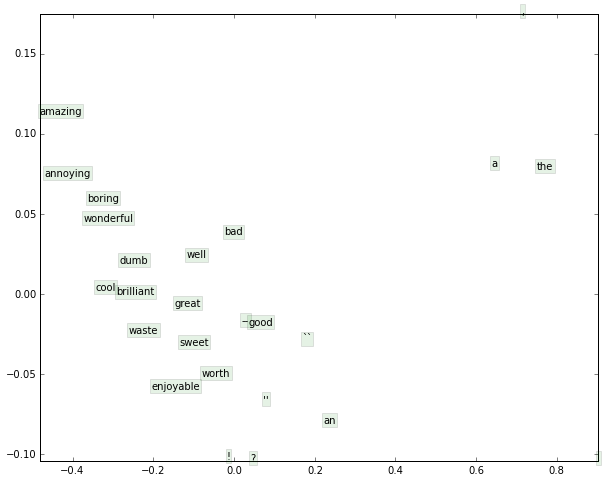

In [169]:
# Visualize the word vectors you trained

_, wordVectors0, _ = load_saved_params()
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])
visualizeWords = ["the", "a", "an", ",", ".", "?", "!", "``", "''", "--", "good", "great", "cool", "brilliant", "wonderful", "well", "amazing", "worth", "sweet", "enjoyable", "boring", "bad", "waste", "dumb", "annoying"]
visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2]) 

for i in xrange(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i], bbox=dict(facecolor='green', alpha=0.1))
    
plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

## 4. Sentiment Analysis

Now, with the word vectors you trained, we are going to perform a simple sentiment analysis.

For each sentence in the Stanford Sentiment Treebank dataset, we are going to use the average of all the word vectors in that sentence as its feature, and try to predict the sentiment level of the said sentence. The sentiment level of the phrases are represented as real values in the original dataset, here we'll just use five classes:

    "very negative", "negative", "neutral", "positive", "very positive"
    
which are represented by 0 to 4 in the code, respectively.

For this part, you will learn to train a softmax regressor with SGD, and perform train/dev validation to improve generalization of your regressor.

In [174]:
# Now, implement some helper functions

def getSentenceFeature(tokens, wordVectors, sentence):
    """ Obtain the sentence feature for sentiment analysis by averaging its word vectors """
    ###################################################################
    # Implement computation for the sentence features given a         #
    # sentence.                                                       #
    # Inputs:                                                         #
    #   - tokens: a dictionary that maps words to their indices in    #
    #             the word vector list                                #
    #   - wordVectors: word vectors for all tokens                    #
    #   - sentence: a list of words in the sentence of interest       #
    # Output:                                                         #
    #   - sentVector: feature vector for the sentence                 #
    ###################################################################
    n = float(len(sentence))
    
    sentVector = reduce((lambda x, y: wordVectors[tokens[y]] + x), sentence,
                        np.zeros(wordVectors.shape[1]))/n  # third arg is base case of reduce

    return sentVector

def softmaxRegression(features, labels, weights, regularization = 0.0, nopredictions = False):
    """ Softmax Regression """
    ###################################################################
    # Implement softmax regression with weight regularization.        #
    # Inputs:                                                         #
    #   - features: feature vectors, each row is a feature vector     #
    #   - labels: labels corresponding to the feature vectors         #
    #   - weights: weights of the regressor                           #
    #   - regularization: L2 regularization constant                  #
    # Output:                                                         #
    #   - cost: cost of the regressor                                 #
    #   - grad: gradient of the regressor cost with respect to its    #
    #           weights                                               #
    #   - pred: label predictions of the regressor (you might find    #
    #           np.argmax helpful)                                    #
    ###################################################################
    
    probs = softmax(features.dot(weights))
    if len(features.shape) > 1:
        N = features.shape[0]
    else:
        N = 1
    # A vectorized implementation of    1/N * sum(cross_entropy(x_i, y_i)) + 1/2*|w|^2_F
    cost = -np.sum(np.log(probs[range(N), labels])) / N 
    cost += 0.5 * regularization * np.sum(weights ** 2)

    pred = np.argmax(probs, axis=1)

    grad = probs
    grad[range(N), labels] -= 1
    grad = np.dot(features.T, grad) / N
    grad += regularization * weights

    if nopredictions:
        return cost, grad
    else:
        return cost, grad, pred

def precision(y, yhat):
    """ Precision for classifier """
    assert(y.shape == yhat.shape)
    return np.sum(y == yhat) * 100.0 / y.size

def softmax_wrapper(features, labels, weights, regularization = 0.0):
    cost, grad, _ = softmaxRegression(features, labels, weights, regularization)
    return cost, grad

In [175]:
# Gradient check always comes first
random.seed(314159)
np.random.seed(265)
dummy_weights = 0.1 * np.random.randn(dimVectors, 5)
dummy_features = np.zeros((10, dimVectors))
dummy_labels = np.zeros((10,), dtype=np.int32)    
for i in xrange(10):
    words, dummy_labels[i] = dataset.getRandomTrainSentence()
    dummy_features[i, :] = getSentenceFeature(tokens, wordVectors, words)
print "==== Gradient check for softmax regression ===="
gradcheck_naive(lambda weights: softmaxRegression(dummy_features, dummy_labels, weights, 1.0, nopredictions = True), dummy_weights)

print "\n=== For autograder ==="
print softmaxRegression(dummy_features, dummy_labels, dummy_weights, 1.0)

==== Gradient check for softmax regression ====
Gradient check passed!

=== For autograder ===
(1.9087572203226311, array([[ 0.13471085,  0.0104175 ,  0.06464052,  0.14678234,  0.07468882],
       [-0.11082732, -0.0753506 ,  0.00940976,  0.09072251,  0.02397455],
       [ 0.02857999, -0.07050319,  0.00609608, -0.00242226, -0.08065193],
       [ 0.1165844 ,  0.23443669, -0.03104372, -0.05643964, -0.03242766],
       [ 0.16402121,  0.07514553, -0.06366103,  0.00533061, -0.24784793],
       [ 0.00873329, -0.03116552,  0.28757243,  0.11892055,  0.09353462],
       [-0.14699131, -0.16446357, -0.23492789, -0.14272223,  0.08556511],
       [ 0.10900431,  0.06290933, -0.03857583,  0.10949341, -0.11392697],
       [-0.25459777,  0.17492415,  0.07520622,  0.09168167,  0.02080977],
       [-0.05482908, -0.0023394 ,  0.10969091, -0.06085632,  0.10433387]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64))


In [182]:
# Try different regularizations and pick the best!

### YOUR CODE HERE

regularization = 0.00003  # try 0.0, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01 and pick the best

### END YOUR CODE

random.seed(3141)
np.random.seed(59265)
weights = np.random.randn(dimVectors, 5)

trainset = dataset.getTrainSentences()
nTrain = len(trainset)
trainFeatures = np.zeros((nTrain, dimVectors))
trainLabels = np.zeros((nTrain,), dtype=np.int32)

for i in xrange(nTrain):
    words, trainLabels[i] = trainset[i]
    trainFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)

# We will do batch optimization
weights = sgd(lambda weights: softmax_wrapper(trainFeatures, trainLabels, weights, regularization), weights, 3.0, 10000, PRINT_EVERY=100)

# Prepare dev set features
devset = dataset.getDevSentences()
nDev = len(devset)
devFeatures = np.zeros((nDev, dimVectors))
devLabels = np.zeros((nDev,), dtype=np.int32)

for i in xrange(nDev):
    words, devLabels[i] = devset[i]
    devFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)

_, _, pred = softmaxRegression(devFeatures, devLabels, weights)
print "Dev precision (%%): %f" % precision(devLabels, pred)

Iteration: 100 | Cost: 1.5714
Iteration: 200 | Cost: 1.57097


Iteration: 300 | Cost: 1.57058


Iteration: 400 | Cost: 1.5702


Iteration: 500 | Cost: 1.56985


Iteration: 600 | Cost: 1.56953


Iteration: 700 | Cost: 1.56922


Iteration: 800 | Cost: 1.56893


Iteration: 900 | Cost: 1.56865


Iteration: 1000 | Cost: 1.56839


Iteration: 1100 | Cost: 1.56815


Iteration: 1200 | Cost: 1.56792


Iteration: 1300 | Cost: 1.5677


Iteration: 1400 | Cost: 1.56749


Iteration: 1500 | Cost: 1.56729


Iteration: 1600 | Cost: 1.56711


Iteration: 1700 | Cost: 1.56693


Iteration: 1800 | Cost: 1.56676


Iteration: 1900 | Cost: 1.5666


Iteration: 2000 | Cost: 1.56645


Iteration: 2100 | Cost: 1.5663


Iteration: 2200 | Cost: 1.56617


Iteration: 2300 | Cost: 1.56603


Iteration: 2400 | Cost: 1.56591


Iteration: 2500 | Cost: 1.56579


Iteration: 2600 | Cost: 1.56567


Iteration: 2700 | Cost: 1.56556


Iteration: 2800 | Cost: 1.56546


Iteration: 2900 | Cost: 1.56536


Iteration: 3000 | Cost: 1.56526


Iteration: 3100 | Cost: 1.56517


Iteration: 3200 | Cost: 1.56508


Iteration: 3300 | Cost: 1.565


Iteration: 3400 | Cost: 1.56492


Iteration: 3500 | Cost: 1.56484


Iteration: 3600 | Cost: 1.56477


Iteration: 3700 | Cost: 1.56469


Iteration: 3800 | Cost: 1.56463


Iteration: 3900 | Cost: 1.56456


Iteration: 4000 | Cost: 1.5645


Iteration: 4100 | Cost: 1.56444


Iteration: 4200 | Cost: 1.56438


Iteration: 4300 | Cost: 1.56432


Iteration: 4400 | Cost: 1.56427


Iteration: 4500 | Cost: 1.56421


Iteration: 4600 | Cost: 1.56416


Iteration: 4700 | Cost: 1.56411


Iteration: 4800 | Cost: 1.56407


Iteration: 4900 | Cost: 1.56402


Iteration: 5000 | Cost: 1.56398


Iteration: 5100 | Cost: 1.56394


Iteration: 5200 | Cost: 1.5639


Iteration: 5300 | Cost: 1.56386


Iteration: 5400 | Cost: 1.56382


Iteration: 5500 | Cost: 1.56379


Iteration: 5600 | Cost: 1.56375


Iteration: 5700 | Cost: 1.56372


Iteration: 5800 | Cost: 1.56369


Iteration: 5900 | Cost: 1.56365


Iteration: 6000 | Cost: 1.56362


Iteration: 6100 | Cost: 1.56359


Iteration: 6200 | Cost: 1.56357


Iteration: 6300 | Cost: 1.56354


Iteration: 6400 | Cost: 1.56351


Iteration: 6500 | Cost: 1.56349


Iteration: 6600 | Cost: 1.56346


Iteration: 6700 | Cost: 1.56344


Iteration: 6800 | Cost: 1.56342


Iteration: 6900 | Cost: 1.56339


Iteration: 7000 | Cost: 1.56337


Iteration: 7100 | Cost: 1.56335


Iteration: 7200 | Cost: 1.56333


Iteration: 7300 | Cost: 1.56331


Iteration: 7400 | Cost: 1.5633


Iteration: 7500 | Cost: 1.56328


Iteration: 7600 | Cost: 1.56326


Iteration: 7700 | Cost: 1.56324


Iteration: 7800 | Cost: 1.56323


Iteration: 7900 | Cost: 1.56321


Iteration: 8000 | Cost: 1.5632


Iteration: 8100 | Cost: 1.56318


Iteration: 8200 | Cost: 1.56317


Iteration: 8300 | Cost: 1.56315


Iteration: 8400 | Cost: 1.56314


Iteration: 8500 | Cost: 1.56313


Iteration: 8600 | Cost: 1.56311


Iteration: 8700 | Cost: 1.5631


Iteration: 8800 | Cost: 1.56309


Iteration: 8900 | Cost: 1.56308


Iteration: 9000 | Cost: 1.56307


Iteration: 9100 | Cost: 1.56306


Iteration: 9200 | Cost: 1.56305


Iteration: 9300 | Cost: 1.56304


Iteration: 9400 | Cost: 1.56303


Iteration: 9500 | Cost: 1.56302


Iteration: 9600 | Cost: 1.56301


Iteration: 9700 | Cost: 1.563


Iteration: 9800 | Cost: 1.56299


Iteration: 9900 | Cost: 1.56298


Iteration: 10000 | Cost: 1.56298


Dev precision (%): 30.881017


In [183]:
# Write down the best regularization and accuracy you found
# sanity check: your accuracy should be around or above 30%

### YOUR CODE HERE

BEST_REGULARIZATION = 0.00003
BEST_ACCURACY = 30.881017

### END YOUR CODE

print "=== For autograder ===\n%g\t%g" % (BEST_REGULARIZATION, BEST_ACCURACY)

=== For autograder ===
3e-05	30.881


In [184]:
# Test your findings on the test set

testset = dataset.getTestSentences()
nTest = len(testset)
testFeatures = np.zeros((nTest, dimVectors))
testLabels = np.zeros((nTest,), dtype=np.int32)

for i in xrange(nTest):
    words, testLabels[i] = testset[i]
    testFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)
    
_, _, pred = softmaxRegression(testFeatures, testLabels, weights)
print "=== For autograder ===\nTest precision (%%): %f" % precision(testLabels, pred)

=== For autograder ===
Test precision (%): 28.235294


#### Extra Credit

Train your own classifier for sentiment analysis! We will not provide any starter code for this part, but you can feel free to reuse the code you've written before, or write some new code for this task. Also feel free to refer to the code we provided you with to see how we scaffolded training for you.

Try to contain all of your code in one code block. You could start by using multiple blocks, then paste code together and remove unnecessary blocks. Report, as the last two lines of the output of your block, the dev set accuracy and test set accuracy you achieved, in the format we used above.

*Note: no credits will be given for this part if you use the dev or test sets for training, or if you fine-tune your regularization or other hyperparameters on the test set.*

In [ ]:
### YOUR CODE HERE

### END YOU CODE


_, _, pred = softmaxRegression(devFeatures, devLabels, weights)
print "=== For autograder ===\nDev precision (%%): %f" % precision(devLabels, pred)
_, _, pred = softmaxRegression(testFeatures, testLabels, weights)
print "Test precision (%%): %f" % precision(testLabels, pred)